## 기본 시스템 설정

###  시스템 저장 및 결과 저장 위치 설정
     * 기본적으로 개발서버에서 진행하고 지정된 작업경로에 저장 후 시스템 담당자에게 전달
     * 시스템 담당자는 운영 서버의 Retention 모델 경로에 해당 모델을 저장 후 운영 파이썬 관리 ini파일 수정

In [17]:
#★하드코딩 설정 문구 : 서버 위치, 테이블명. ini파일 사용하여 시스템 연관부분은 공통관리★
#configparser :  
import configparser
conf_dir = '/home/cdsadmin/python_src/EY/Emart/conf/config.ini'
cfg = configparser.ConfigParser(interpolation=configparser.ExtendedInterpolation())
cfg.read(conf_dir)
#기본 데이터 전처리용 패키지 불러오기
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import os

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

import seaborn as sns
import matplotlib.font_manager as fm
from collections import Counter
import time
from hdbcli import dbapi

pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)
pd.options.display.float_format = '{:.5f}'.format


# 1) 테이블 생성 할 HANA DB서버 접속정보
global HOST,PORT,DB_ID,DB_PW
HOST = cfg['dbconnect']['host']
PORT = int(cfg['dbconnect']['port'])
DB_ID = cfg['dbconnect']['ID']
DB_PW = cfg['dbconnect']['PW']

# 2) 학습 생성 데이터 불러오기 위치
TB_NM  = 'TB_AMT_RETENTION_TRAIN'  

#3) 학습용 모델 저장위치
DIR_NM1 = '/home/cdsadmin/python_src/EY/YUN/model_result/' #배정 받은 개발 서버내 주피터 작업공간
MODEL1_NM = 'model_retention1_VIP' #적합용 모델 명칭 우수고객용
MODEL2_NM = 'model_retention2_Normal' #적합용 모델 명칭 일반고객용

#4) 학습 후 모델결과 리뷰용 데이터 저장위치
DIR_NM2 = '/home/cdsadmin/python_src/EY/YUN/data/' #배정 받은 개발 서버내 주피터 작업공간

#모델 기준 학습월 과거 시점 : 1은 1개월 전, 최소 4로 설정해야 3개월 학습가능.
BF_MONTHS=9

###  베인등급 산정대상 기준월 확인

In [18]:
#학습대상 베인등급 기준월 확인 : 3미만 값 입력 시 최소 4개월로 설정되도록 기본값
from datetime import datetime
from dateutil.relativedelta import relativedelta
mask ='%Y%m'

if BF_MONTHS > 3:
    YM_BAIN = (datetime.now() + relativedelta(months=-BF_MONTHS)).strftime(mask)
    print(f"'{YM_BAIN}'", '베인등급 기준 미래 3개월 이탈 예측 모델 개발이 진행 됩니다.')
else:
    YM_BAIN= (datetime.now() + relativedelta(months=-4)).strftime(mask)
    print("BF_MONTHS 설정 값을 확인 해 주세요.",  "\n",
          "변경 사항 없을 시" , f"'{YM_BAIN}'" , "베인등급 기준 미래 3개월 이탈 예측 모델 개발이 진행 됩니다.")

'202005' 베인등급 기준 미래 3개월 이탈 예측 모델 개발이 진행 됩니다.


**[케이스별 적합 모델 탐색]**
    
    1. 학습 데이터 
       타겟 우수(Bain등급 Loyal, Potential) 일반(Bain등급 Average, Sporadic) 중 사전 정의된 이탈해당 고객
       우수 : 3개월간 Bain등급이 상승하거나 구매금액 합계가 50%이상 하락한 고객
       일반 : 3개월간 구매이력 없는 고객
       DNA 및 영수증 데이터 직접 또는 파생변수 생성
    
    2. 적용 알고리즘
       Bain등급 우수 대상 : Cat boost
       Bain등급 중 일반 대상 : Light GBM

##   1. 이탈 예측 모형 :  데이터 생성 및 불러오기

    - 사전 알고리즘 비교 및 변수 중요도 분석을 통해 결정된 35개의 변수를 활용한 모델 생성 시작

### 모델학습용 테이블 생성 :  ★ 학습데이터 대상변수 항목 변경 시 함께 수정 필수 ★
   - 영수증 및 DNA 테이블을 사용하여 SAP HANA 서버에 학습용 테이블을 생성
   - 불러오기는 multi processing 사용
   - 설명 등을 추가하기 위해 빈테이블 생성 후 insert방식 사용

In [11]:
#서버에 물리테이블 생성하는 SQL : 위에 설정한 Bain등급 기준월에 맞춰 사용하는 영수증 및 DNA기간 지정 됨.
sql1 = f'''
DROP TABLE {TB_NM}_{YM_BAIN}
'''

sql2 = f'''
CREATE COLUMN TABLE {TB_NM}_{YM_BAIN} 				
(				
	BAIN_GRADE_YM	NVARCHAR(6)	NOT NULL  COMMENT	'베인등급 기준연월'
,	DNA_YM_WCNT	NVARCHAR(10)	NOT NULL  COMMENT	'DNA 기준연월'
,	CUST_ID	NVARCHAR(20)	NOT NULL  COMMENT	'고객번호'
,	TARGET_YN	TINYINT	NOT NULL  COMMENT	'이탈 예측 대상 여부(Y=1, N=0), 베인등급 기준 우수(loyal,potential)-직전분기대비 50%이상 구매액 하락 또는 등급하락, 일반(Average,Spradic)-3개월 구매없는 휴면인 경우 1'
,	BAIN_GRADE_CD	NVARCHAR(2)	NOT NULL  COMMENT	'회원등급_베인등급 코드'
,	GRADE_NM	NVARCHAR(100)	COMMENT	'회원등급_베인등급 이름'
,	BAIN_GRADE_CD_AF1M	NVARCHAR(2)	COMMENT	'베인등급 1개월 후'
,	BAIN_GRADE_CD_AF2M	NVARCHAR(2)	COMMENT	'베인등급 2개월 후'
,	BAIN_GRADE_CD_AF3M	NVARCHAR(2)	COMMENT	'베인등급 3개월 후'
,	LV_CHG_CAT	NVARCHAR(3)	COMMENT	'베인등급 변화 유형상세'
,	LV_CHG_G	NVARCHAR(10)	COMMENT	'베인등급 변화 유형그룹(3개월 동안 기준 등급월 대비 등급 변화, 하락이 1회 이상 경우 하락, 하락 이력 없이 1회 이상 상승 시 상승, 그 외 유지)'
,	SALE_AMT_DIFF_GRADE	NVARCHAR(2)	COMMENT	'구매금액 변화율_A(25%미만하락)/B(25~50%미만하락)/C(50~75%미만하락)/D(75~100%하락)/E(구매없음)/X(상승 또는 유지)'
,	AGE	SMALLINT	COMMENT	'연령'
,	LSTAGE_GROUP	NVARCHAR(10)	COMMENT	'라이프스테이지 코드'
,	LSTAGE_NM	NVARCHAR(100)	COMMENT	'라이프 스테이지 명'
,	FRST_PARTY_ELAPSE	SMALLINT	COMMENT	'회원 가입경과일'
,	GRADE_EMART_001_01	NVARCHAR(2)	COMMENT	'회원등급_이마트 업태'
,	USEFL_POINT_EX	DECIMAL(30)	COMMENT	'신세계포인트 잔액(산출시점 기준 환산)'
,	POINT_SAVE_6M	DECIMAL(30)	COMMENT	'신세계포인트 6개월간 적립액'
,	PURCHS_CYCLE_CHG	DECIMAL(30,6)	COMMENT	'구매주기 변동성'
,	DAVG_PURCHS_AMT_CHG	DECIMAL(30,6)	COMMENT	'회당 객단가 변동성'
,	PURCHS_CYCLE_ELAPSE_OFF_BIZTP	SMALLINT	COMMENT	'타업태이용실적_오프라인전체_구매경과일'
,	ORD_4QTY	TINYINT	COMMENT	'연간 분기별 구매여부 합계(최대4)'
,	PURCHS_CYCLE_ELAPSE	SMALLINT	COMMENT	'구매경과일'
,	CNT_TOT_6M	DECIMAL(30)	COMMENT	'구매횟수 6개월 합계'
,	CNT_DIFF_Q1_Q2	DECIMAL(30)	COMMENT	'구매횟수 증감(최근3개월과 4~6개월전 비교)'
,	CNT_DIFF_Q2_Q3	DECIMAL(30)	COMMENT	'구매횟수 증감(4~6개월전과 7~9개월전 비교)'
,	CNT_DIFF_Q3_Q4	DECIMAL(30)	COMMENT	'구매횟수 증감(7~9개월전과 10~12개월전 비교)'
,	DAVG_AMT_DIFF_Q1_Q2	DECIMAL(30,3)	COMMENT	'회당객단가 증감(4~6개월전과 7~9개월전 비교)'
,	DAVG_AMT_DIFF_Q2_Q3	DECIMAL(30,3)	COMMENT	'회당객단가 증감(4~6개월전과 7~9개월전 비교)'
,	DAVG_AMT_DIFF_Q3_Q4	DECIMAL(30,3)	COMMENT	'회당객단가 증감(7~9개월전과 10~12개월전 비교)'
,	DAVG_AMT_RT_Q1_Q2	DECIMAL(30,6)	COMMENT	'회당객단가 증감율(최근3개월과 4~6개월전 비교)'
,	DAVG_AMT_RT_Q2_Q3	DECIMAL(30,6)	COMMENT	'회당객단가 증감율(4~6개월전과 7~9개월전 비교)'
,	DAVG_AMT_RT_Q3_Q4	DECIMAL(30,6)	COMMENT	'회당객단가 증감율(7~9개월전과 10~12개월전 비교)'
,	PURCHS_CYCLE_ELAPSE_LV1_10	SMALLINT	COMMENT	'구매경과일(신선1담당)'
,	PURCHS_CYCLE_ELAPSE_LV1_11	SMALLINT	COMMENT	'구매경과일(신선2담당)'
,	PURCHS_CYCLE_ELAPSE_LV1_30	SMALLINT	COMMENT	'구매경과일(가공담당)'
,	PURCHS_CYCLE_ELAPSE_LV1_40	SMALLINT	COMMENT	'구매경과일(헬스&일상담당)'
,	PURCHS_CYCLE_ELAPSE_LV1_41	SMALLINT	COMMENT	'구매경과일(리빙담당)'
,	PURCHS_CYCLE_ELAPSE_LV1_50	SMALLINT	COMMENT	'구매경과일(가전문화담당)'
,	PURCHS_CYCLE_ELAPSE_LV1_60	SMALLINT	COMMENT	'구매경과일(패션사업부)'
,	PURCHS_CYCLE_ELAPSE_LV1_70	SMALLINT	COMMENT	'구매경과일(기타)'
,	CNT_LV1_10_TOT	DECIMAL(30)	COMMENT	'구매횟수 6개월 합계(신선1담당)'
,	CNT_LV1_20_TOT	DECIMAL(30)	COMMENT	'구매횟수 6개월 합계(피코크담당)'
,	CNT_LV1_30_TOT	DECIMAL(30)	COMMENT	'구매횟수 6개월 합계(가공담당)'
,	CNT_LV1_40_TOT	DECIMAL(30)	COMMENT	'구매횟수 6개월 합계(헬스&일상담당)'
,	CNT_LV1_70_TOT	DECIMAL(30)	COMMENT	'구매횟수 6개월 합계(기타)'
,	DAVG_AMT_LV1_50_RT	DECIMAL(30,6)	COMMENT	'회당객단가 증감율(최근DNA와 3개월전 DNA비교)(가전문화담당)'
				
, 	CONSTRAINT {TB_NM}_{YM_BAIN} PRIMARY KEY (BAIN_GRADE_YM,DNA_YM_WCNT,CUST_ID,BAIN_GRADE_CD)			
)
UNLOAD PRIORITY 5 AUTO MERGE COMMENT '(분석마트)Retention모델 월별 고객이탈예측학습테이블' 				
'''

sql3 = f'''
INSERT INTO {TB_NM}_{YM_BAIN}
(WITH  
RETENTION_TARGET1 AS(
SELECT 
--T2.*,
'{YM_BAIN}' AS BAIN_GRADE_YM
,T2.CUST_ID  
,T2.GRADE_CD AS BAIN_GRADE_CD 

,T2.GRADE_CD_AF1M AS BAIN_GRADE_CD_AF1M
,T2.GRADE_CD_AF2M AS BAIN_GRADE_CD_AF2M
,T2.GRADE_CD_AF3M AS BAIN_GRADE_CD_AF3M

--LV_CHG_CAT1_CAT2_M1||LV_CHG_CAT1_M2||LV_CHG_CAT1_M3 AS CHG_CAT1,

,LV_CHG_CAT1_CAT2_M1||LV_CHG_CAT2_M2||LV_CHG_CAT2_M3 AS LV_CHG_CAT

--CASE WHEN   LV_DWGRADE_CNT_0M_base > 0  THEN 1 ELSE 0  END AS LV_DWGRADE_YN,

--CASE WHEN   LV_DWGRADE_CNT_0M_base = 0 AND LV_UPGRADE_CNT_0M_base > 0  THEN 1 ELSE 0  END AS LV_UPGRADE_YN,

,CASE WHEN  LV_DWGRADE_CNT_0M_base > 0  THEN '1하락'
     WHEN  LV_UPGRADE_CNT_0M_base > 0  THEN '2상승' ELSE '3유지' END AS LV_CHG_G
     
,CASE WHEN  LV_DWGRADE_CNT_0M_base > 0  THEN 1
ELSE 0  END AS TARGET_YN_GRADE



FROM ( SELECT
	T1.CUST_ID ,
	T1.GRADE_CD ,
	T1.GRADE_CD_AF1M ,
	T1.GRADE_CD_AF2M ,
	T1.GRADE_CD_AF3M , 
	
--	T1.GRADE_LV_DIFF_0M_AF1M ,
--	T1.GRADE_LV_DIFF_AF1M_AF2M ,
--    T1.GRADE_LV_DIFF_AF2M_AF3M ,
--    
--	T1.GRADE_LV_DIFF_0M_AF2M ,
--    T1.GRADE_LV_DIFF_0M_AF3M ,    
    
	(CASE
		WHEN T1.GRADE_LV_DIFF_0M_AF1M > 0 THEN '+' WHEN T1.GRADE_LV_DIFF_0M_AF1M = 0 THEN '0'
		ELSE '-'
	END) AS LV_CHG_CAT1_CAT2_M1 ,
--	(CASE
--		WHEN T1.GRADE_LV_DIFF_AF1M_AF2M > 0 THEN '+' WHEN T1.GRADE_LV_DIFF_AF1M_AF2M = 0 THEN '0'
--		ELSE '-'
--	END) AS LV_CHG_CAT1_M2 ,
--	(CASE
--		WHEN T1.GRADE_LV_DIFF_AF2M_AF3M > 0 THEN '+'  WHEN T1.GRADE_LV_DIFF_AF2M_AF3M = 0 THEN '0'
--		ELSE '-'
--	END) AS LV_CHG_CAT1_M3,
	
	(CASE
		WHEN T1.GRADE_LV_DIFF_0M_AF2M > 0 THEN '+' WHEN T1.GRADE_LV_DIFF_AF1M_AF2M = 0 THEN '0'
		ELSE '-'
	END) AS LV_CHG_CAT2_M2 ,
	(CASE
		WHEN T1.GRADE_LV_DIFF_0M_AF3M > 0 THEN '+'  WHEN T1.GRADE_LV_DIFF_AF2M_AF3M = 0 THEN '0'
		ELSE '-'
	END) AS LV_CHG_CAT2_M3,	
	
	
--	(CASE
--		WHEN T1.GRADE_LV_DIFF_0M_AF1M > 0 THEN 1
--		ELSE 0
--	END )+
--	(CASE
--		WHEN T1.GRADE_LV_DIFF_AF1M_AF2M > 0 THEN 1
--		ELSE 0
--	END )+
--	(CASE
--		WHEN T1.GRADE_LV_DIFF_AF2M_AF3M > 0 THEN 1
--		ELSE 0
--	END ) AS LV_UPGRADE_CNT_TOT,
--	
--	
--	(CASE
--		WHEN T1.GRADE_LV_DIFF_0M_AF1M < 0 THEN 1
--		ELSE 0
--	END )+
--	(CASE
--		WHEN T1.GRADE_LV_DIFF_AF1M_AF2M < 0 THEN 1
--		ELSE 0
--	END )+
--	(CASE
--		WHEN T1.GRADE_LV_DIFF_AF2M_AF3M < 0 THEN 1
--		ELSE 0
--	END ) AS LV_DWGRADE_CNT_TOT,
	
	
	
	(CASE
		WHEN T1.GRADE_LV_DIFF_0M_AF1M > 0 THEN 1
		ELSE 0
	END ) +
	(CASE
		WHEN T1.GRADE_LV_DIFF_0M_AF2M > 0  THEN 1
		ELSE 0
	END )+
	(CASE
		WHEN T1.GRADE_LV_DIFF_0M_AF3M > 0 THEN 1
		ELSE 0
	END ) AS LV_UPGRADE_CNT_0M_base,
	
	
	(CASE
		WHEN T1.GRADE_LV_DIFF_0M_AF1M < 0 THEN 1
		ELSE 0
	END )+
	(CASE
		WHEN T1.GRADE_LV_DIFF_0M_AF2M < 0 THEN 1
		ELSE 0
	END )+
	(CASE
		WHEN T1.GRADE_LV_DIFF_0M_AF3M < 0 THEN 1
		ELSE 0
	END ) AS LV_DWGRADE_CNT_0M_base
	
FROM (
		SELECT  
				  a.CUST_ID
		        , GRADE_CD  /* 비교 기준 베인등급월 1: loyal 2 : potential 3 :average 4: sporadic */
		        , (GRADE_CD_AF1M) AS GRADE_CD_AF1M
		        , (GRADE_CD_AF2M) AS GRADE_CD_AF2M
		        , (GRADE_CD_AF3M) AS GRADE_CD_AF3M
		        
		        
		        , (GRADE_CD - GRADE_CD_AF1M) AS GRADE_LV_DIFF_0M_AF1M /*기준월과 1개월 후  베인등급 차이 */
		        , (GRADE_CD_AF1M - GRADE_CD_AF2M) AS GRADE_LV_DIFF_AF1M_AF2M /*1개월 후와 2개월 후  베인등급 차이 */
		        , (GRADE_CD_AF2M - GRADE_CD_AF3M) AS GRADE_LV_DIFF_AF2M_AF3M /*2개월 후와 3개월 후  베인등급 차이 */
		        
		        , (GRADE_CD - GRADE_CD_AF2M) AS GRADE_LV_DIFF_0M_AF2M /*기준월과 2개월 후  베인등급 차이 */
                , (GRADE_CD - GRADE_CD_AF3M) AS GRADE_LV_DIFF_0M_AF3M /*기준월과 3개월 후  베인등급 차이 */
 
		 FROM (SELECT A2.CUST_ID FROM CDS_DW.TB_BAIN_MEMBR_GRADE a1 JOIN  CDS_AMT.TB_AMT_BIZTP_CUST_DNA_DATA a2 
		 ON a1.CUST_ID=a2.CUST_ID AND a2.AFLCO_CD ='001' AND a2.BIZTP_CD ='10' AND TO_CHAR(a2.YM_WCNT ,'YYYYMMDD')= CONCAT( TO_CHAR(ADD_MONTHS('{YM_BAIN}',+1),'YYYYMM'),'01')  AND a1.GRADE_YM='{YM_BAIN}' ) a, 
		 (SELECT CUST_ID 
				   ,COALESCE(MAX(CASE WHEN  GRADE_YM = to_char(ADD_MONTHS('{YM_BAIN}' , +0),'YYYYMM') 
						THEN to_integer(GRADE_CD) END) ,5) AS GRADE_CD 
				   ,COALESCE(MAX(CASE WHEN GRADE_YM = to_char(ADD_MONTHS('{YM_BAIN}' , +1),'YYYYMM') 
						THEN to_integer(GRADE_CD) END) ,5) AS GRADE_CD_AF1M
				   ,COALESCE(MAX(CASE WHEN GRADE_YM = to_char(ADD_MONTHS('{YM_BAIN}' , +2),'YYYYMM') 
						THEN  to_integer(GRADE_CD) END),5) AS GRADE_CD_AF2M
				   ,COALESCE(MAX(CASE WHEN GRADE_YM = to_char(ADD_MONTHS('{YM_BAIN}' , +3),'YYYYMM')
						THEN  to_integer(GRADE_CD) END),5) AS GRADE_CD_AF3M
			FROM  CDS_DW.TB_BAIN_MEMBR_GRADE 
			  WHERE  GRADE_YM  >= to_char(ADD_MONTHS('{YM_BAIN}' ,+0),'YYYYMM') 
			  AND GRADE_YM <= to_char(ADD_MONTHS('{YM_BAIN}' , +3),'YYYYMM') 
			GROUP BY CUST_ID ) b WHERE  a.CUST_ID=b.CUST_ID
	 
	) T1 ) T2 
  ),

RETENTION_TARGET2 AS (
SELECT   
		T1.BAIN_GRADE_YM
		,T1.CUST_ID
		,T1.BAIN_GRADE_CD
		,T1.SALE_AMT_DIFF_GRADE
--      ,T1.SALE_FREQUENCY_DIFF_GRADE
--		,CASE WHEN BAIN_GRADE_CD IN ('1','2') AND  T1.SALE_AMT_DIFF_GRADE IN ('C','D','E') AND  T1.SALE_FREQUENCY_DIFF_GRADE IN ('C','D','E')  THEN 1
--		WHEN BAIN_GRADE_CD IN ('3','4') AND  T1.SALE_AMT_DIFF_GRADE IN ('E') THEN 1
--		ELSE 0 END AS TARGET_YN
--		,CASE WHEN BAIN_GRADE_CD IN ('1','2') AND (T1.SALE_AMT_DIFF_GRADE IN ('C','D','E') or  T1.SALE_FREQUENCY_DIFF_GRADE IN ('C','D','E') ) THEN 1
--		WHEN BAIN_GRADE_CD IN ('3','4') AND  T1.SALE_AMT_DIFF_GRADE IN ('E') THEN 1
--		ELSE 0 END AS TARGET_YN_CNT_AMT
--		,CASE WHEN BAIN_GRADE_CD IN ('1','2') AND T1.SALE_FREQUENCY_DIFF_GRADE IN ('C','D','E')  THEN 1
--		WHEN BAIN_GRADE_CD IN ('3','4') AND  T1.SALE_AMT_DIFF_GRADE IN ('E') THEN 1
--		ELSE 0 END AS TARGET_YN_CNT
		,CASE WHEN T1.BAIN_GRADE_CD IN ('1','2') AND T1.SALE_AMT_DIFF_GRADE IN ('C','D','E')  THEN 1
		WHEN T1.BAIN_GRADE_CD IN ('3','4') AND  T1.SALE_AMT_DIFF_GRADE IN ('E') THEN 1
		ELSE 0 END AS TARGET_YN_AMT
		
FROM (
		SELECT 
		   	     B.CUST_ID
		       , B.BAIN_GRADE_CD  
		       , B.BAIN_GRADE_YM
--			   , SUM(CASE WHEN A.YM_CAT = 'P' THEN TOT_SALE_AMT END) AS PAST_3M_SALE_AMT
--		       , SUM(CASE WHEN A.YM_CAT = 'R' THEN TOT_SALE_AMT END) AS RECENT_3M_SALE_AMT
--		       , CASE 
--			     WHEN SUM(CASE WHEN A.YM_CAT = 'P' THEN TOT_SALE_AMT END) IS NOT NULL AND SUM(CASE WHEN A.YM_CAT = 'R' THEN TOT_SALE_AMT END) IS NULL
--			     THEN -101
--			     WHEN SUM(CASE WHEN A.YM_CAT = 'P' THEN TOT_SALE_AMT END) IS NULL AND SUM(CASE WHEN A.YM_CAT = 'R' THEN TOT_SALE_AMT END)IS NOT NULL
--			     THEN 101
--			     ELSE ROUND((SUM(CASE WHEN A.YM_CAT = 'R' THEN TOT_SALE_AMT END) - SUM(CASE WHEN A.YM_CAT = 'P' THEN TOT_SALE_AMT END)) 
--		                   / SUM(CASE WHEN A.YM_CAT = 'P' THEN TOT_SALE_AMT END) * 100,0)
--			      END  AS SALE_AMT_DIFF_RT
			   , CASE 
			     WHEN ROUND((SUM(CASE WHEN A.YM_CAT = 'R' THEN TOT_SALE_AMT END) - SUM(CASE WHEN A.YM_CAT = 'P' THEN TOT_SALE_AMT END)) 
		                   / SUM(CASE WHEN A.YM_CAT = 'P' THEN TOT_SALE_AMT END) * 100,0) BETWEEN -25 AND -1 
			     THEN 'A'
			     WHEN ROUND((SUM(CASE WHEN A.YM_CAT = 'R' THEN TOT_SALE_AMT END) - SUM(CASE WHEN A.YM_CAT = 'P' THEN TOT_SALE_AMT END)) 
		                   / SUM(CASE WHEN A.YM_CAT = 'P' THEN TOT_SALE_AMT END) * 100,0) BETWEEN -50 AND -26 
			     THEN 'B'
			     WHEN ROUND((SUM(CASE WHEN A.YM_CAT = 'R' THEN TOT_SALE_AMT END) - SUM(CASE WHEN A.YM_CAT = 'P' THEN TOT_SALE_AMT END)) 
		                   / SUM(CASE WHEN A.YM_CAT = 'P' THEN TOT_SALE_AMT END) * 100,0) BETWEEN -75 AND -51 
			     THEN 'C'
			     WHEN ROUND((SUM(CASE WHEN A.YM_CAT = 'R' THEN TOT_SALE_AMT END) - SUM(CASE WHEN A.YM_CAT = 'P' THEN TOT_SALE_AMT END)) 
		                   / SUM(CASE WHEN A.YM_CAT = 'P' THEN TOT_SALE_AMT END) * 100,0) BETWEEN -100 AND -76 
			     THEN 'D'
			     WHEN SUM(CASE WHEN A.YM_CAT = 'P' THEN TOT_SALE_AMT END) IS NOT NULL AND SUM(CASE WHEN A.YM_CAT = 'R' THEN TOT_SALE_AMT END) IS NULL
			     THEN 'E'
			     
			     WHEN SUM(CASE WHEN A.YM_CAT = 'P' THEN TOT_SALE_AMT END) IS NULL AND SUM(CASE WHEN A.YM_CAT = 'R' THEN TOT_SALE_AMT END) IS NULL
			     THEN 'E'
			     			     
			     ELSE 'X'
			      END AS SALE_AMT_DIFF_GRADE   
--			   , SUM(CASE WHEN A.YM_CAT = 'P' THEN TOT_FREQUENCY_CNT END) AS PAST_3M_FREQUENCY_CNT
--		       , SUM(CASE WHEN A.YM_CAT = 'R' THEN TOT_FREQUENCY_CNT END) AS RECENT_3M_FREQUENCY_CNT
--		       , CASE 
--			     WHEN SUM(CASE WHEN A.YM_CAT = 'P' THEN TOT_FREQUENCY_CNT END) IS NOT NULL AND SUM(CASE WHEN A.YM_CAT = 'R' THEN TOT_FREQUENCY_CNT END) IS NULL
--			     THEN -101
--			     WHEN SUM(CASE WHEN A.YM_CAT = 'P' THEN TOT_FREQUENCY_CNT END) IS NULL AND SUM(CASE WHEN A.YM_CAT = 'R' THEN TOT_FREQUENCY_CNT END) IS NOT NULL
--			     THEN 101
--			     ELSE ROUND((SUM(CASE WHEN A.YM_CAT = 'R' THEN TOT_FREQUENCY_CNT END) - SUM(CASE WHEN A.YM_CAT = 'P' THEN TOT_FREQUENCY_CNT END)) 
--		                    / SUM(CASE WHEN A.YM_CAT = 'P' THEN TOT_FREQUENCY_CNT END) * 100,0)
--			      END  AS FREQUENCY_CNT_DIFF_RT
--			   , CASE 
--			     WHEN ROUND((SUM(CASE WHEN A.YM_CAT = 'R' THEN TOT_FREQUENCY_CNT END) - SUM(CASE WHEN A.YM_CAT = 'P' THEN TOT_FREQUENCY_CNT END)) 
--		                    / SUM(CASE WHEN A.YM_CAT = 'P' THEN TOT_FREQUENCY_CNT END) * 100,0) BETWEEN -25 AND -1 
--			     THEN 'A'
--			     WHEN ROUND((SUM(CASE WHEN A.YM_CAT = 'R' THEN TOT_FREQUENCY_CNT END) - SUM(CASE WHEN A.YM_CAT = 'P' THEN TOT_FREQUENCY_CNT END)) 
--		                    / SUM(CASE WHEN A.YM_CAT = 'P' THEN TOT_FREQUENCY_CNT END) * 100,0) BETWEEN -50 AND -26 
--			     THEN 'B'
--			     WHEN ROUND((SUM(CASE WHEN A.YM_CAT = 'R' THEN TOT_FREQUENCY_CNT END) - SUM(CASE WHEN A.YM_CAT = 'P' THEN TOT_FREQUENCY_CNT END)) 
--		                    / SUM(CASE WHEN A.YM_CAT = 'P' THEN TOT_FREQUENCY_CNT END) * 100,0) BETWEEN -75 AND -51 
--			     THEN 'C'
--			     WHEN ROUND((SUM(CASE WHEN A.YM_CAT = 'R' THEN TOT_FREQUENCY_CNT END) - SUM(CASE WHEN A.YM_CAT = 'P' THEN TOT_FREQUENCY_CNT END)) 
--		                    / SUM(CASE WHEN A.YM_CAT = 'P' THEN TOT_FREQUENCY_CNT END) * 100,0) BETWEEN -100 AND -76 
--			     THEN 'D'
--			     WHEN SUM(CASE WHEN A.YM_CAT = 'P' THEN TOT_FREQUENCY_CNT END) IS NOT NULL AND SUM(CASE WHEN A.YM_CAT = 'R' THEN TOT_FREQUENCY_CNT END) IS NULL
--			     THEN 'E'
--			     WHEN SUM(CASE WHEN A.YM_CAT = 'P' THEN TOT_FREQUENCY_CNT END) IS NULL AND SUM(CASE WHEN A.YM_CAT = 'R' THEN TOT_FREQUENCY_CNT END) IS NULL
--			     THEN 'E'
--			     ELSE 'X'
--			     END AS SALE_FREQUENCY_DIFF_GRADE    
		FROM  (
		       SELECT CUST_ID, BAIN_GRADE_CD , BAIN_GRADE_YM   
		       FROM RETENTION_TARGET1 
		     )  B  LEFT	JOIN
		     ( SELECT      CUST_ID 
						   , CASE WHEN TO_CHAR(BSN_DT,'YYYYMM')  BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}',-2),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}',-0),'YYYYMM') THEN 'P' 
					              WHEN TO_CHAR(BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}',+1),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}',+3),'YYYYMM') THEN'R'
					         END  AS YM_CAT
					       , SUM(SALE_SUM_AMT) AS  TOT_SALE_AMT
					       , count(DISTINCT BSN_DT) AS TOT_FREQUENCY_CNT 
				FROM  CDS_DW.TB_DW_RCIPT_HDER 
				WHERE  TO_CHAR( BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}',-2),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}', +3),'YYYYMM')
		  AND   BIZTP_CD        = '10'
		  --AND  A.SALE_TRGT_YN    = 'Y'               
		  AND   RL_SALE_TRGT_YN = 'Y'               
		  AND  SALE_SUM_AMT > 0 AND CUST_ID IS NOT NULL 
		GROUP BY CUST_ID, 
				CASE WHEN TO_CHAR(BSN_DT,'YYYYMM')  BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}',-2),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}',-0),'YYYYMM') THEN 'P' 
				     WHEN TO_CHAR(BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}',+1),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}',+3),'YYYYMM') THEN'R' END
		     )  A
	ON B.CUST_ID = A.CUST_ID 
		GROUP BY B.CUST_ID, B.BAIN_GRADE_CD, B.BAIN_GRADE_YM
  ) T1  ) ,

RCIPT_DETAIL AS  (
 SELECT
  B.CUST_ID
 ,A.BSN_DT 
-- ,A.PRDT_CD
-- ,C.PRDT_DCODE_CD
 ,D.PRDT_DI_CD
, sum(A.SALE_AMT)  AS SALE_AMT
		 FROM  (SELECT CUST_ID FROM RETENTION_TARGET1 ) B 
		 JOIN CDS_DW.TB_DW_RCIPT_DETAIL A ON B.CUST_ID=A.CUST_ID
		 JOIN (SELECT PRDT_CD , PRDT_DCODE_CD
		       FROM CDS_DW.TB_DW_PRDT_MASTR 
		       WHERE AFLCO_CD = '001' AND BIZTP_CD = '10') C ON A.PRDT_CD  = C.PRDT_CD
		 JOIN (SELECT PRDT_DCODE_CD,PRDT_DI_CD
		   	   FROM CDS_DW.TB_DW_PRDT_DCODE_CD
		   	   WHERE AFLCO_CD = '001' AND BIZTP_CD = '10') D ON C.PRDT_DCODE_CD  = D.PRDT_DCODE_CD 
		 WHERE TO_CHAR( BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}',-5),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}', +0),'YYYYMM')
		   AND A.AFLCO_CD ='001' 
		   AND A.BIZTP_CD ='10'
		   AND A.SALE_TRGT_YN    = 'Y'               
		   AND A.RL_SALE_TRGT_YN = 'Y'               
		   AND A.SALE_AMT > 0
		   AND A.CUST_ID IS NOT NULL
		   GROUP BY 
		   B.CUST_ID
		  ,A.BSN_DT
		--,A.PRDT_CD
		--,C.PRDT_DCODE_CD
		  ,D.PRDT_DI_CD
		  ), 

RCIPT_SUMMARY_1Y AS (
SELECT
CUST_ID,
CASE WHEN COALESCE(CNT_Q1,0) > 0  THEN 1 ELSE 0 END AS ORD_Q1_YN ,
COALESCE(CNT_Q1/NULLIF(CNT_Q1,0),0) + COALESCE(CNT_Q2/NULLIF(CNT_Q2,0),0) + COALESCE(CNT_Q3/NULLIF(CNT_Q3,0),0) + COALESCE(CNT_Q4/NULLIF(CNT_Q4,0),0) AS ORD_4QTY,
CASE WHEN
	COALESCE(CNT_Q1,0) > 0
			THEN 10+COALESCE(CNT_Q1/NULLIF(CNT_Q1,0),0) + COALESCE(CNT_Q2/NULLIF(CNT_Q2,0),0)  + COALESCE(CNT_Q3/NULLIF(CNT_Q3,0),0) + COALESCE(CNT_Q4/NULLIF(CNT_Q4,0),0) 
	ELSE
			COALESCE(CNT_Q1/NULLIF(CNT_Q1,0),0) + COALESCE(CNT_Q2/NULLIF(CNT_Q2,0),0)  + COALESCE(CNT_Q3/NULLIF(CNT_Q3,0),0) + COALESCE(CNT_Q4/NULLIF(CNT_Q4,0),0) 
	END AS ORD_4QTY_GRADE,

COALESCE(CNT_Q1,0)-COALESCE(CNT_Q2,0) AS CNT_DIFF_Q1_Q2 ,
COALESCE(CNT_Q2,0)-COALESCE(CNT_Q3,0) AS CNT_DIFF_Q2_Q3 ,
COALESCE(CNT_Q3,0)-COALESCE(CNT_Q4,0) AS CNT_DIFF_Q3_Q4 ,


CASE WHEN COALESCE(CNT_Q1,0) > 0 AND COALESCE(CNT_Q2,0)=0 THEN 1 ELSE COALESCE(COALESCE(CNT_Q1,0)/NULLIF(CNT_Q2,0) - 1,0) END AS CNT_RT_Q1_Q2 ,
CASE WHEN COALESCE(CNT_Q2,0) > 0 AND COALESCE(CNT_Q3,0)=0 THEN 1 ELSE COALESCE(COALESCE(CNT_Q2,0)/NULLIF(CNT_Q3,0) - 1,0) END AS CNT_RT_Q2_Q3 ,
CASE WHEN COALESCE(CNT_Q3,0) > 0 AND COALESCE(CNT_Q4,0)=0 THEN 1 ELSE COALESCE(COALESCE(CNT_Q3,0)/NULLIF(CNT_Q4,0) - 1,0) END AS CNT_RT_Q3_Q4 ,


 COALESCE(AMT_Q1/NULLIF(CNT_Q1,0),0)-COALESCE(CNT_Q2/NULLIF(CNT_Q2,0),0)   AS DAVG_AMT_DIFF_Q1_Q2  
,COALESCE(AMT_Q2/NULLIF(CNT_Q2,0),0)-COALESCE(AMT_Q3/NULLIF(CNT_Q3,0),0)   AS DAVG_AMT_DIFF_Q2_Q3 
,COALESCE(AMT_Q3/NULLIF(CNT_Q3,0),0)-COALESCE(AMT_Q4/NULLIF(CNT_Q4,0),0)   AS DAVG_AMT_DIFF_Q3_Q4 


,CASE WHEN COALESCE(AMT_Q1/NULLIF(CNT_Q1,0),0) > 0 AND COALESCE(AMT_Q2/NULLIF(CNT_Q2,0),0)=0 THEN 1 ELSE  COALESCE(COALESCE(AMT_Q2/NULLIF(CNT_Q1,0),0)/(AMT_Q2/NULLIF(CNT_Q2,0)) - 1,0) END AS DAVG_AMT_RT_Q1_Q2  
,CASE WHEN COALESCE(AMT_Q2/NULLIF(CNT_Q2,0),0) > 0 AND COALESCE(AMT_Q3/NULLIF(CNT_Q3,0),0)=0 THEN 1 ELSE  COALESCE(COALESCE(AMT_Q3/NULLIF(CNT_Q2,0),0)/(AMT_Q3/NULLIF(CNT_Q3,0)) - 1,0) END AS DAVG_AMT_RT_Q2_Q3  
,CASE WHEN COALESCE(AMT_Q3/NULLIF(CNT_Q3,0),0) > 0 AND COALESCE(AMT_Q4/NULLIF(CNT_Q4,0),0)=0 THEN 1 ELSE  COALESCE(COALESCE(AMT_Q3/NULLIF(CNT_Q3,0),0)/(AMT_Q4/NULLIF(CNT_Q4,0)) - 1,0) END AS DAVG_AMT_RT_Q3_Q4 

, COALESCE(CNT_Q1,0) AS CNT_Q1
, COALESCE(CNT_Q2,0) AS CNT_Q2
--, COALESCE(CNT_Q3,0) AS CNT_Q3
--, COALESCE(CNT_Q4,0) AS CNT_Q4

--AMT_Q1/NULLIF(CNT_Q1,0) AS  avg_3M, AMT_Q2/NULLIF(CNT_Q2,0) AS  avg_6M,  AMT_Q3/NULLIF(CNT_Q3,0) AS  avg_9M,  AMT_Q4/NULLIF(CNT_Q4,0) AS  avg_12M 

FROM ( 
SELECT
--B.CUST_ID, 
CUST_ID,
COUNT(DISTINCT CASE WHEN TO_CHAR(BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-2),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-0),'YYYYMM') THEN BSN_DT ELSE NULL END) AS CNT_Q1, 

COUNT(DISTINCT CASE WHEN TO_CHAR(BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-5),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-3),'YYYYMM') THEN BSN_DT ELSE NULL END) AS CNT_Q2,

COUNT(DISTINCT CASE WHEN TO_CHAR(BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-8),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-6),'YYYYMM') THEN BSN_DT ELSE NULL END) AS CNT_Q3,

COUNT(DISTINCT CASE WHEN TO_CHAR(BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-11),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-9),'YYYYMM') THEN BSN_DT ELSE NULL END) AS CNT_Q4,

sum(CASE WHEN TO_CHAR(BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-2),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-0),'YYYYMM') THEN SALE_AMT ELSE 0 END) AS AMT_Q1, 

sum(CASE WHEN TO_CHAR(BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-5),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-3),'YYYYMM') THEN SALE_AMT ELSE 0 END) AS  AMT_Q2,

sum(CASE WHEN TO_CHAR(BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-8),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-6),'YYYYMM') THEN SALE_AMT ELSE 0 END) AS  AMT_Q3,

sum(CASE WHEN TO_CHAR(BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-11),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-9),'YYYYMM') THEN SALE_AMT ELSE 0 END) AS  AMT_Q4
FROM
(
(SELECT   CUST_ID, BSN_DT , sum(SALE_AMT)  AS SALE_AMT FROM RCIPT_DETAIL  GROUP BY CUST_ID, BSN_DT)
UNION 
(SELECT B.CUST_ID, A.BSN_DT, sum(A.SALE_AMT)  AS SALE_AMT
		 FROM  (SELECT CUST_ID FROM RETENTION_TARGET1 ) B 
		 JOIN CDS_DW.TB_DW_RCIPT_DETAIL A ON B.CUST_ID=A.CUST_ID
		 WHERE TO_CHAR( BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}',-11),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}', -6),'YYYYMM')
		   AND A.AFLCO_CD ='001' 
		   AND A.BIZTP_CD ='10'
		   AND A.SALE_TRGT_YN    = 'Y'               
		   AND A.RL_SALE_TRGT_YN = 'Y'               
		   AND A.SALE_AMT > 0
		   AND A.CUST_ID IS NOT NULL
		   GROUP BY 
		   B.CUST_ID
		  ,A.BSN_DT)
) GROUP BY CUST_ID)
),  

OTH_CH_USE1 AS ( 
SELECT
t1.CUST_ID,
--CASE WHEN  PURCHS_CYCLE_ELAPSE_20TRD IS NOT NULL THEN 1 ELSE NULL END AS OTH_CH_USE_20TRD_YN,
--OTH_CH_DAVG_AMT_20TRD,
--OTH_CH_DAVG_AMT_20TRD_EX,
--PURCHS_CYCLE_ELAPSE_20TRD,
--CASE WHEN COALESCE(OTH_CH_DAVG_AMT_20TRD,0) > 0 AND COALESCE(OTH_CH_DAVG_AMT_20TRD_EX,0)=0 THEN 1 ELSE COALESCE(OTH_CH_DAVG_AMT_20TRD,0)/NULLIF(OTH_CH_DAVG_AMT_20TRD_EX,0) - 1 END AS OTH_CH_DAVG_AMT_20TRD_RT,
--
--CASE WHEN  PURCHS_CYCLE_ELAPSE_40NOB IS NOT NULL THEN 1 ELSE NULL END AS OTH_CH_USE_40NOB_YN,
--OTH_CH_DAVG_AMT_40NOB,
--OTH_CH_DAVG_AMT_40NOB_EX,
--PURCHS_CYCLE_ELAPSE_40NOB,
--CASE WHEN COALESCE(OTH_CH_DAVG_AMT_40NOB,0) > 0 AND COALESCE(OTH_CH_DAVG_AMT_40NOB_EX,0)=0 THEN 1 ELSE COALESCE(OTH_CH_DAVG_AMT_40NOB,0)/NULLIF(OTH_CH_DAVG_AMT_40NOB_EX,0) - 1 END AS OTH_CH_DAVG_AMT_40NOB_RT,
--
--
--CASE WHEN  PURCHS_CYCLE_ELAPSE_41PKM IS NOT NULL THEN 1 ELSE NULL END AS OTH_CH_USE_41PKM_YN,
--OTH_CH_DAVG_AMT_41PKM,
--OTH_CH_DAVG_AMT_41PKM_EX,
--PURCHS_CYCLE_ELAPSE_41PKM,
--CASE WHEN COALESCE(OTH_CH_DAVG_AMT_41PKM,0) > 0 AND COALESCE(OTH_CH_DAVG_AMT_41PKM_EX,0)=0 THEN 1 ELSE COALESCE(OTH_CH_DAVG_AMT_41PKM,0)/NULLIF(OTH_CH_DAVG_AMT_41PKM_EX,0) - 1 END AS OTH_CH_DAVG_AMT_41PKM_RT,


--1 AS OTH_CH_USE_OFF_BIZTP_YN, 
CASE WHEN  PURCHS_CYCLE_ELAPSE_40NOB IS NULL AND PURCHS_CYCLE_ELAPSE_41PKM IS NULL THEN PURCHS_CYCLE_ELAPSE_20TRD
     WHEN  PURCHS_CYCLE_ELAPSE_20TRD IS NULL AND PURCHS_CYCLE_ELAPSE_41PKM IS NULL THEN PURCHS_CYCLE_ELAPSE_40NOB
     WHEN  PURCHS_CYCLE_ELAPSE_20TRD IS NULL AND PURCHS_CYCLE_ELAPSE_40NOB IS NULL THEN PURCHS_CYCLE_ELAPSE_41PKM

     WHEN PURCHS_CYCLE_ELAPSE_20TRD <=  PURCHS_CYCLE_ELAPSE_41PKM AND  PURCHS_CYCLE_ELAPSE_20TRD <=  PURCHS_CYCLE_ELAPSE_40NOB   THEN PURCHS_CYCLE_ELAPSE_20TRD
     WHEN PURCHS_CYCLE_ELAPSE_40NOB <=  PURCHS_CYCLE_ELAPSE_20TRD AND  PURCHS_CYCLE_ELAPSE_40NOB <=  PURCHS_CYCLE_ELAPSE_41PKM   THEN PURCHS_CYCLE_ELAPSE_40NOB
     WHEN PURCHS_CYCLE_ELAPSE_41PKM <=  PURCHS_CYCLE_ELAPSE_40NOB AND  PURCHS_CYCLE_ELAPSE_41PKM <=  PURCHS_CYCLE_ELAPSE_20TRD   THEN PURCHS_CYCLE_ELAPSE_41PKM
     
     
     WHEN PURCHS_CYCLE_ELAPSE_41PKM IS NULL AND PURCHS_CYCLE_ELAPSE_20TRD <= PURCHS_CYCLE_ELAPSE_40NOB   THEN PURCHS_CYCLE_ELAPSE_20TRD
     WHEN PURCHS_CYCLE_ELAPSE_20TRD IS NULL AND PURCHS_CYCLE_ELAPSE_40NOB <= PURCHS_CYCLE_ELAPSE_41PKM   THEN PURCHS_CYCLE_ELAPSE_40NOB
     WHEN PURCHS_CYCLE_ELAPSE_40NOB IS NULL AND PURCHS_CYCLE_ELAPSE_41PKM <= PURCHS_CYCLE_ELAPSE_20TRD   THEN PURCHS_CYCLE_ELAPSE_41PKM
     
     WHEN PURCHS_CYCLE_ELAPSE_41PKM IS NULL AND PURCHS_CYCLE_ELAPSE_20TRD > PURCHS_CYCLE_ELAPSE_40NOB   THEN PURCHS_CYCLE_ELAPSE_40NOB
     WHEN PURCHS_CYCLE_ELAPSE_20TRD IS NULL AND PURCHS_CYCLE_ELAPSE_40NOB > PURCHS_CYCLE_ELAPSE_41PKM   THEN PURCHS_CYCLE_ELAPSE_41PKM
     WHEN PURCHS_CYCLE_ELAPSE_40NOB IS NULL AND PURCHS_CYCLE_ELAPSE_41PKM > PURCHS_CYCLE_ELAPSE_20TRD   THEN PURCHS_CYCLE_ELAPSE_20TRD
     

     WHEN PURCHS_CYCLE_ELAPSE_20TRD IS NULL THEN PURCHS_CYCLE_ELAPSE_40NOB
     ELSE PURCHS_CYCLE_ELAPSE_20TRD END AS PURCHS_CYCLE_ELAPSE_OFF_BIZTP 
     
FROM 
(SELECT CUST_ID  FROM CDS_DW.TB_BAIN_MEMBR_GRADE WHERE GRADE_YM ='{YM_BAIN}')  t1
JOIN 
(SELECT CUST_ID,
MAX(CASE WHEN BIZTP_CD='20' THEN DAVG_PURCHS_AMT_EXC_ELEC END) AS OTH_CH_DAVG_AMT_20TRD, 
MAX(CASE WHEN BIZTP_CD='40' THEN DAVG_PURCHS_AMT_EXC_ELEC END) AS OTH_CH_DAVG_AMT_40NOB, 
MAX(CASE WHEN BIZTP_CD='41' THEN DAVG_PURCHS_AMT_EXC_ELEC END) AS OTH_CH_DAVG_AMT_41PKM, 

MAX(CASE WHEN BIZTP_CD='20' THEN PURCHS_CYCLE_ELAPSE END) AS PURCHS_CYCLE_ELAPSE_20TRD, 
MAX(CASE WHEN BIZTP_CD='40' THEN PURCHS_CYCLE_ELAPSE END) AS PURCHS_CYCLE_ELAPSE_40NOB,
MAX(CASE WHEN BIZTP_CD='41' THEN PURCHS_CYCLE_ELAPSE END) AS PURCHS_CYCLE_ELAPSE_41PKM 
FROM CDS_AMT.TB_AMT_BIZTP_CUST_DNA_DATA WHERE TO_CHAR(YM_WCNT ,'YYYYMMDD')=CONCAT( TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,+1),'YYYYMM'),'01') 
AND AFLCO_CD='001' AND BIZTP_CD IN ('20','40','41') GROUP BY CUST_ID 
) t3 ON t1.CUST_ID = t3.CUST_ID  
LEFT JOIN 
(SELECT CUST_ID,
MAX(CASE WHEN BIZTP_CD='20' THEN DAVG_PURCHS_AMT_EXC_ELEC END) AS OTH_CH_DAVG_AMT_20TRD_EX, 
MAX(CASE WHEN BIZTP_CD='40' THEN DAVG_PURCHS_AMT_EXC_ELEC END) AS OTH_CH_DAVG_AMT_40NOB_EX, 
MAX(CASE WHEN BIZTP_CD='41' THEN DAVG_PURCHS_AMT_EXC_ELEC END) AS OTH_CH_DAVG_AMT_41PKM_EX, 

MAX(CASE WHEN BIZTP_CD='20' THEN PURCHS_CYCLE_ELAPSE END) AS PURCHS_CYCLE_ELAPSE_20TRD_EX, 
MAX(CASE WHEN BIZTP_CD='40' THEN PURCHS_CYCLE_ELAPSE END) AS PURCHS_CYCLE_ELAPSE_40NOB_EX,
MAX(CASE WHEN BIZTP_CD='41' THEN PURCHS_CYCLE_ELAPSE END) AS PURCHS_CYCLE_ELAPSE_41PKM_EX 
FROM CDS_AMT.TB_AMT_BIZTP_CUST_DNA_DATA WHERE TO_CHAR(YM_WCNT ,'YYYYMMDD')=CONCAT(TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-2),'YYYYMM'),'01') 
AND AFLCO_CD='001' AND BIZTP_CD IN ('20','40','41') GROUP BY CUST_ID 
) t4 ON t1.CUST_ID = t4.CUST_ID
WHERE  t3.PURCHS_CYCLE_ELAPSE_20TRD IS NOT NULL OR  t3.PURCHS_CYCLE_ELAPSE_40NOB IS NOT NULL OR  t3.PURCHS_CYCLE_ELAPSE_41PKM IS NOT NULL 
),


/***************************************************************************************************/	
/** 상품분류체계 변경 시 변경 부분1 시작 : PRDT_ORD1부터 PRDT_ORD4 목록 담당 코드에 맞게 삭제 및 추가**/
PRDT_ORD1 AS
(SELECT --'{YM_BAIN}'  AS BAIN_GRADE_YM,
/*+ PARALLEL(a 4) */ CUST_ID,

COALESCE(AMT_LV1_10_Q1,0)/NULLIF(CNT_LV1_10_Q1,0)  AS DAVG_AMT_LV1_10_Q1,
COALESCE(AMT_LV1_11_Q1,0)/NULLIF(CNT_LV1_11_Q1,0)  AS DAVG_AMT_LV1_11_Q1,   


COALESCE(AMT_LV1_10_Q2,0)/NULLIF(CNT_LV1_10_Q2,0)  AS DAVG_AMT_LV1_10_Q2,
COALESCE(AMT_LV1_11_Q2,0)/NULLIF(CNT_LV1_11_Q2,0)  AS DAVG_AMT_LV1_11_Q2, 

--DAYS_BETWEEN(MAX_DT,CONCAT(TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,+1),'YYYYMM'),'01')) AS PURCHS_CYCLE_ELAPSE,
DAYS_BETWEEN(MAX_DT_LV1_10,CONCAT(TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,+1),'YYYYMM'),'01')) AS PURCHS_CYCLE_ELAPSE_LV1_10,
DAYS_BETWEEN(MAX_DT_LV1_11,CONCAT(TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,+1),'YYYYMM'),'01')) AS PURCHS_CYCLE_ELAPSE_LV1_11,

CASE WHEN COALESCE(CNT_LV1_10_Q1,0) > 0 AND COALESCE(CNT_LV1_10_Q2,0)=0 THEN 1 ELSE COALESCE(COALESCE(CNT_LV1_10_Q1,0)/NULLIF(CNT_LV1_10_Q2,0) - 1,0) END AS CNT_LV1_10_RT,
CASE WHEN COALESCE(CNT_LV1_11_Q1,0) > 0 AND COALESCE(CNT_LV1_11_Q2,0)=0 THEN 1 ELSE COALESCE(COALESCE(CNT_LV1_11_Q1,0)/NULLIF(CNT_LV1_11_Q2,0) - 1,0) END AS CNT_LV1_11_RT, 
 
CNT_LV1_10_TOT,
CNT_LV1_11_TOT 
FROM
(
SELECT /*+ PARALLEL(a 4) */ a.CUST_ID, 
		COUNT(DISTINCT CASE WHEN TO_CHAR(BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-2),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-0),'YYYYMM') AND PRDT_DI_CD='10'  THEN A.BSN_DT ELSE NULL END) AS CNT_LV1_10_Q1,
		COUNT(DISTINCT CASE WHEN TO_CHAR(BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-2),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-0),'YYYYMM') AND PRDT_DI_CD='11'  THEN A.BSN_DT ELSE NULL END) AS CNT_LV1_11_Q1, 
		
		COUNT(DISTINCT CASE WHEN TO_CHAR(BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-5),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-3),'YYYYMM') AND PRDT_DI_CD='10'  THEN A.BSN_DT ELSE NULL END) AS CNT_LV1_10_Q2,
		COUNT(DISTINCT CASE WHEN TO_CHAR(BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-5),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-3),'YYYYMM') AND PRDT_DI_CD='11'  THEN A.BSN_DT ELSE NULL END) AS CNT_LV1_11_Q2, 
		
		 
		COUNT(DISTINCT CASE WHEN TO_CHAR(BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-5),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-0),'YYYYMM') AND PRDT_DI_CD='10'  THEN A.BSN_DT ELSE NULL END) AS CNT_LV1_10_TOT,
		COUNT(DISTINCT CASE WHEN TO_CHAR(BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-5),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-0),'YYYYMM') AND PRDT_DI_CD='11'  THEN A.BSN_DT ELSE NULL END) AS CNT_LV1_11_TOT, 
		 
		SUM( CASE WHEN TO_CHAR(BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-2),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-0),'YYYYMM') AND PRDT_DI_CD='10'  THEN A.SALE_AMT ELSE 0 END) AS AMT_LV1_10_Q1,
		SUM( CASE WHEN TO_CHAR(BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-2),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-0),'YYYYMM') AND PRDT_DI_CD='11'  THEN A.SALE_AMT ELSE 0 END) AS AMT_LV1_11_Q1,  
		
		SUM( CASE WHEN TO_CHAR(BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-5),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-3),'YYYYMM') AND PRDT_DI_CD='10'  THEN A.SALE_AMT ELSE 0 END) AS AMT_LV1_10_Q2,
		SUM( CASE WHEN TO_CHAR(BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-5),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-3),'YYYYMM') AND PRDT_DI_CD='11'  THEN A.SALE_AMT ELSE 0 END) AS AMT_LV1_11_Q2,
		
		--MAX(A.BSN_DT) AS MAX_DT,
		MAX(CASE WHEN PRDT_DI_CD='10'  THEN A.BSN_DT ELSE NULL END) AS MAX_DT_LV1_10,
		MAX(CASE WHEN PRDT_DI_CD='11'  THEN A.BSN_DT ELSE NULL END) AS MAX_DT_LV1_11 

		FROM 
		RCIPT_DETAIL A 
		WHERE PRDT_DI_CD IN ('10','11') 
		GROUP BY a.CUST_ID	
)
),

PRDT_ORD2 AS
(SELECT  
CUST_ID,

COALESCE(AMT_LV1_20_Q1,0)/NULLIF(CNT_LV1_20_Q1,0)  AS DAVG_AMT_LV1_20_Q1,
COALESCE(AMT_LV1_30_Q1,0)/NULLIF(CNT_LV1_30_Q1,0)  AS DAVG_AMT_LV1_30_Q1,

COALESCE(AMT_LV1_20_Q2,0)/NULLIF(CNT_LV1_20_Q2,0)  AS DAVG_AMT_LV1_20_Q2,
COALESCE(AMT_LV1_30_Q2,0)/NULLIF(CNT_LV1_30_Q2,0)  AS DAVG_AMT_LV1_30_Q2,
  
 
DAYS_BETWEEN(MAX_DT_LV1_20,CONCAT(TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,+1),'YYYYMM'),'01')) AS PURCHS_CYCLE_ELAPSE_LV1_20,
DAYS_BETWEEN(MAX_DT_LV1_30,CONCAT(TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,+1),'YYYYMM'),'01')) AS PURCHS_CYCLE_ELAPSE_LV1_30,
 
CASE WHEN COALESCE(CNT_LV1_20_Q1,0) > 0 AND COALESCE(CNT_LV1_20_Q2,0)=0 THEN 1 ELSE COALESCE(COALESCE(CNT_LV1_20_Q1,0)/NULLIF(CNT_LV1_20_Q2,0) - 1,0) END AS CNT_LV1_20_RT,
CASE WHEN COALESCE(CNT_LV1_30_Q1,0) > 0 AND COALESCE(CNT_LV1_30_Q2,0)=0 THEN 1 ELSE COALESCE(COALESCE(CNT_LV1_30_Q1,0)/NULLIF(CNT_LV1_30_Q2,0) - 1,0) END AS CNT_LV1_30_RT,
  
CNT_LV1_20_TOT,
CNT_LV1_30_TOT   
FROM
(
	SELECT /*+ PARALLEL(a 4) */ a.CUST_ID, 
	 
	COUNT(DISTINCT CASE WHEN TO_CHAR(BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-2),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-0),'YYYYMM') AND PRDT_DI_CD='20'  THEN A.BSN_DT ELSE NULL END) AS CNT_LV1_20_Q1,
	COUNT(DISTINCT CASE WHEN TO_CHAR(BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-2),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-0),'YYYYMM') AND PRDT_DI_CD='30'  THEN A.BSN_DT ELSE NULL END) AS CNT_LV1_30_Q1, 
	 
	COUNT(DISTINCT CASE WHEN TO_CHAR(BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-5),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-3),'YYYYMM') AND PRDT_DI_CD='20'  THEN A.BSN_DT ELSE NULL END) AS CNT_LV1_20_Q2,
	COUNT(DISTINCT CASE WHEN TO_CHAR(BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-5),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-3),'YYYYMM') AND PRDT_DI_CD='30'  THEN A.BSN_DT ELSE NULL END) AS CNT_LV1_30_Q2,
	
	COUNT(DISTINCT CASE WHEN TO_CHAR(BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-5),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-0),'YYYYMM') AND PRDT_DI_CD='20'  THEN A.BSN_DT ELSE NULL END) AS CNT_LV1_20_TOT,
	COUNT(DISTINCT CASE WHEN TO_CHAR(BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-5),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-0),'YYYYMM') AND PRDT_DI_CD='30'  THEN A.BSN_DT ELSE NULL END) AS CNT_LV1_30_TOT,
	
	SUM( CASE WHEN TO_CHAR(BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-2),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-0),'YYYYMM') AND PRDT_DI_CD='20'  THEN A.SALE_AMT ELSE 0 END) AS AMT_LV1_20_Q1,
	SUM( CASE WHEN TO_CHAR(BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-2),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-0),'YYYYMM') AND PRDT_DI_CD='30'  THEN A.SALE_AMT ELSE 0 END) AS AMT_LV1_30_Q1,
	  
	SUM( CASE WHEN TO_CHAR(BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-5),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-3),'YYYYMM') AND PRDT_DI_CD='20'  THEN A.SALE_AMT ELSE 0 END) AS AMT_LV1_20_Q2,
	SUM( CASE WHEN TO_CHAR(BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-5),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-3),'YYYYMM') AND PRDT_DI_CD='30'  THEN A.SALE_AMT ELSE 0 END) AS AMT_LV1_30_Q2,
	
	MAX(CASE WHEN PRDT_DI_CD='20'  THEN A.BSN_DT ELSE NULL END) AS MAX_DT_LV1_20,
	MAX(CASE WHEN PRDT_DI_CD='30'  THEN A.BSN_DT ELSE NULL END) AS MAX_DT_LV1_30 

	FROM 
	RCIPT_DETAIL A 
	WHERE PRDT_DI_CD IN ('20','30')  
	GROUP BY a.CUST_ID	
)
),

PRDT_ORD3 AS
(SELECT  
CUST_ID,
COALESCE(AMT_LV1_40_Q1,0)/NULLIF(CNT_LV1_40_Q1,0)  AS DAVG_AMT_LV1_40_Q1,
COALESCE(AMT_LV1_41_Q1,0)/NULLIF(CNT_LV1_41_Q1,0)  AS DAVG_AMT_LV1_41_Q1,
COALESCE(AMT_LV1_42_Q1,0)/NULLIF(CNT_LV1_42_Q1,0)  AS DAVG_AMT_LV1_42_Q1,
 
COALESCE(AMT_LV1_40_Q2,0)/NULLIF(CNT_LV1_40_Q2,0)  AS DAVG_AMT_LV1_40_Q2,
COALESCE(AMT_LV1_41_Q2,0)/NULLIF(CNT_LV1_41_Q2,0)  AS DAVG_AMT_LV1_41_Q2,
COALESCE(AMT_LV1_42_Q2,0)/NULLIF(CNT_LV1_42_Q2,0)  AS DAVG_AMT_LV1_42_Q2,
 
DAYS_BETWEEN(MAX_DT_LV1_40,CONCAT(TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,+1),'YYYYMM'),'01')) AS PURCHS_CYCLE_ELAPSE_LV1_40,
DAYS_BETWEEN(MAX_DT_LV1_41,CONCAT(TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,+1),'YYYYMM'),'01')) AS PURCHS_CYCLE_ELAPSE_LV1_41,
DAYS_BETWEEN(MAX_DT_LV1_42,CONCAT(TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,+1),'YYYYMM'),'01')) AS PURCHS_CYCLE_ELAPSE_LV1_42,
 
CASE WHEN COALESCE(CNT_LV1_40_Q1,0) > 0 AND COALESCE(CNT_LV1_40_Q2,0)=0 THEN 1 ELSE COALESCE(COALESCE(CNT_LV1_40_Q1,0)/NULLIF(CNT_LV1_40_Q2,0) - 1,0) END AS CNT_LV1_40_RT,
CASE WHEN COALESCE(CNT_LV1_41_Q1,0) > 0 AND COALESCE(CNT_LV1_41_Q2,0)=0 THEN 1 ELSE COALESCE(COALESCE(CNT_LV1_41_Q1,0)/NULLIF(CNT_LV1_41_Q2,0) - 1,0) END AS CNT_LV1_41_RT,
CASE WHEN COALESCE(CNT_LV1_42_Q1,0) > 0 AND COALESCE(CNT_LV1_42_Q2,0)=0 THEN 1 ELSE COALESCE(COALESCE(CNT_LV1_42_Q1,0)/NULLIF(CNT_LV1_42_Q2,0) - 1,0) END AS CNT_LV1_42_RT, 

CNT_LV1_40_TOT,
CNT_LV1_41_TOT,
CNT_LV1_42_TOT  
FROM
(
SELECT /*+ PARALLEL(a 4) */ a.CUST_ID, 
 
COUNT(DISTINCT CASE WHEN TO_CHAR(BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-2),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-0),'YYYYMM') AND PRDT_DI_CD='40'  THEN A.BSN_DT ELSE NULL END) AS CNT_LV1_40_Q1,
COUNT(DISTINCT CASE WHEN TO_CHAR(BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-2),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-0),'YYYYMM') AND PRDT_DI_CD='41'  THEN A.BSN_DT ELSE NULL END) AS CNT_LV1_41_Q1,
COUNT(DISTINCT CASE WHEN TO_CHAR(BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-2),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-0),'YYYYMM') AND PRDT_DI_CD='42'  THEN A.BSN_DT ELSE NULL END) AS CNT_LV1_42_Q1,
 
COUNT(DISTINCT CASE WHEN TO_CHAR(BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-5),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-3),'YYYYMM') AND PRDT_DI_CD='40'  THEN A.BSN_DT ELSE NULL END) AS CNT_LV1_40_Q2,
COUNT(DISTINCT CASE WHEN TO_CHAR(BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-5),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-3),'YYYYMM') AND PRDT_DI_CD='41'  THEN A.BSN_DT ELSE NULL END) AS CNT_LV1_41_Q2,
COUNT(DISTINCT CASE WHEN TO_CHAR(BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-5),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-3),'YYYYMM') AND PRDT_DI_CD='42'  THEN A.BSN_DT ELSE NULL END) AS CNT_LV1_42_Q2,
 
COUNT(DISTINCT CASE WHEN TO_CHAR(BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-5),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-0),'YYYYMM') AND PRDT_DI_CD='40'  THEN A.BSN_DT ELSE NULL END) AS CNT_LV1_40_TOT,
COUNT(DISTINCT CASE WHEN TO_CHAR(BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-5),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-0),'YYYYMM') AND PRDT_DI_CD='41'  THEN A.BSN_DT ELSE NULL END) AS CNT_LV1_41_TOT,
COUNT(DISTINCT CASE WHEN TO_CHAR(BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-5),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-0),'YYYYMM') AND PRDT_DI_CD='42'  THEN A.BSN_DT ELSE NULL END) AS CNT_LV1_42_TOT,

SUM( CASE WHEN TO_CHAR(BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-2),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-0),'YYYYMM') AND PRDT_DI_CD='40'  THEN A.SALE_AMT ELSE 0 END) AS AMT_LV1_40_Q1,
SUM( CASE WHEN TO_CHAR(BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-2),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-0),'YYYYMM') AND PRDT_DI_CD='41'  THEN A.SALE_AMT ELSE 0 END) AS AMT_LV1_41_Q1,
SUM( CASE WHEN TO_CHAR(BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-2),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-0),'YYYYMM') AND PRDT_DI_CD='42'  THEN A.SALE_AMT ELSE 0 END) AS AMT_LV1_42_Q1,

SUM( CASE WHEN TO_CHAR(BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-5),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-3),'YYYYMM') AND PRDT_DI_CD='40'  THEN A.SALE_AMT ELSE 0 END) AS AMT_LV1_40_Q2,
SUM( CASE WHEN TO_CHAR(BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-5),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-3),'YYYYMM') AND PRDT_DI_CD='41'  THEN A.SALE_AMT ELSE 0 END) AS AMT_LV1_41_Q2,
SUM( CASE WHEN TO_CHAR(BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-5),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-3),'YYYYMM') AND PRDT_DI_CD='42'  THEN A.SALE_AMT ELSE 0 END) AS AMT_LV1_42_Q2,
 
MAX(CASE WHEN PRDT_DI_CD='40'  THEN A.BSN_DT ELSE NULL END) AS MAX_DT_LV1_40,
MAX(CASE WHEN PRDT_DI_CD='41'  THEN A.BSN_DT ELSE NULL END) AS MAX_DT_LV1_41,
MAX(CASE WHEN PRDT_DI_CD='42'  THEN A.BSN_DT ELSE NULL END) AS MAX_DT_LV1_42 

	FROM 
	RCIPT_DETAIL A 
	WHERE PRDT_DI_CD IN ('40','41','42') 
	GROUP BY a.CUST_ID	
)
),
PRDT_ORD4 AS (
SELECT   CUST_ID,
COALESCE(AMT_LV1_50_Q1,0)/NULLIF(CNT_LV1_50_Q1,0)  AS DAVG_AMT_LV1_50_Q1,
COALESCE(AMT_LV1_60_Q1,0)/NULLIF(CNT_LV1_60_Q1,0)  AS DAVG_AMT_LV1_60_Q1,
COALESCE(AMT_LV1_70_Q1,0)/NULLIF(CNT_LV1_70_Q1,0)  AS DAVG_AMT_LV1_70_Q1,  

COALESCE(AMT_LV1_50_Q2,0)/NULLIF(CNT_LV1_50_Q2,0)  AS DAVG_AMT_LV1_50_Q2,
COALESCE(AMT_LV1_60_Q2,0)/NULLIF(CNT_LV1_60_Q2,0)  AS DAVG_AMT_LV1_60_Q2,
COALESCE(AMT_LV1_70_Q2,0)/NULLIF(CNT_LV1_70_Q2,0)  AS DAVG_AMT_LV1_70_Q2,

DAYS_BETWEEN(MAX_DT_LV1_50,CONCAT(TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,+1),'YYYYMM'),'01')) AS PURCHS_CYCLE_ELAPSE_LV1_50,
DAYS_BETWEEN(MAX_DT_LV1_60,CONCAT(TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,+1),'YYYYMM'),'01')) AS PURCHS_CYCLE_ELAPSE_LV1_60,
DAYS_BETWEEN(MAX_DT_LV1_70,CONCAT(TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,+1),'YYYYMM'),'01')) AS PURCHS_CYCLE_ELAPSE_LV1_70, 

CASE WHEN COALESCE(CNT_LV1_50_Q1,0) > 0 AND COALESCE(CNT_LV1_50_Q2,0)=0 THEN 1 ELSE COALESCE(COALESCE(CNT_LV1_50_Q1,0)/NULLIF(CNT_LV1_50_Q2,0) - 1,0) END AS CNT_LV1_50_RT,
CASE WHEN COALESCE(CNT_LV1_60_Q1,0) > 0 AND COALESCE(CNT_LV1_60_Q2,0)=0 THEN 1 ELSE COALESCE(COALESCE(CNT_LV1_60_Q1,0)/NULLIF(CNT_LV1_60_Q2,0) - 1,0) END AS CNT_LV1_60_RT,
CASE WHEN COALESCE(CNT_LV1_70_Q1,0) > 0 AND COALESCE(CNT_LV1_70_Q2,0)=0 THEN 1 ELSE COALESCE(COALESCE(CNT_LV1_70_Q1,0)/NULLIF(CNT_LV1_70_Q2,0) - 1,0) END AS CNT_LV1_70_RT,

CNT_LV1_50_TOT,
CNT_LV1_60_TOT,
CNT_LV1_70_TOT
FROM
(
SELECT /*+ PARALLEL(a 4) */ a.CUST_ID,
COUNT(DISTINCT CASE WHEN TO_CHAR(BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-2),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-0),'YYYYMM') AND PRDT_DI_CD='50'  THEN A.BSN_DT ELSE NULL END) AS CNT_LV1_50_Q1,
COUNT(DISTINCT CASE WHEN TO_CHAR(BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-2),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-0),'YYYYMM') AND PRDT_DI_CD='60'  THEN A.BSN_DT ELSE NULL END) AS CNT_LV1_60_Q1,
COUNT(DISTINCT CASE WHEN TO_CHAR(BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-2),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-0),'YYYYMM') AND PRDT_DI_CD='70'  THEN A.BSN_DT ELSE NULL END) AS CNT_LV1_70_Q1,

COUNT(DISTINCT CASE WHEN TO_CHAR(BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-5),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-3),'YYYYMM') AND PRDT_DI_CD='50'  THEN A.BSN_DT ELSE NULL END) AS CNT_LV1_50_Q2,
COUNT(DISTINCT CASE WHEN TO_CHAR(BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-5),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-3),'YYYYMM') AND PRDT_DI_CD='60'  THEN A.BSN_DT ELSE NULL END) AS CNT_LV1_60_Q2,
COUNT(DISTINCT CASE WHEN TO_CHAR(BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-5),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-3),'YYYYMM') AND PRDT_DI_CD='70'  THEN A.BSN_DT ELSE NULL END) AS CNT_LV1_70_Q2,

COUNT(DISTINCT CASE WHEN TO_CHAR(BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-5),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-0),'YYYYMM') AND PRDT_DI_CD='50'  THEN A.BSN_DT ELSE NULL END) AS CNT_LV1_50_TOT,
COUNT(DISTINCT CASE WHEN TO_CHAR(BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-5),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-0),'YYYYMM') AND PRDT_DI_CD='60'  THEN A.BSN_DT ELSE NULL END) AS CNT_LV1_60_TOT,
COUNT(DISTINCT CASE WHEN TO_CHAR(BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-5),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-0),'YYYYMM') AND PRDT_DI_CD='70'  THEN A.BSN_DT ELSE NULL END) AS CNT_LV1_70_TOT,

SUM( CASE WHEN TO_CHAR(BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-2),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-0),'YYYYMM') AND PRDT_DI_CD='50'  THEN A.SALE_AMT ELSE 0 END) AS AMT_LV1_50_Q1,
SUM( CASE WHEN TO_CHAR(BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-2),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-0),'YYYYMM') AND PRDT_DI_CD='60'  THEN A.SALE_AMT ELSE 0 END) AS AMT_LV1_60_Q1,
SUM( CASE WHEN TO_CHAR(BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-2),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-0),'YYYYMM') AND PRDT_DI_CD='70'  THEN A.SALE_AMT ELSE 0 END) AS AMT_LV1_70_Q1,

SUM( CASE WHEN TO_CHAR(BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-5),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-3),'YYYYMM') AND PRDT_DI_CD='50'  THEN A.SALE_AMT ELSE 0 END) AS AMT_LV1_50_Q2,
SUM( CASE WHEN TO_CHAR(BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-5),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-3),'YYYYMM') AND PRDT_DI_CD='60'  THEN A.SALE_AMT ELSE 0 END) AS AMT_LV1_60_Q2,
SUM( CASE WHEN TO_CHAR(BSN_DT,'YYYYMM') BETWEEN TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-5),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-3),'YYYYMM') AND PRDT_DI_CD='70'  THEN A.SALE_AMT ELSE 0 END) AS AMT_LV1_70_Q2,
 
MAX(CASE WHEN PRDT_DI_CD='50'  THEN A.BSN_DT ELSE NULL END) AS MAX_DT_LV1_50,
MAX(CASE WHEN PRDT_DI_CD='60'  THEN A.BSN_DT ELSE NULL END) AS MAX_DT_LV1_60,
MAX(CASE WHEN PRDT_DI_CD='70'  THEN A.BSN_DT ELSE NULL END) AS MAX_DT_LV1_70

	FROM 
	RCIPT_DETAIL A 
	WHERE PRDT_DI_CD IN ('50','60','70')
	GROUP BY a.CUST_ID	
)
),
/** 상품분류체계 변경 시 변경 부분1 끝 : PRDT_ORD1부터 PRDT_ORD4 목록 담당 코드에 맞게 삭제 및 추가**/
/***************************************************************************************************/
POINT AS
(SELECT 
t0.CUST_ID, t1.USEFL_POINT  , COALESCE(POINT_AF_SAVE,0) AS POINT_AF_SAVE, COALESCE(POINT_AF_USE,0) AS POINT_AF_USE,
CASE WHEN t1.USEFL_POINT+COALESCE(POINT_AF_USE,0) - COALESCE(POINT_AF_SAVE,0) < 0 THEN 0 ELSE  t1.USEFL_POINT+COALESCE(POINT_AF_USE,0) - COALESCE(POINT_AF_SAVE,0) END AS USEFL_POINT_EX,
COALESCE(POINT_SAVE_6M,0) AS POINT_SAVE_6M
FROM (SELECT CUST_ID  FROM RETENTION_TARGET1)  t0 JOIN CDS_DW.TB_DW_POINT_CUST_RMAIN_POINT t1
ON t0.CUST_ID = t1.CUST_ID
LEFT JOIN (
SELECT CUST_ID,
SUM(CASE WHEN  SAVING_DT >= CONCAT(TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,+1),'YYYY-MM'),'-01') THEN SAVING_POINT ELSE 0 END) AS POINT_AF_SAVE,
SUM(CASE WHEN TO_CHAR(SAVING_DT,'YYYYMM') BETWEEN  TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-5),'YYYYMM') AND TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,+0),'YYYYMM') THEN SAVING_POINT ELSE 0 END) AS POINT_SAVE_6M
FROM CDS_DW.TB_DW_POINT_SAVING    --아직 테이블 이관 안 됨 
WHERE SAVING_DT BETWEEN CONCAT(TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,-5),'YYYY-MM'),'-01') AND (SELECT ADD_DAYS(max(LAST_LOAD_DT),-1)  FROM CDS_DW.TB_DW_POINT_CUST_RMAIN_POINT) GROUP BY CUST_ID) t2
ON t1.CUST_ID = t2.CUST_ID
LEFT JOIN (
SELECT CUST_ID, sum(USE_POINT) AS POINT_AF_USE  FROM CDS_DW.TB_DW_POINT_USE 
WHERE USE_DT BETWEEN CONCAT( TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,+1),'YYYY-MM'),'-01') AND (SELECT ADD_DAYS(max(LAST_LOAD_DT),-1)  FROM CDS_DW.TB_DW_POINT_CUST_RMAIN_POINT) GROUP BY CUST_ID) t3
ON t1.CUST_ID = t3.CUST_ID
)


SELECT  DF1.BAIN_GRADE_YM
	  , t1.YM_WCNT AS DNA_YM_WCNT
	  , DF1.CUST_ID 
      , CASE WHEN DF1.BAIN_GRADE_CD IN ('1','2') AND (DF1.TARGET_YN_GRADE=1 OR DF2.TARGET_YN_AMT=1) THEN 1 
             WHEN DF1.BAIN_GRADE_CD IN ('3','4') AND (DF2.TARGET_YN_AMT=1) THEN 1 ELSE 0 END AS TARGET_YN
      , COALESCE(DF1.BAIN_GRADE_CD,'99') AS BAIN_GRADE_CD
	  , t4.GRADE_NM
	  , DF1.BAIN_GRADE_CD_AF1M
	  , DF1.BAIN_GRADE_CD_AF2M
	  , DF1.BAIN_GRADE_CD_AF3M 
      , DF1.LV_CHG_CAT
      , DF1.LV_CHG_G
      , DF2.SALE_AMT_DIFF_GRADE
      
/*1. 고객 유형(고객 내적요인) */
--1) 고객의 데모적 특성      
      , COALESCE (t1.AGE,999) AS AGE
      , COALESCE (t1.LSTAGE_GROUP, '99') AS LSTAGE_GROUP, COALESCE (t3.DNA_ID_NM,'기타') AS LSTAGE_NM
      

--3) 고객로열티  
	  
	  , COALESCE (t1.FRST_PARTY_ELAPSE,0) AS FRST_PARTY_ELAPSE
  	  , COALESCE (t2.CUST_GRADE_CD,'99') AS GRADE_EMART_001_01
	  
/*2. 이탈 징후(이용 니즈 변화) */
	  
--1) 보유자산, 이용규모변화  : 포인트 사용액, 이용 변동성, 앱 사용 실적 등	  
	  --신세계포인트
	  , COALESCE(DF3.USEFL_POINT_EX,0) AS USEFL_POINT_EX
	  , COALESCE(DF3.POINT_SAVE_6M,0) AS POINT_SAVE_6M
	  		
      --구매주기 및 회당객단가 변동성
	  , COALESCE(t2.PURCHS_CYCLE_CHG,0)   AS PURCHS_CYCLE_CHG   
      , COALESCE(t2.DAVG_PURCHS_AMT_CHG,0)   AS DAVG_PURCHS_AMT_CHG

	    
--2) 선호채널 변화 : 1년내 해당 관계사나 업태의 이력 있는 고객의 값만  사용
--타업태 이용여부 및 이용 증감 

      , COALESCE(CASE WHEN DF4.PURCHS_CYCLE_ELAPSE_OFF_BIZTP> 180 THEN 180 ELSE DF4.PURCHS_CYCLE_ELAPSE_OFF_BIZTP END , 180) AS PURCHS_CYCLE_ELAPSE_OFF_BIZTP
   
	  
--3) 상품 이용변화 :  전체 및 상품별 구매횟수, 회당 객단가 증감율(3개월전비교), 구매경과일 ----- 담당별 증감율 

	  , COALESCE(DF5.ORD_4QTY,0) AS ORD_4QTY

	  
	  , COALESCE(CASE WHEN t2.PURCHS_CYCLE_ELAPSE > 180 THEN 180 ELSE t2.PURCHS_CYCLE_ELAPSE END, 180) AS PURCHS_CYCLE_ELAPSE
	  
	  ,COALESCE(DF5.CNT_Q1,0) + COALESCE(DF5.CNT_Q2,0) AS CNT_TOT_6M
	  
      ,COALESCE(DF5.CNT_DIFF_Q1_Q2,0) AS CNT_DIFF_Q1_Q2
      ,COALESCE(DF5.CNT_DIFF_Q2_Q3,0) AS CNT_DIFF_Q2_Q3
      ,COALESCE(DF5.CNT_DIFF_Q3_Q4,0) AS CNT_DIFF_Q3_Q4 
      
      ,COALESCE(DF5.DAVG_AMT_DIFF_Q1_Q2,0) AS DAVG_AMT_DIFF_Q1_Q2
      ,COALESCE(DF5.DAVG_AMT_DIFF_Q2_Q3,0) AS DAVG_AMT_DIFF_Q2_Q3
      ,COALESCE(DF5.DAVG_AMT_DIFF_Q3_Q4,0) AS DAVG_AMT_DIFF_Q3_Q4  
      
      ,COALESCE(DF5.DAVG_AMT_RT_Q1_Q2,0) AS DAVG_AMT_RT_Q1_Q2
      ,COALESCE(DF5.DAVG_AMT_RT_Q2_Q3,0) AS DAVG_AMT_RT_Q2_Q3
      ,COALESCE(DF5.DAVG_AMT_RT_Q3_Q4,0) AS DAVG_AMT_RT_Q3_Q4  

      
      
/***************************************************************************************************/	      
/** 상품분류체계 변경 시 변경 부분2 시작 : 사용 항목 명칭 담당 코드에 맞게 삭제 및 추가**/     
		,COALESCE(CASE WHEN PURCHS_CYCLE_ELAPSE_LV1_10 > 180 THEN 180 ELSE PURCHS_CYCLE_ELAPSE_LV1_10 END,180) AS PURCHS_CYCLE_ELAPSE_LV1_10 
		,COALESCE(CASE WHEN PURCHS_CYCLE_ELAPSE_LV1_11 > 180 THEN 180 ELSE PURCHS_CYCLE_ELAPSE_LV1_11 END,180) AS PURCHS_CYCLE_ELAPSE_LV1_11
--		,COALESCE(CASE WHEN PURCHS_CYCLE_ELAPSE_LV1_20 > 180 THEN 180 ELSE PURCHS_CYCLE_ELAPSE_LV1_20 END,180) AS PURCHS_CYCLE_ELAPSE_LV1_20
		,COALESCE(CASE WHEN PURCHS_CYCLE_ELAPSE_LV1_30 > 180 THEN 180 ELSE PURCHS_CYCLE_ELAPSE_LV1_30 END,180) AS PURCHS_CYCLE_ELAPSE_LV1_30
		,COALESCE(CASE WHEN PURCHS_CYCLE_ELAPSE_LV1_40 > 180 THEN 180 ELSE PURCHS_CYCLE_ELAPSE_LV1_40 END,180) AS PURCHS_CYCLE_ELAPSE_LV1_40
		,COALESCE(CASE WHEN PURCHS_CYCLE_ELAPSE_LV1_41 > 180 THEN 180 ELSE PURCHS_CYCLE_ELAPSE_LV1_41 END,180) AS PURCHS_CYCLE_ELAPSE_LV1_41
--		,COALESCE(CASE WHEN PURCHS_CYCLE_ELAPSE_LV1_42 > 180 THEN 180 ELSE PURCHS_CYCLE_ELAPSE_LV1_42 END,180) AS PURCHS_CYCLE_ELAPSE_LV1_42
		,COALESCE(CASE WHEN PURCHS_CYCLE_ELAPSE_LV1_50 > 180 THEN 180 ELSE PURCHS_CYCLE_ELAPSE_LV1_50 END,180) AS PURCHS_CYCLE_ELAPSE_LV1_50
		,COALESCE(CASE WHEN PURCHS_CYCLE_ELAPSE_LV1_60 > 180 THEN 180 ELSE PURCHS_CYCLE_ELAPSE_LV1_60 END,180) AS PURCHS_CYCLE_ELAPSE_LV1_60
		,COALESCE(CASE WHEN PURCHS_CYCLE_ELAPSE_LV1_70 > 180 THEN 180 ELSE PURCHS_CYCLE_ELAPSE_LV1_70 END,180) AS PURCHS_CYCLE_ELAPSE_LV1_70
		
		
				 
		,COALESCE(CNT_LV1_10_TOT,0) AS CNT_LV1_10_TOT
--		,COALESCE(CNT_LV1_11_TOT,0) AS CNT_LV1_11_TOT
		,COALESCE(CNT_LV1_20_TOT,0) AS CNT_LV1_20_TOT
		,COALESCE(CNT_LV1_30_TOT,0) AS CNT_LV1_30_TOT
		,COALESCE(CNT_LV1_40_TOT,0) AS CNT_LV1_40_TOT
--		,COALESCE(CNT_LV1_41_TOT,0) AS CNT_LV1_41_TOT
--		,COALESCE(CNT_LV1_42_TOT,0) AS CNT_LV1_42_TOT
--		,COALESCE(CNT_LV1_50_TOT,0) AS CNT_LV1_50_TOT
--		,COALESCE(CNT_LV1_60_TOT,0) AS CNT_LV1_60_TOT
		,COALESCE(CNT_LV1_70_TOT,0) AS CNT_LV1_70_TOT


		,CASE WHEN COALESCE(DAVG_AMT_LV1_50_Q1,0) > 0 AND COALESCE(DAVG_AMT_LV1_50_Q2,0)=0 THEN 1 ELSE COALESCE(COALESCE(DAVG_AMT_LV1_50_Q1,0)/NULLIF(DAVG_AMT_LV1_50_Q2,0) - 1,0) END AS DAVG_AMT_LV1_50_RT

/** 상품분류체계 변경 시 변경 부분2 끝 : 사용 항목 명칭 담당 코드에 맞게 삭제 및 추가**/
/***************************************************************************************************/			
		

FROM 
--타겟정보1 : 등급변경
RETENTION_TARGET1 AS DF1

JOIN 
--타겟정보2 : 금액하락
RETENTION_TARGET2 AS DF2 ON DF1.CUST_ID=DF2.CUST_ID AND  DF1.BAIN_GRADE_YM=DF2.BAIN_GRADE_YM

JOIN
--DNA공통
TB_AMT_CMMN_CUST_DNA_DATA  t1 ON DF1.CUST_ID = t1.CUST_ID AND TO_CHAR(t1.YM_WCNT ,'YYYYMMDD')= CONCAT( TO_CHAR(ADD_MONTHS('{YM_BAIN}' ,+1),'YYYYMM'),'01') 

--DNA업태
JOIN TB_AMT_BIZTP_CUST_DNA_DATA t2 ON DF1.CUST_ID = t2.CUST_ID AND t2.AFLCO_CD ='001' AND t2.BIZTP_CD ='10' AND TO_CHAR(t2.YM_WCNT ,'YYYYMMDD')= CONCAT( TO_CHAR(ADD_MONTHS('{YM_BAIN}',+1),'YYYYMM'),'01') 

LEFT JOIN (SELECT * FROM CDS_AMT.TB_AMT_DNA_COMM_CD WHERE DNA_ID_GRP_CD ='LIFESTAGE') t3 ON t1.LSTAGE_GROUP=t3.DNA_ID_CD
LEFT JOIN CDS_DW.TB_BAIN_MEMBR_GRADE_CD t4 ON DF1.BAIN_GRADE_CD = t4.GRADE_CD 


--포인트 정보
LEFT JOIN POINT AS DF3 ON DF1.CUST_ID=DF3.CUST_ID

--타업태 이용여부 및 이용 증감 
LEFT JOIN OTH_CH_USE1 AS DF4 ON DF1.CUST_ID=DF4.CUST_ID 


--1년간 분기별 구매 실적
LEFT JOIN RCIPT_SUMMARY_1Y AS DF5 ON DF1.CUST_ID=DF5.CUST_ID 


-- 6개월간 상품 담당별 구매 실적(총합계 및 최근 1분기전과 2분기전 차이)
LEFT JOIN PRDT_ORD1 AS DF10_1 ON DF1.CUST_ID=DF10_1.CUST_ID
LEFT JOIN PRDT_ORD2 AS DF10_2 ON DF1.CUST_ID=DF10_2.CUST_ID
LEFT JOIN PRDT_ORD3 AS DF10_3 ON DF1.CUST_ID=DF10_3.CUST_ID
LEFT JOIN PRDT_ORD4 AS DF10_4 ON DF1.CUST_ID=DF10_4.CUST_ID

)
'''

In [12]:
from hdbcli import dbapi
def DB_Connection() :
    conn=dbapi.connect(HOST,PORT,DB_ID,DB_PW) #1) HANA DB서버 접속정보 위에서 선언
    return conn

conn = DB_Connection() 

In [13]:
#테이블 생성하는 SQL실행
def execute_query(conn,query):
    cur = conn.cursor()
    query = query
    cur.execute(query)
    conn.commit()
    #conn.close()
    print("%s 실행완료"%query)

execute_query(conn,sql1) #기존 동일 테이블 삭제하지 않을 경우 실행 생략
execute_query(conn,sql2)
execute_query(conn,sql3)
conn.close()


DROP TABLE TB_AMT_RETENTION_TRAIN_202005
 실행완료

CREATE COLUMN TABLE TB_AMT_RETENTION_TRAIN_202005 				
(				
	BAIN_GRADE_YM	NVARCHAR(6)	NOT NULL  COMMENT	'베인등급 기준연월'
,	DNA_YM_WCNT	NVARCHAR(10)	NOT NULL  COMMENT	'DNA 기준연월'
,	CUST_ID	NVARCHAR(20)	NOT NULL  COMMENT	'고객번호'
,	TARGET_YN	TINYINT	NOT NULL  COMMENT	'이탈 예측 대상 여부(Y=1, N=0), 베인등급 기준 우수(loyal,potential)-직전분기대비 50%이상 구매액 하락 또는 등급하락, 일반(Average,Spradic)-3개월 구매없는 휴면인 경우 1'
,	BAIN_GRADE_CD	NVARCHAR(2)	NOT NULL  COMMENT	'회원등급_베인등급 코드'
,	GRADE_NM	NVARCHAR(100)	COMMENT	'회원등급_베인등급 이름'
,	BAIN_GRADE_CD_AF1M	NVARCHAR(2)	COMMENT	'베인등급 1개월 후'
,	BAIN_GRADE_CD_AF2M	NVARCHAR(2)	COMMENT	'베인등급 2개월 후'
,	BAIN_GRADE_CD_AF3M	NVARCHAR(2)	COMMENT	'베인등급 3개월 후'
,	LV_CHG_CAT	NVARCHAR(3)	COMMENT	'베인등급 변화 유형상세'
,	LV_CHG_G	NVARCHAR(10)	COMMENT	'베인등급 변화 유형그룹(3개월 동안 기준 등급월 대비 등급 변화, 하락이 1회 이상 경우 하락, 하락 이력 없이 1회 이상 상승 시 상승, 그 외 유지)'
,	SALE_AMT_DIFF_GRADE	NVARCHAR(2)	COMMENT	'구매금액 변화율_A(25%미만하락)/B(25~50%미만하락)/C(50~75%미만하락)/D(75~100%하락)/E(구매없음)/X(상승 또는 유지)'
,	AGE	S

### 서버에 생성한 학습용 테이블 불러오기(multiprocessing)

In [14]:
## multiprocessing 준비
# default package 
import numpy as np
import pandas as pd 
import time,os,psutil
import IPython
from datetime import datetime
from IPython.lib import kernel
import collections
import joblib
import pickle
from hdbcli import dbapi 
from IPython.core.display import display, Image
import multiprocessing
import sqlite3

def check_pid():
    connection_file_path = kernel.get_connection_file()
    connection_file      = os.path.basename(connection_file_path)
    kernel_id            = connection_file.split('-', 1)[1].split('.')[0]
    print('■ [PID]          : %s '%os.getpid())
    print('■ [Jupyter path] : %s' %os.getcwd())
    print('■ [Kernel ID]    : %s' %kernel_id)

def timecheck(start):
    learn_time = time.time() - start
    train_time = round(learn_time/60)  
    print("소요시간 :",  round(learn_time,-1), "초", "  (",train_time, "분 )\n")
    return learn_time,train_time

def Datachunk_range(rownum_sql) :
    conn = DB_Connection()
    cnt = pd.read_sql(rownum_sql, conn)
    key = int(cnt.values)
    rm  = key % n_core
    ## Split row_num / n_core 
    arg_list_flt =[i for i in range(0,key,int(key/n_core))]
    ## last sequence add remainder 
    if rm > 0:
        arg_list_flt[len(arg_list_flt)-1] = arg_list_flt[len(arg_list_flt)-1]+rm
    else : 
        arg_list_flt.append(arg_list_flt[-1]+arg_list_flt[1])
    conn.close()        
    return arg_list_flt,rm

def SQL_worker(num):    
    b = int(arg_list.index(num))-1
    if (int(arg_list.index(num)) == 0) :
        result = None
    else :
        start_num = int(arg_list[b])+1
        end_num   = int(num)
        print('start_num : %s | end_num : %s'%(start_num,end_num))
        sql =f'''
                SELECT  *
                FROM (SELECT   ROW_NUMBER() OVER (ORDER BY CUST_ID ASC) AS ROW_NUM
                             , *
                      FROM  {db_name} WHERE BAIN_GRADE_YM='{YM_BAIN}') T1
                WHERE T1.ROW_NUM between {start_num} and {end_num}
              '''
        conn = DB_Connection()
        result = pd.read_sql(sql, conn)
        conn.close()
    return result

def multiprocesser(arg_list) : 
    check_pid()
    print('\nstart_arg_list : %s \n'%arg_list)
    p = multiprocessing.Pool(processes = n_core)
    data = p.map(SQL_worker, arg_list) 
    p.close()
    p.join()
    result = pd.concat(data)
    return result   

def check_cpu_percent(num):
    cpu_cnt = len(psutil.Process().cpu_affinity())
    c_list = psutil.cpu_percent(percpu=True)
    available_cpu_cnt = len([i for i in c_list if i < 1])
    n_core = np.trunc(available_cpu_cnt/num)
    print('[ total_cpu_cnt ] : ',cpu_cnt)
    print('[ available_cpu_cnt ] : ',available_cpu_cnt)
    return int(n_core)

# 2) 학습 생성 데이터 저장 및 불러오기 위치
db_name  = f'''{TB_NM}_{YM_BAIN}'''
# n_core = check_cpu_percent(4)
n_core = 5
print('[n_core] : ',n_core)
cnt_sql  = f''' SELECT COUNT(1)
                FROM {db_name}'''
arg_list,rm = Datachunk_range(rownum_sql = cnt_sql)
print(arg_list)
print(rm)
data_modi1_raw = multiprocesser(arg_list)
# ===============================================================

[n_core] :  5
[0, 1626522, 3253044, 4879566, 6506088, 8132611]
1
■ [PID]          : 144197 
■ [Jupyter path] : /home/cdsadmin/python_src/EY/YUN/00end_version
■ [Kernel ID]    : 0ddd7385-5fb3-4106-b430-0471aeae9ac7

start_arg_list : [0, 1626522, 3253044, 4879566, 6506088, 8132611] 

start_num : 1 | end_num : 1626522
start_num : 1626523 | end_num : 3253044
start_num : 6506089 | end_num : 8132611
start_num : 3253045 | end_num : 4879566
start_num : 4879567 | end_num : 6506088


## 2. 데이터 전처리
   - 불러온 데이터 이상여부 확인
   - 범주형과 숫자형 구분, 변경

### 데이터 확인 및 변환

In [38]:
#샘플데이터 확인
data_modi1_raw.head()

,ROW_NUM,BAIN_GRADE_YM,DNA_YM_WCNT,CUST_ID,TARGET_YN,BAIN_GRADE_CD,GRADE_NM,BAIN_GRADE_CD_AF1M,BAIN_GRADE_CD_AF2M,BAIN_GRADE_CD_AF3M,LV_CHG_CAT,LV_CHG_G,SALE_AMT_DIFF_GRADE,AGE,LSTAGE_GROUP,LSTAGE_NM,FRST_PARTY_ELAPSE,GRADE_EMART_001_01,USEFL_POINT_EX,POINT_SAVE_6M,PURCHS_CYCLE_CHG,DAVG_PURCHS_AMT_CHG,PURCHS_CYCLE_ELAPSE_OFF_BIZTP,ORD_4QTY,PURCHS_CYCLE_ELAPSE,CNT_TOT_6M,CNT_DIFF_Q1_Q2,CNT_DIFF_Q2_Q3,CNT_DIFF_Q3_Q4,DAVG_AMT_DIFF_Q1_Q2,DAVG_AMT_DIFF_Q2_Q3,DAVG_AMT_DIFF_Q3_Q4,DAVG_AMT_RT_Q1_Q2,DAVG_AMT_RT_Q2_Q3,DAVG_AMT_RT_Q3_Q4,PURCHS_CYCLE_ELAPSE_LV1_10,PURCHS_CYCLE_ELAPSE_LV1_11,PURCHS_CYCLE_ELAPSE_LV1_30,PURCHS_CYCLE_ELAPSE_LV1_40,PURCHS_CYCLE_ELAPSE_LV1_41,PURCHS_CYCLE_ELAPSE_LV1_50,PURCHS_CYCLE_ELAPSE_LV1_60,PURCHS_CYCLE_ELAPSE_LV1_70,CNT_LV1_10_TOT,CNT_LV1_20_TOT,CNT_LV1_30_TOT,CNT_LV1_40_TOT,CNT_LV1_70_TOT,DAVG_AMT_LV1_50_RT
0,1,202005,20200601,C10000055,0,1,Loyal,1,1,1,000,3유지,X,87,99,기타,5158,1,21123.00000,12140.00000,0.67249,0.71482,180,4,4,28.00000,0.00000,-2.00000,-1.00000,126839.71400,13483.30300,27638.41900,0.00000,0.14286,0.48290,5,154,5,35,39,143,180,5,28.00000,0.00000,23.00000,4.00000,14.00000,-1.00000
1,2,202005,20200601,C10000058,1,2,Potential,2,2,3,00-,1하락,X,86,5,시니어,0,3,1117.00000,369.00000,1.29186,1.00747,180,4,6,10.00000,-6.00000,1.00000,1.00000,17349.00000,-3761.25000,21330.00000,3.00000,-0.12500,0.76097,7,101,109,170,9,180,180,180,7.00000,4.00000,4.00000,1.00000,0.00000,0.00000
2,3,202005,20200601,C10000061,0,4,Sporadic,3,3,3,+++,2상승,X,80,99,기타,5155,4,692.00000,58.00000,0.86619,0.35224,180,3,41,2.00000,0.00000,-1.00000,2.00000,32139.00000,-263795.00000,290595.00000,0.00000,1.00000,1.00000,42,42,42,131,180,180,180,180,1.00000,1.00000,1.00000,1.00000,0.00000,0.00000
3,4,202005,20200601,C10000080,1,4,Sporadic,4,4,4,000,3유지,E,83,99,기타,5215,4,1627.00000,616.00000,0.24244,1.01398,180,3,24,1.00000,1.00000,-1.00000,0.00000,20480.00000,-20480.00000,-86760.00000,1.00000,-1.00000,-0.80903,180,180,25,25,180,180,180,180,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000
4,5,202005,20200601,C10000083,1,2,Potential,2,2,3,00-,1하락,E,83,5,시니어,0,2,47119.00000,984.00000,0.80402,0.58785,180,4,30,10.00000,-2.00000,1.00000,-2.00000,88526.50000,-17243.33300,-222.85700,0.50000,-0.16667,-0.00263,31,31,31,31,31,180,180,63,10.00000,1.00000,8.00000,4.00000,1.00000,0.00000


In [39]:
#Null값 존재 확인
data_modi1_raw.isnull().sum()

ROW_NUM                          0
BAIN_GRADE_YM                    0
DNA_YM_WCNT                      0
CUST_ID                          0
TARGET_YN                        0
BAIN_GRADE_CD                    0
GRADE_NM                         0
BAIN_GRADE_CD_AF1M               0
BAIN_GRADE_CD_AF2M               0
BAIN_GRADE_CD_AF3M               0
LV_CHG_CAT                       0
LV_CHG_G                         0
SALE_AMT_DIFF_GRADE              0
AGE                              0
LSTAGE_GROUP                     0
LSTAGE_NM                        0
FRST_PARTY_ELAPSE                0
GRADE_EMART_001_01               0
USEFL_POINT_EX                   0
POINT_SAVE_6M                    0
PURCHS_CYCLE_CHG                 0
DAVG_PURCHS_AMT_CHG              0
PURCHS_CYCLE_ELAPSE_OFF_BIZTP    0
ORD_4QTY                         0
PURCHS_CYCLE_ELAPSE              0
CNT_TOT_6M                       0
CNT_DIFF_Q1_Q2                   0
CNT_DIFF_Q2_Q3                   0
CNT_DIFF_Q3_Q4      

In [40]:
#연령 Null값과 999값 평균으로 대치
age_mean=data_modi1_raw[data_modi1_raw['AGE'] !=999].AGE.mean()
data_modi1_raw['AGE'] = data_modi1_raw['AGE'].fillna(age_mean)
data_modi1_raw["AGE"] = data_modi1_raw["AGE"].apply(lambda x : age_mean if x == 999 else x)

### 데이터 분할

In [42]:
#우수와 일반 고객 대상 각각 학습용
data_modi1_VIP = data_modi1_raw[data_modi1_raw['BAIN_GRADE_CD'].isin(['1','2'])] # Loyal=1, Potential=2
data_modi1_noraml = data_modi1_raw[data_modi1_raw['BAIN_GRADE_CD'].isin(['3','4'])] # Average=3, Sporadic=4

### 타겟변수 확인

In [43]:
#타겟 비율 사전 확인
def count_yn(df,var):
    Counter1= Counter(df[var])
    print(Counter1)
    print(Counter1[1]/(Counter1[0]+Counter1[1]),'\n')

In [45]:
#우수
count_yn(data_modi1_VIP[data_modi1_VIP['BAIN_GRADE_CD'].isin(['1','2'])],'TARGET_YN')
count_yn(data_modi1_VIP[data_modi1_VIP['BAIN_GRADE_CD'].isin(['1'])],'TARGET_YN')
count_yn(data_modi1_VIP[data_modi1_VIP['BAIN_GRADE_CD'].isin(['2'])],'TARGET_YN')

Counter({0: 1583686, 1: 1109882})
0.412048999691116 

Counter({0: 876343, 1: 389223})
0.30754855930073977 

Counter({1: 720659, 0: 707343})
0.5046624584559405 



In [46]:
#일반
count_yn(data_modi1_noraml,'TARGET_YN')
count_yn(data_modi1_noraml[data_modi1_noraml['BAIN_GRADE_CD'].isin(['3'])],'TARGET_YN')
count_yn(data_modi1_noraml[data_modi1_noraml['BAIN_GRADE_CD'].isin(['4'])],'TARGET_YN')

Counter({0: 3109569, 1: 2329474})
0.42828747630787256 

Counter({0: 1168315, 1: 295322})
0.20177270730379185 

Counter({1: 2034152, 0: 1941254})
0.5116840896250597 



### 예측변수 확인

In [15]:
#학습 테이블에는 들어있으나 모델에서 사용할 변수가 아닌 목록, 사후 프로파일링 전용, 사전 제외 변수
not_feature = [ 'ROW_NUM',
                'BAIN_GRADE_YM', 
                'DNA_YM_WCNT',
                'CUST_ID',
                'TARGET_YN',
                'BAIN_GRADE_CD',
                'GRADE_NM',
                'BAIN_GRADE_CD_AF1M',
                'BAIN_GRADE_CD_AF2M',
                'BAIN_GRADE_CD_AF3M',
                'LV_CHG_CAT',
                'LV_CHG_G',
                'SALE_AMT_DIFF_GRADE',
                'LSTAGE_NM']

In [16]:
# 사용 학습 테이블  내 변수 목록 : 우수대상과 일반대상 사용 변수 각각 28개
# 공통사용 변수 및 단독사용 변수 통합 리스트
# 우수고객 단독 사용 : ['PURCHS_CYCLE_ELAPSE_LV1_50', 'PURCHS_CYCLE_ELAPSE_LV1_60' ,'CNT_LV1_10_TOT','CNT_LV1_20_TOT', 'CNT_LV1_40_TOT', 'CNT_LV1_70_TOT','DAVG_AMT_LV1_50_RT']
# 일반고객 단독 사용 : ['AGE',  'LSTAGE_GROUP', 'FRST_PARTY_ELAPSE', 'POINT_SAVE_6M', 'PURCHS_CYCLE_ELAPSE_OFF_BIZTP' ,'ORD_4QTY','PURCHS_CYCLE_ELAPSE_LV1_70']
col = list(data_modi1_raw.columns.difference(not_feature))
print(len(col),'개\n', col)

35 개
 ['AGE', 'CNT_DIFF_Q1_Q2', 'CNT_DIFF_Q2_Q3', 'CNT_DIFF_Q3_Q4', 'CNT_LV1_10_TOT', 'CNT_LV1_20_TOT', 'CNT_LV1_30_TOT', 'CNT_LV1_40_TOT', 'CNT_LV1_70_TOT', 'CNT_TOT_6M', 'DAVG_AMT_DIFF_Q1_Q2', 'DAVG_AMT_DIFF_Q2_Q3', 'DAVG_AMT_DIFF_Q3_Q4', 'DAVG_AMT_LV1_50_RT', 'DAVG_AMT_RT_Q1_Q2', 'DAVG_AMT_RT_Q2_Q3', 'DAVG_AMT_RT_Q3_Q4', 'DAVG_PURCHS_AMT_CHG', 'FRST_PARTY_ELAPSE', 'GRADE_EMART_001_01', 'LSTAGE_GROUP', 'ORD_4QTY', 'POINT_SAVE_6M', 'PURCHS_CYCLE_CHG', 'PURCHS_CYCLE_ELAPSE', 'PURCHS_CYCLE_ELAPSE_LV1_10', 'PURCHS_CYCLE_ELAPSE_LV1_11', 'PURCHS_CYCLE_ELAPSE_LV1_30', 'PURCHS_CYCLE_ELAPSE_LV1_40', 'PURCHS_CYCLE_ELAPSE_LV1_41', 'PURCHS_CYCLE_ELAPSE_LV1_50', 'PURCHS_CYCLE_ELAPSE_LV1_60', 'PURCHS_CYCLE_ELAPSE_LV1_70', 'PURCHS_CYCLE_ELAPSE_OFF_BIZTP', 'USEFL_POINT_EX']


In [19]:
#적은 레벨을 가지고 있는 데이터 범주형 변수로 분류
def list_to_ch_lowlevel(df_train,unique):
    list_ch_lowlevel=[]
    col_train = list(set(list(df_train.columns)) - set(['CUST_ID']))
    for i in range(len(col_train)):  
        if len(df_train[col_train[i]].unique()) < unique:
            list_ch_lowlevel.append(col_train[i])
        else:
            pass
    print(list_ch_lowlevel)
    return(list_ch_lowlevel)

feature_ch=list_to_ch_lowlevel(data_modi1_raw[col],20)
len(feature_ch)

NameError: name 'col' is not defined

### 학습데이터 Train과 Test로 분할 :   ★ 학습데이터 대상변수 항목 변경 시 함께 수정 필수 ★

In [144]:
#우수와 일반고객에서 사전 중요도 분석을 통해 일부변수만 사용해서 모델 학습 시작 시 실행
#1)우수고객 대상 모델 사용 변수
model1_feature= [
'CNT_DIFF_Q1_Q2',
'CNT_DIFF_Q2_Q3',
'CNT_DIFF_Q3_Q4',
'CNT_LV1_10_TOT',
'CNT_LV1_20_TOT',
'CNT_LV1_30_TOT',
'CNT_LV1_40_TOT',
'CNT_LV1_70_TOT',
'CNT_TOT_6M',
'DAVG_AMT_DIFF_Q1_Q2',
'DAVG_AMT_DIFF_Q2_Q3',
'DAVG_AMT_DIFF_Q3_Q4',
'DAVG_AMT_LV1_50_RT',
'DAVG_AMT_RT_Q1_Q2',
'DAVG_AMT_RT_Q2_Q3',
'DAVG_AMT_RT_Q3_Q4',
'DAVG_PURCHS_AMT_CHG',
'GRADE_EMART_001_01',
'PURCHS_CYCLE_CHG',
'PURCHS_CYCLE_ELAPSE',
'PURCHS_CYCLE_ELAPSE_LV1_10',
'PURCHS_CYCLE_ELAPSE_LV1_11',
'PURCHS_CYCLE_ELAPSE_LV1_30',
'PURCHS_CYCLE_ELAPSE_LV1_40',
'PURCHS_CYCLE_ELAPSE_LV1_41',
'PURCHS_CYCLE_ELAPSE_LV1_50',
'PURCHS_CYCLE_ELAPSE_LV1_60',
'USEFL_POINT_EX']


#2)일반고객 대상 모델 사용 변수
model2_feature=[
'AGE',
'CNT_DIFF_Q1_Q2',
'CNT_DIFF_Q2_Q3',
'CNT_DIFF_Q3_Q4',
'CNT_LV1_30_TOT',
'CNT_TOT_6M',
'DAVG_AMT_DIFF_Q1_Q2',
'DAVG_AMT_DIFF_Q2_Q3',
'DAVG_AMT_DIFF_Q3_Q4',
'DAVG_AMT_RT_Q1_Q2',
'DAVG_AMT_RT_Q2_Q3',
'DAVG_AMT_RT_Q3_Q4',
'DAVG_PURCHS_AMT_CHG',
'FRST_PARTY_ELAPSE',
'GRADE_EMART_001_01',
'LSTAGE_GROUP',
'ORD_4QTY',
'POINT_SAVE_6M',
'PURCHS_CYCLE_CHG',
'PURCHS_CYCLE_ELAPSE',
'PURCHS_CYCLE_ELAPSE_LV1_10',
'PURCHS_CYCLE_ELAPSE_LV1_11',
'PURCHS_CYCLE_ELAPSE_LV1_30',
'PURCHS_CYCLE_ELAPSE_LV1_40',
'PURCHS_CYCLE_ELAPSE_LV1_41',
'PURCHS_CYCLE_ELAPSE_LV1_70',
'PURCHS_CYCLE_ELAPSE_OFF_BIZTP',
'USEFL_POINT_EX']


model1_feature=sorted(list(set(model1_feature)&set(col)))
model2_feature=sorted(list(set(model2_feature)&set(col)))
print("우수고객대상 이탈 예측모델 사용 변수 :" ,len(model1_feature) ,"개")
print("일반고객대상 이탈 예측모델 사용 변수 :" ,len(model2_feature) ,"개")

우수고객대상 이탈 예측모델 사용 변수 : 28 개
일반고객대상 이탈 예측모델 사용 변수 : 28 개


In [145]:
#del_col= list(set(data_modi1_raw.columns)&(set(not_feature) - set(['CUST_ID'])))
tg_nm = ['TARGET_YN']

In [146]:
from sklearn.model_selection import train_test_split
# 우수고객 모델용 학습데이터와 평가데이터로 분할 
X1 = data_modi1_VIP[['CUST_ID']+model1_feature] # 설명변수
y1 = data_modi1_VIP[tg_nm]    # 타겟변수
train_x1, test_x1, train_y1, test_y1 = train_test_split(X1, y1, test_size = 0.2, random_state = 42) 
print(train_x1.shape, test_x1.shape, train_y1.shape, test_y1.shape) # 데이터 개수 확인

(2154854, 29) (538714, 29) (2154854, 1) (538714, 1)


In [221]:
# 일반고객 모델용 학습데이터와 평가데이터로 분할 
X2 = data_modi1_noraml[['CUST_ID']+model2_feature] # 설명변수
y2 = data_modi1_noraml[tg_nm]    # 타겟변수
train_x2, test_x2, train_y2, test_y2 = train_test_split(X2, y2, test_size = 0.2, random_state = 42) 
print(train_x2.shape, test_x2.shape, train_y2.shape, test_y2.shape) # 데이터 개수 확인

(4351234, 29) (1087809, 29) (4351234, 1) (1087809, 1)


In [148]:
X1.head()

,CUST_ID,CNT_DIFF_Q1_Q2,CNT_DIFF_Q2_Q3,CNT_DIFF_Q3_Q4,CNT_LV1_10_TOT,CNT_LV1_20_TOT,CNT_LV1_30_TOT,CNT_LV1_40_TOT,CNT_LV1_70_TOT,CNT_TOT_6M,DAVG_AMT_DIFF_Q1_Q2,DAVG_AMT_DIFF_Q2_Q3,DAVG_AMT_DIFF_Q3_Q4,DAVG_AMT_LV1_50_RT,DAVG_AMT_RT_Q1_Q2,DAVG_AMT_RT_Q2_Q3,DAVG_AMT_RT_Q3_Q4,DAVG_PURCHS_AMT_CHG,GRADE_EMART_001_01,PURCHS_CYCLE_CHG,PURCHS_CYCLE_ELAPSE,PURCHS_CYCLE_ELAPSE_LV1_10,PURCHS_CYCLE_ELAPSE_LV1_11,PURCHS_CYCLE_ELAPSE_LV1_30,PURCHS_CYCLE_ELAPSE_LV1_40,PURCHS_CYCLE_ELAPSE_LV1_41,PURCHS_CYCLE_ELAPSE_LV1_50,PURCHS_CYCLE_ELAPSE_LV1_60,USEFL_POINT_EX
0,C10000055,0,-2,-1,28,0,23,4,14,28,126839.71429,13483.30357,27638.41912,-1.00000,0.00000,0.14286,0.48290,0.71482,1,0.67249,4,5,154,5,35,39,143,180,21123.00000
1,C10000058,-6,1,1,7,4,4,1,0,10,17349.00000,-3761.25000,21330.00000,0.00000,3.00000,-0.12500,0.76097,1.00747,3,1.29186,6,7,101,109,170,9,180,180,1117.00000
4,C10000083,-2,1,-2,10,1,8,4,1,10,88526.50000,-17243.33333,-222.85714,0.00000,0.50000,-0.16667,-0.00263,0.58785,2,0.80402,30,31,31,31,31,31,180,180,47119.00000
5,C10000084,1,4,-2,13,6,10,6,1,13,113661.85714,1216.66667,4610.00000,1.00000,-0.14286,-0.66667,0.05799,0.33626,2,1.03373,12,13,23,13,13,13,13,47,3053.00000
10,C10000131,-3,5,-1,1,0,5,0,0,7,21364.00000,39804.00000,-84800.00000,1.00000,1.50000,1.00000,-1.00000,0.68001,4,1.54570,56,100,155,57,180,180,79,180,579.00000


In [149]:
y1.head()

,TARGET_YN
0,0
1,1
4,1
5,0
10,1


In [222]:
X2.head()

,CUST_ID,AGE,CNT_DIFF_Q1_Q2,CNT_DIFF_Q2_Q3,CNT_DIFF_Q3_Q4,CNT_LV1_30_TOT,CNT_TOT_6M,DAVG_AMT_DIFF_Q1_Q2,DAVG_AMT_DIFF_Q2_Q3,DAVG_AMT_DIFF_Q3_Q4,DAVG_AMT_RT_Q1_Q2,DAVG_AMT_RT_Q2_Q3,DAVG_AMT_RT_Q3_Q4,DAVG_PURCHS_AMT_CHG,FRST_PARTY_ELAPSE,GRADE_EMART_001_01,LSTAGE_GROUP,ORD_4QTY,POINT_SAVE_6M,PURCHS_CYCLE_CHG,PURCHS_CYCLE_ELAPSE,PURCHS_CYCLE_ELAPSE_LV1_10,PURCHS_CYCLE_ELAPSE_LV1_11,PURCHS_CYCLE_ELAPSE_LV1_30,PURCHS_CYCLE_ELAPSE_LV1_40,PURCHS_CYCLE_ELAPSE_LV1_41,PURCHS_CYCLE_ELAPSE_LV1_70,PURCHS_CYCLE_ELAPSE_OFF_BIZTP,USEFL_POINT_EX
2,C10000061,80.00000,0,-1,2,1,2,32139.00000,-263795.00000,290595.00000,0.00000,1.00000,1.00000,0.35224,5155,4,99,3.00000,58.00000,0.86619,41,42,42,42,131,180,180,180,692.00000
3,C10000080,83.00000,1,-1,0,1,1,20480.00000,-20480.00000,-86760.00000,1.00000,-1.00000,-0.80903,1.01398,5215,4,99,3.00000,616.00000,0.24244,24,180,180,25,25,180,180,180,1627.00000
6,C10000104,80.00000,1,0,0,1,1,100750.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0,4,99,1.00000,273.00000,0.00000,68,69,180,69,180,180,69,180,704.00000
7,C10000115,80.00000,-3,-2,3,2,3,-1.00000,64315.33333,40398.00000,-1.00000,0.66667,1.18783,1.08007,0,6,99,3.00000,1158.00000,1.03028,93,94,180,94,120,94,180,180,4323.00000
8,C10000116,80.00000,1,-1,1,1,1,101000.00000,-90780.00000,90780.00000,1.00000,-1.00000,1.00000,0.07536,0,4,5,2.00000,5469.00000,0.00000,12,13,13,13,180,13,180,83,30707.00000


In [151]:
y2.head()

,TARGET_YN
2,0
3,1
6,1
7,1
8,0


### 모델생성 활용하는 기본 사용 패키지들 일괄 로드

In [161]:
from sklearn.inspection import permutation_importance

#from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc, plot_roc_curve, precision_recall_curve

import itertools
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

import time

In [162]:
from sklearn.metrics import confusion_matrix
def model_evaluation(label, predict):
    cf_matrix = confusion_matrix(label, predict)
    Accuracy = (cf_matrix[0][0] + cf_matrix[1][1]) / sum(sum(cf_matrix))
    Precision = cf_matrix[1][1] / (cf_matrix[1][1] + cf_matrix[0][1])
    Recall = cf_matrix[1][1] / (cf_matrix[1][1] + cf_matrix[1][0])
    Spec = cf_matrix[0][0] / (cf_matrix[0][1] + cf_matrix[0][0])
    F1_Score = (2 * Recall * Precision) / (Recall + Precision)
   # print("Model_Evaluation with Label:1")
    print("Accuracy :",  Accuracy, "\n" "Precision :", Precision,  "\n" "Recall :", Recall, 
          "\n" "Specificity :", Spec , "\n" "F1-Score  :", F1_Score ,"\n""\n")

def cut_off(y,threshold):
    Y = y.copy() # copy함수를 사용하여 이전의 y값이 변화지 않게 함
    Y[Y>threshold]=1
    Y[Y<=threshold]=0
    return(Y.astype(int))

def acc(cfmat) : #정분류율
    acc=(cfmat[0,0]+cfmat[1,1])/np.sum(cfmat) ## accuracy
    return(acc)

def pre(cfmat) : #정확도
    pre=(cfmat[1,1])/(cfmat[0,1]+cfmat[1,1]) 
    return(pre)

def reca(cfmat) : #재현율=민감도
    recall=(cfmat[1,1])/(cfmat[1,1]+cfmat[1,0]) 
    return(recall)

def spec(cfmat) : #특이도
    spec=(cfmat[0,0])/(cfmat[0,1]+cfmat[0,0]) 
    return(spec)

def f1(cfmat) : #F1 score
    f1=2*pre(cfmat)*reca(cfmat)/(pre(cfmat)+reca(cfmat)) 
    return(f1)


In [163]:
# 모델 버전관리 및 HP 탐색 케이스별 조합용 함수정의
def save_model(clf,mdl_file_nm): #학습모델을 pickle 파일로 저장
    from sklearn.externals import joblib
    DIR = f'{DIR_NM1}'
    model = pickle.dump(clf,open(DIR+mdl_file_nm,'wb'))
    print("%s 경로에 %s. 모델 저장완료 "%(DIR,mdl_file_nm))

#save model
def load_model(filename): # 저장한 학습모델 pickle 파일을 불러오기, 물리경로 입력
    import pickle
    load_model = pickle.load(open(filename))
    return load_model

def dict_product(param):  
    import itertools
    return (dict(zip(param,x)) for x in itertools.product(*param.values())) 
#load model 

## 3. 모델 탐색  및 최적화1 : 우수고객 대상

###  Cat boost 모델 탐색 : HP탐색 1차

##### 모델용 데이터 변환

In [155]:
#숫자형으로 변환
def feature_to_int(df_train,df_test,feature_ch ):
    col_train = list(set(list(df_train.columns)) - set(['CUST_ID']))
    df_train[col_train] = df_train[col_train].astype('float64')
    df_test[col_train] = df_test[col_train].astype('float64')
    df_train[feature_ch] = df_train[feature_ch].astype('int64')
    df_test[feature_ch] = df_test[feature_ch].astype('int64')
    return(df_train, df_test)

In [156]:
train_x,test_x=feature_to_int(train_x1, test_x1,list(set(feature_ch)&set(train_x1.columns)))
train_y,test_y=train_y1, test_y1 

In [157]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2154854 entries, 372771 to 1622859
Data columns (total 29 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   CUST_ID                     object 
 1   CNT_DIFF_Q1_Q2              float64
 2   CNT_DIFF_Q2_Q3              float64
 3   CNT_DIFF_Q3_Q4              float64
 4   CNT_LV1_10_TOT              float64
 5   CNT_LV1_20_TOT              float64
 6   CNT_LV1_30_TOT              float64
 7   CNT_LV1_40_TOT              float64
 8   CNT_LV1_70_TOT              float64
 9   CNT_TOT_6M                  float64
 10  DAVG_AMT_DIFF_Q1_Q2         float64
 11  DAVG_AMT_DIFF_Q2_Q3         float64
 12  DAVG_AMT_DIFF_Q3_Q4         float64
 13  DAVG_AMT_LV1_50_RT          float64
 14  DAVG_AMT_RT_Q1_Q2           float64
 15  DAVG_AMT_RT_Q2_Q3           float64
 16  DAVG_AMT_RT_Q3_Q4           float64
 17  DAVG_PURCHS_AMT_CHG         float64
 18  GRADE_EMART_001_01          int64  
 19  PURCHS_CYCLE_CHG

In [158]:
# 사전 지정 범주형 변수 범주형 변수 cat boost용 리스트화
cat_features_index = list(set(feature_ch)&set(train_x1.columns))
print(len(cat_features_index), "개\n", cat_features_index)

1 개
 ['GRADE_EMART_001_01']


##### HP범위 설정
     * 변수 중요도 탐색과 1차적 성능 파악용으로 대략적 범위에서 실행
     * 사용 변수가 확정인 경우 기존 학습모델의 HP참조하여 범위 세분화하여 실행
     * 2021년 1월 모델 기준 
     {'iterations': 2000, 'learning_rate': 0.1, 'depth': 7, 'l2_leaf_reg': 12, 'loss_function': 'Logloss',
     'eval_metric': 'Recall', 'early_stopping_rounds': 500, 'thread_count': 20, 'random_state': 42}

In [20]:
cat_param_grad ={
    'iterations' : np.array(range(2000,3000,500)).tolist(),
    'learning_rate' : [0.1], #np.array(np.round(np.arange(0.1, 0.5, 0.3), 1)),
    'depth' : np.array(range(6,9,1)).tolist(), #max 16
    'l2_leaf_reg' : np.array(np.arange(12,18,3)) # 2~30 범위가 적정
}

cat_paras_list = list(dict_product(cat_param_grad))  #모델에 적용 시킬 케이스 리스트, 
len(cat_paras_list)

NameError: name 'dict_product' is not defined

In [165]:
 cat_paras_list

[{'iterations': 2000, 'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 12},
 {'iterations': 2000, 'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 15},
 {'iterations': 2000, 'learning_rate': 0.1, 'depth': 7, 'l2_leaf_reg': 12},
 {'iterations': 2000, 'learning_rate': 0.1, 'depth': 7, 'l2_leaf_reg': 15},
 {'iterations': 2000, 'learning_rate': 0.1, 'depth': 8, 'l2_leaf_reg': 12},
 {'iterations': 2000, 'learning_rate': 0.1, 'depth': 8, 'l2_leaf_reg': 15}]

##### 모델학습

In [166]:
# 학습데이터와  early_stopping_rounds용 평가데이터로 분할 
train_x_s, test_x_s, train_y_s, test_y_s = train_test_split(train_x, train_y, test_size = 0.1, random_state = 42) 
print(train_x_s.shape, test_x_s.shape, train_y_s.shape, test_y_s.shape) # 데이터 개수 확인

(1939368, 29) (215486, 29) (1939368, 1) (215486, 1)


In [167]:
import catboost as cb

 
#cat_features_index2 = feature_cha2 

print("HP 탐색 전체 경우의 수 : " ,len(cat_paras_list),"개""\n\n" )

hr_random_list = []
cut_off_table_add = pd.DataFrame(columns=[['Case No','Case Name', '학습 알고리즘', 'HP','threshold', '정분류율_Accuracy','정확도_Precision','재현율_Recall','특이도_Specificity', 'F1 score']])

for i in range(0,len(cat_paras_list)):
    import time
    start = time.time()
    Case='Retention1_VIP_All'
    Agr= 'catboost'
    cat_param = {'iterations' : cat_paras_list[i]['iterations'],
                 'learning_rate' : cat_paras_list[i]['learning_rate'],
                 'depth' : cat_paras_list[i]['depth'], 
                 'l2_leaf_reg' : cat_paras_list[i]['l2_leaf_reg'],
                 'loss_function': 'Logloss', 'eval_metric': 'Recall',
                  'early_stopping_rounds' : 500, 
                  'thread_count' : 20 , 'random_state' :42}
      
    model = cb.CatBoostClassifier(**cat_param)
        
    evals = [(test_x_s.drop(['CUST_ID'],axis=1),test_y_s)]
    cat_model = model.fit(train_x_s.drop(['CUST_ID'],axis=1),  train_y_s ,  cat_features= cat_features_index  ,eval_set=evals) # 학습 진행
      
    cat_prob = cat_model.predict_proba(test_x.drop(['CUST_ID'],axis=1))[:,1] # 평가 데이터 예측
    cat_predict = np.repeat(0,len(test_y))
    cat_predict[cat_prob>0.5]=1  
    
    learn_time = time.time() - start
    
    print("Case No :",i,  " Case Name :", Case,  " 학습 알고리즘 : ",  Agr,  "\n""param: ", cat_param, 
          "\n""학습시간 :",  round(learn_time,-1), "초", "  (", round(learn_time/60), "분 )\n")
    
    precision2, recall2, thresholds2 = precision_recall_curve(test_y, cat_prob)
    PRC_AUC= auc(recall2, precision2)
    
    fpr, tpr, thresholds = roc_curve(test_y, cat_prob)
    AUC= auc(fpr, tpr)
    
    print("PRC_AUC : ", PRC_AUC,  "\n""ROC_AUC : ", AUC)

    model_evaluation(test_y, cat_predict) # 모델 분류 결과 평가 
    
    cfmat = confusion_matrix(test_y,cat_predict)  # AUC 및 cut-off 0.5기준 평가
    
    clf = [i, Case, Agr,cat_param, learn_time, PRC_AUC , AUC ,  acc(cfmat) , pre(cfmat) , reca(cfmat), spec(cfmat), f1(cfmat)]
    hr_random_list.append(clf)
    
    prob_y=cat_prob
    
    threshold = np.arange(0,1,0.1)
    table = pd.DataFrame(columns=[['Case No','Case Name', '학습 알고리즘', 'HP', 'threshold', '정분류율_Accuracy','정확도_Precision','재현율_Recall','특이도_Specificity', 'F1 score']])
    for j in threshold:
        pred_Y = cut_off(prob_y,j)
        cfmat2 = confusion_matrix(test_y, pred_Y)
        table.loc[j] = i, Case, Agr, cat_param, j,  acc(cfmat2), pre(cfmat2),reca(cfmat2),spec(cfmat2),f1(cfmat2)
        #table.index.name='threshold'
        #table.columns.name='performance'
    
    cut_off_table_add=cut_off_table_add.append(table, ignore_index=True) 

HP 탐색 전체 경우의 수 :  6 개


0:	learn: 0.5006763	test: 0.5014517	best: 0.5014517 (0)	total: 288ms	remaining: 9m 36s
1:	learn: 0.5410171	test: 0.5409952	best: 0.5409952 (1)	total: 579ms	remaining: 9m 38s
2:	learn: 0.5527781	test: 0.5527435	best: 0.5527435 (2)	total: 867ms	remaining: 9m 36s
3:	learn: 0.5333003	test: 0.5328142	best: 0.5527435 (2)	total: 1.11s	remaining: 9m 14s
4:	learn: 0.5537904	test: 0.5538463	best: 0.5538463 (4)	total: 1.34s	remaining: 8m 55s
5:	learn: 0.5564056	test: 0.5573236	best: 0.5573236 (5)	total: 1.61s	remaining: 8m 56s
6:	learn: 0.5518058	test: 0.5524847	best: 0.5573236 (5)	total: 1.88s	remaining: 8m 54s
7:	learn: 0.5556235	test: 0.5564458	best: 0.5573236 (5)	total: 2.13s	remaining: 8m 49s
8:	learn: 0.5617712	test: 0.5624100	best: 0.5624100 (8)	total: 2.39s	remaining: 8m 49s
9:	learn: 0.5601870	test: 0.5611159	best: 0.5624100 (8)	total: 2.66s	remaining: 8m 49s
10:	learn: 0.5603973	test: 0.5611271	best: 0.5624100 (8)	total: 2.92s	remaining: 8m 48s
11:	learn: 0.56092

93:	learn: 0.6067167	test: 0.6068937	best: 0.6068937 (93)	total: 25.1s	remaining: 8m 29s
94:	learn: 0.6069420	test: 0.6072988	best: 0.6072988 (94)	total: 25.4s	remaining: 8m 30s
95:	learn: 0.6072723	test: 0.6076476	best: 0.6076476 (95)	total: 25.7s	remaining: 8m 29s
96:	learn: 0.6072661	test: 0.6075576	best: 0.6076476 (95)	total: 26s	remaining: 8m 29s
97:	learn: 0.6073374	test: 0.6074226	best: 0.6076476 (95)	total: 26.3s	remaining: 8m 29s
98:	learn: 0.6074412	test: 0.6072763	best: 0.6076476 (95)	total: 26.5s	remaining: 8m 29s
99:	learn: 0.6072936	test: 0.6074113	best: 0.6076476 (95)	total: 26.8s	remaining: 8m 28s
100:	learn: 0.6073349	test: 0.6074226	best: 0.6076476 (95)	total: 27s	remaining: 8m 28s
101:	learn: 0.6073624	test: 0.6075914	best: 0.6076476 (95)	total: 27.3s	remaining: 8m 27s
102:	learn: 0.6075776	test: 0.6077714	best: 0.6077714 (102)	total: 27.6s	remaining: 8m 27s
103:	learn: 0.6076903	test: 0.6078840	best: 0.6078840 (103)	total: 27.8s	remaining: 8m 26s
104:	learn: 0.60782

184:	learn: 0.6148352	test: 0.6150747	best: 0.6150747 (184)	total: 48.3s	remaining: 7m 54s
185:	learn: 0.6148452	test: 0.6151197	best: 0.6151197 (185)	total: 48.6s	remaining: 7m 53s
186:	learn: 0.6149353	test: 0.6150972	best: 0.6151197 (185)	total: 48.8s	remaining: 7m 53s
187:	learn: 0.6150329	test: 0.6152548	best: 0.6152548 (187)	total: 49s	remaining: 7m 52s
188:	learn: 0.6150579	test: 0.6153673	best: 0.6153673 (188)	total: 49.3s	remaining: 7m 52s
189:	learn: 0.6150729	test: 0.6154236	best: 0.6154236 (189)	total: 49.5s	remaining: 7m 51s
190:	learn: 0.6151130	test: 0.6154236	best: 0.6154236 (189)	total: 49.7s	remaining: 7m 51s
191:	learn: 0.6151368	test: 0.6154686	best: 0.6154686 (191)	total: 50s	remaining: 7m 51s
192:	learn: 0.6151993	test: 0.6155023	best: 0.6155023 (192)	total: 50.2s	remaining: 7m 50s
193:	learn: 0.6152043	test: 0.6154798	best: 0.6155023 (192)	total: 50.5s	remaining: 7m 50s
194:	learn: 0.6152168	test: 0.6154798	best: 0.6155023 (192)	total: 50.7s	remaining: 7m 49s
195

275:	learn: 0.6184752	test: 0.6190696	best: 0.6190696 (275)	total: 1m 10s	remaining: 7m 21s
276:	learn: 0.6184890	test: 0.6191934	best: 0.6191934 (276)	total: 1m 10s	remaining: 7m 21s
277:	learn: 0.6185741	test: 0.6192159	best: 0.6192159 (277)	total: 1m 11s	remaining: 7m 20s
278:	learn: 0.6185140	test: 0.6192496	best: 0.6192496 (278)	total: 1m 11s	remaining: 7m 20s
279:	learn: 0.6185553	test: 0.6192609	best: 0.6192609 (279)	total: 1m 11s	remaining: 7m 20s
280:	learn: 0.6186116	test: 0.6193397	best: 0.6193397 (280)	total: 1m 11s	remaining: 7m 20s
281:	learn: 0.6186016	test: 0.6193847	best: 0.6193847 (281)	total: 1m 12s	remaining: 7m 19s
282:	learn: 0.6186141	test: 0.6194860	best: 0.6194860 (282)	total: 1m 12s	remaining: 7m 19s
283:	learn: 0.6186779	test: 0.6195310	best: 0.6195310 (283)	total: 1m 12s	remaining: 7m 19s
284:	learn: 0.6187105	test: 0.6195647	best: 0.6195647 (284)	total: 1m 12s	remaining: 7m 18s
285:	learn: 0.6187430	test: 0.6195647	best: 0.6195647 (284)	total: 1m 13s	remain

365:	learn: 0.6210567	test: 0.6210952	best: 0.6210952 (364)	total: 1m 33s	remaining: 6m 55s
366:	learn: 0.6210642	test: 0.6211852	best: 0.6211852 (366)	total: 1m 33s	remaining: 6m 55s
367:	learn: 0.6211092	test: 0.6212527	best: 0.6212527 (367)	total: 1m 33s	remaining: 6m 55s
368:	learn: 0.6211017	test: 0.6210839	best: 0.6212527 (367)	total: 1m 33s	remaining: 6m 54s
369:	learn: 0.6210642	test: 0.6212414	best: 0.6212527 (367)	total: 1m 34s	remaining: 6m 54s
370:	learn: 0.6210504	test: 0.6212077	best: 0.6212527 (367)	total: 1m 34s	remaining: 6m 54s
371:	learn: 0.6211017	test: 0.6211964	best: 0.6212527 (367)	total: 1m 34s	remaining: 6m 54s
372:	learn: 0.6211530	test: 0.6212640	best: 0.6212640 (372)	total: 1m 34s	remaining: 6m 54s
373:	learn: 0.6211881	test: 0.6212302	best: 0.6212640 (372)	total: 1m 35s	remaining: 6m 54s
374:	learn: 0.6211668	test: 0.6211739	best: 0.6212640 (372)	total: 1m 35s	remaining: 6m 53s
375:	learn: 0.6211893	test: 0.6211627	best: 0.6212640 (372)	total: 1m 35s	remain

455:	learn: 0.6228060	test: 0.6226368	best: 0.6227944 (449)	total: 1m 55s	remaining: 6m 32s
456:	learn: 0.6227972	test: 0.6225806	best: 0.6227944 (449)	total: 1m 56s	remaining: 6m 32s
457:	learn: 0.6227985	test: 0.6225806	best: 0.6227944 (449)	total: 1m 56s	remaining: 6m 31s
458:	learn: 0.6227860	test: 0.6226143	best: 0.6227944 (449)	total: 1m 56s	remaining: 6m 31s
459:	learn: 0.6228010	test: 0.6226481	best: 0.6227944 (449)	total: 1m 56s	remaining: 6m 31s
460:	learn: 0.6228535	test: 0.6225806	best: 0.6227944 (449)	total: 1m 57s	remaining: 6m 31s
461:	learn: 0.6228961	test: 0.6225806	best: 0.6227944 (449)	total: 1m 57s	remaining: 6m 30s
462:	learn: 0.6229236	test: 0.6225693	best: 0.6227944 (449)	total: 1m 57s	remaining: 6m 30s
463:	learn: 0.6229724	test: 0.6226481	best: 0.6227944 (449)	total: 1m 57s	remaining: 6m 30s
464:	learn: 0.6229824	test: 0.6226031	best: 0.6227944 (449)	total: 1m 58s	remaining: 6m 30s
465:	learn: 0.6229837	test: 0.6226481	best: 0.6227944 (449)	total: 1m 58s	remain

545:	learn: 0.6240648	test: 0.6237734	best: 0.6239872 (535)	total: 2m 18s	remaining: 6m 9s
546:	learn: 0.6241662	test: 0.6238522	best: 0.6239872 (535)	total: 2m 18s	remaining: 6m 9s
547:	learn: 0.6241737	test: 0.6238634	best: 0.6239872 (535)	total: 2m 19s	remaining: 6m 8s
548:	learn: 0.6242225	test: 0.6238634	best: 0.6239872 (535)	total: 2m 19s	remaining: 6m 8s
549:	learn: 0.6242087	test: 0.6238409	best: 0.6239872 (535)	total: 2m 19s	remaining: 6m 8s
550:	learn: 0.6242112	test: 0.6238072	best: 0.6239872 (535)	total: 2m 19s	remaining: 6m 7s
551:	learn: 0.6241987	test: 0.6238297	best: 0.6239872 (535)	total: 2m 20s	remaining: 6m 7s
552:	learn: 0.6242538	test: 0.6238522	best: 0.6239872 (535)	total: 2m 20s	remaining: 6m 7s
553:	learn: 0.6242412	test: 0.6239422	best: 0.6239872 (535)	total: 2m 20s	remaining: 6m 7s
554:	learn: 0.6242350	test: 0.6238634	best: 0.6239872 (535)	total: 2m 20s	remaining: 6m 6s
555:	learn: 0.6242287	test: 0.6240322	best: 0.6240322 (555)	total: 2m 21s	remaining: 6m 6s

635:	learn: 0.6254150	test: 0.6246962	best: 0.6249775 (620)	total: 2m 41s	remaining: 5m 45s
636:	learn: 0.6254175	test: 0.6247749	best: 0.6249775 (620)	total: 2m 41s	remaining: 5m 45s
637:	learn: 0.6254387	test: 0.6247749	best: 0.6249775 (620)	total: 2m 41s	remaining: 5m 45s
638:	learn: 0.6253762	test: 0.6246849	best: 0.6249775 (620)	total: 2m 42s	remaining: 5m 45s
639:	learn: 0.6254125	test: 0.6246849	best: 0.6249775 (620)	total: 2m 42s	remaining: 5m 44s
640:	learn: 0.6254450	test: 0.6247187	best: 0.6249775 (620)	total: 2m 42s	remaining: 5m 44s
641:	learn: 0.6254600	test: 0.6246849	best: 0.6249775 (620)	total: 2m 42s	remaining: 5m 44s
642:	learn: 0.6254825	test: 0.6247412	best: 0.6249775 (620)	total: 2m 43s	remaining: 5m 44s
643:	learn: 0.6254900	test: 0.6247412	best: 0.6249775 (620)	total: 2m 43s	remaining: 5m 43s
644:	learn: 0.6254900	test: 0.6247412	best: 0.6249775 (620)	total: 2m 43s	remaining: 5m 43s
645:	learn: 0.6255589	test: 0.6248087	best: 0.6249775 (620)	total: 2m 43s	remain

725:	learn: 0.6263109	test: 0.6252138	best: 0.6254389 (702)	total: 3m 3s	remaining: 5m 22s
726:	learn: 0.6262821	test: 0.6252363	best: 0.6254389 (702)	total: 3m 3s	remaining: 5m 22s
727:	learn: 0.6262996	test: 0.6251463	best: 0.6254389 (702)	total: 3m 4s	remaining: 5m 21s
728:	learn: 0.6263109	test: 0.6251688	best: 0.6254389 (702)	total: 3m 4s	remaining: 5m 21s
729:	learn: 0.6263147	test: 0.6250900	best: 0.6254389 (702)	total: 3m 4s	remaining: 5m 21s
730:	learn: 0.6263034	test: 0.6250563	best: 0.6254389 (702)	total: 3m 4s	remaining: 5m 21s
731:	learn: 0.6263234	test: 0.6251238	best: 0.6254389 (702)	total: 3m 5s	remaining: 5m 20s
732:	learn: 0.6263172	test: 0.6251125	best: 0.6254389 (702)	total: 3m 5s	remaining: 5m 20s
733:	learn: 0.6263497	test: 0.6252588	best: 0.6254389 (702)	total: 3m 5s	remaining: 5m 20s
734:	learn: 0.6263910	test: 0.6252363	best: 0.6254389 (702)	total: 3m 5s	remaining: 5m 20s
735:	learn: 0.6264598	test: 0.6253038	best: 0.6254389 (702)	total: 3m 6s	remaining: 5m 19s

815:	learn: 0.6272018	test: 0.6258327	best: 0.6258327 (815)	total: 3m 26s	remaining: 4m 59s
816:	learn: 0.6271693	test: 0.6257990	best: 0.6258327 (815)	total: 3m 26s	remaining: 4m 58s
817:	learn: 0.6271968	test: 0.6257990	best: 0.6258327 (815)	total: 3m 26s	remaining: 4m 58s
818:	learn: 0.6272431	test: 0.6257765	best: 0.6258327 (815)	total: 3m 26s	remaining: 4m 58s
819:	learn: 0.6272268	test: 0.6257990	best: 0.6258327 (815)	total: 3m 27s	remaining: 4m 58s
820:	learn: 0.6272281	test: 0.6258102	best: 0.6258327 (815)	total: 3m 27s	remaining: 4m 57s
821:	learn: 0.6272256	test: 0.6257990	best: 0.6258327 (815)	total: 3m 27s	remaining: 4m 57s
822:	learn: 0.6272206	test: 0.6257990	best: 0.6258327 (815)	total: 3m 27s	remaining: 4m 57s
823:	learn: 0.6272469	test: 0.6257652	best: 0.6258327 (815)	total: 3m 28s	remaining: 4m 57s
824:	learn: 0.6272519	test: 0.6257877	best: 0.6258327 (815)	total: 3m 28s	remaining: 4m 56s
825:	learn: 0.6272769	test: 0.6258215	best: 0.6258327 (815)	total: 3m 28s	remain

905:	learn: 0.6280327	test: 0.6261816	best: 0.6264179 (899)	total: 3m 49s	remaining: 4m 36s
906:	learn: 0.6280327	test: 0.6261816	best: 0.6264179 (899)	total: 3m 49s	remaining: 4m 36s
907:	learn: 0.6280602	test: 0.6262266	best: 0.6264179 (899)	total: 3m 49s	remaining: 4m 36s
908:	learn: 0.6280602	test: 0.6262604	best: 0.6264179 (899)	total: 3m 49s	remaining: 4m 35s
909:	learn: 0.6280877	test: 0.6262716	best: 0.6264179 (899)	total: 3m 49s	remaining: 4m 35s
910:	learn: 0.6280627	test: 0.6262491	best: 0.6264179 (899)	total: 3m 50s	remaining: 4m 35s
911:	learn: 0.6280690	test: 0.6262378	best: 0.6264179 (899)	total: 3m 50s	remaining: 4m 34s
912:	learn: 0.6280928	test: 0.6262829	best: 0.6264179 (899)	total: 3m 50s	remaining: 4m 34s
913:	learn: 0.6280777	test: 0.6263391	best: 0.6264179 (899)	total: 3m 50s	remaining: 4m 34s
914:	learn: 0.6281240	test: 0.6264404	best: 0.6264404 (914)	total: 3m 51s	remaining: 4m 34s
915:	learn: 0.6281365	test: 0.6264629	best: 0.6264629 (915)	total: 3m 51s	remain

995:	learn: 0.6288498	test: 0.6266992	best: 0.6267330 (976)	total: 4m 11s	remaining: 4m 13s
996:	learn: 0.6288360	test: 0.6267105	best: 0.6267330 (976)	total: 4m 11s	remaining: 4m 13s
997:	learn: 0.6288460	test: 0.6267667	best: 0.6267667 (997)	total: 4m 12s	remaining: 4m 13s
998:	learn: 0.6288485	test: 0.6267667	best: 0.6267667 (997)	total: 4m 12s	remaining: 4m 12s
999:	learn: 0.6288673	test: 0.6267442	best: 0.6267667 (997)	total: 4m 12s	remaining: 4m 12s
1000:	learn: 0.6288548	test: 0.6267667	best: 0.6267667 (997)	total: 4m 12s	remaining: 4m 12s
1001:	learn: 0.6288636	test: 0.6266880	best: 0.6267667 (997)	total: 4m 12s	remaining: 4m 11s
1002:	learn: 0.6288698	test: 0.6267105	best: 0.6267667 (997)	total: 4m 13s	remaining: 4m 11s
1003:	learn: 0.6288611	test: 0.6267330	best: 0.6267667 (997)	total: 4m 13s	remaining: 4m 11s
1004:	learn: 0.6288898	test: 0.6265304	best: 0.6267667 (997)	total: 4m 13s	remaining: 4m 11s
1005:	learn: 0.6288898	test: 0.6264967	best: 0.6267667 (997)	total: 4m 13s	

1083:	learn: 0.6294942	test: 0.6272169	best: 0.6273632 (1055)	total: 4m 33s	remaining: 3m 51s
1084:	learn: 0.6294942	test: 0.6271606	best: 0.6273632 (1055)	total: 4m 34s	remaining: 3m 51s
1085:	learn: 0.6295142	test: 0.6271381	best: 0.6273632 (1055)	total: 4m 34s	remaining: 3m 51s
1086:	learn: 0.6295105	test: 0.6271831	best: 0.6273632 (1055)	total: 4m 34s	remaining: 3m 50s
1087:	learn: 0.6295267	test: 0.6271268	best: 0.6273632 (1055)	total: 4m 34s	remaining: 3m 50s
1088:	learn: 0.6295030	test: 0.6271381	best: 0.6273632 (1055)	total: 4m 35s	remaining: 3m 50s
1089:	learn: 0.6295155	test: 0.6271043	best: 0.6273632 (1055)	total: 4m 35s	remaining: 3m 49s
1090:	learn: 0.6295543	test: 0.6271944	best: 0.6273632 (1055)	total: 4m 35s	remaining: 3m 49s
1091:	learn: 0.6295630	test: 0.6271831	best: 0.6273632 (1055)	total: 4m 35s	remaining: 3m 49s
1092:	learn: 0.6295543	test: 0.6271719	best: 0.6273632 (1055)	total: 4m 36s	remaining: 3m 49s
1093:	learn: 0.6295993	test: 0.6272169	best: 0.6273632 (1055

1171:	learn: 0.6300260	test: 0.6270818	best: 0.6273632 (1055)	total: 4m 55s	remaining: 3m 28s
1172:	learn: 0.6300185	test: 0.6270143	best: 0.6273632 (1055)	total: 4m 55s	remaining: 3m 28s
1173:	learn: 0.6300185	test: 0.6270593	best: 0.6273632 (1055)	total: 4m 56s	remaining: 3m 28s
1174:	learn: 0.6300310	test: 0.6271156	best: 0.6273632 (1055)	total: 4m 56s	remaining: 3m 28s
1175:	learn: 0.6300423	test: 0.6270931	best: 0.6273632 (1055)	total: 4m 56s	remaining: 3m 27s
1176:	learn: 0.6300323	test: 0.6270481	best: 0.6273632 (1055)	total: 4m 56s	remaining: 3m 27s
1177:	learn: 0.6300585	test: 0.6271156	best: 0.6273632 (1055)	total: 4m 57s	remaining: 3m 27s
1178:	learn: 0.6300723	test: 0.6271944	best: 0.6273632 (1055)	total: 4m 57s	remaining: 3m 27s
1179:	learn: 0.6300435	test: 0.6272169	best: 0.6273632 (1055)	total: 4m 57s	remaining: 3m 26s
1180:	learn: 0.6300623	test: 0.6273069	best: 0.6273632 (1055)	total: 4m 57s	remaining: 3m 26s
1181:	learn: 0.6300673	test: 0.6272844	best: 0.6273632 (1055

1259:	learn: 0.6305628	test: 0.6271944	best: 0.6274644 (1206)	total: 5m 17s	remaining: 3m 6s
1260:	learn: 0.6305566	test: 0.6272506	best: 0.6274644 (1206)	total: 5m 18s	remaining: 3m 6s
1261:	learn: 0.6305453	test: 0.6272956	best: 0.6274644 (1206)	total: 5m 18s	remaining: 3m 6s
1262:	learn: 0.6305453	test: 0.6272956	best: 0.6274644 (1206)	total: 5m 18s	remaining: 3m 5s
1263:	learn: 0.6305453	test: 0.6273744	best: 0.6274644 (1206)	total: 5m 18s	remaining: 3m 5s
1264:	learn: 0.6305816	test: 0.6273969	best: 0.6274644 (1206)	total: 5m 19s	remaining: 3m 5s
1265:	learn: 0.6305753	test: 0.6274194	best: 0.6274644 (1206)	total: 5m 19s	remaining: 3m 5s
1266:	learn: 0.6305728	test: 0.6274194	best: 0.6274644 (1206)	total: 5m 19s	remaining: 3m 4s
1267:	learn: 0.6305841	test: 0.6274419	best: 0.6274644 (1206)	total: 5m 19s	remaining: 3m 4s
1268:	learn: 0.6305716	test: 0.6273969	best: 0.6274644 (1206)	total: 5m 20s	remaining: 3m 4s
1269:	learn: 0.6305954	test: 0.6274757	best: 0.6274757 (1269)	total: 5

1347:	learn: 0.6311409	test: 0.6274869	best: 0.6277570 (1299)	total: 5m 39s	remaining: 2m 44s
1348:	learn: 0.6311685	test: 0.6275657	best: 0.6277570 (1299)	total: 5m 40s	remaining: 2m 44s
1349:	learn: 0.6311772	test: 0.6276445	best: 0.6277570 (1299)	total: 5m 40s	remaining: 2m 43s
1350:	learn: 0.6312035	test: 0.6276220	best: 0.6277570 (1299)	total: 5m 40s	remaining: 2m 43s
1351:	learn: 0.6312097	test: 0.6275995	best: 0.6277570 (1299)	total: 5m 40s	remaining: 2m 43s
1352:	learn: 0.6311960	test: 0.6276332	best: 0.6277570 (1299)	total: 5m 41s	remaining: 2m 43s
1353:	learn: 0.6312573	test: 0.6275995	best: 0.6277570 (1299)	total: 5m 41s	remaining: 2m 42s
1354:	learn: 0.6312648	test: 0.6276332	best: 0.6277570 (1299)	total: 5m 41s	remaining: 2m 42s
1355:	learn: 0.6312861	test: 0.6276220	best: 0.6277570 (1299)	total: 5m 41s	remaining: 2m 42s
1356:	learn: 0.6312623	test: 0.6275882	best: 0.6277570 (1299)	total: 5m 42s	remaining: 2m 42s
1357:	learn: 0.6312548	test: 0.6275770	best: 0.6277570 (1299

1435:	learn: 0.6315989	test: 0.6278133	best: 0.6278245 (1423)	total: 6m 1s	remaining: 2m 22s
1436:	learn: 0.6316139	test: 0.6277908	best: 0.6278245 (1423)	total: 6m 2s	remaining: 2m 21s
1437:	learn: 0.6316239	test: 0.6278245	best: 0.6278245 (1423)	total: 6m 2s	remaining: 2m 21s
1438:	learn: 0.6316490	test: 0.6278245	best: 0.6278245 (1423)	total: 6m 2s	remaining: 2m 21s
1439:	learn: 0.6316414	test: 0.6277908	best: 0.6278245 (1423)	total: 6m 2s	remaining: 2m 21s
1440:	learn: 0.6316389	test: 0.6277908	best: 0.6278245 (1423)	total: 6m 2s	remaining: 2m 20s
1441:	learn: 0.6316540	test: 0.6278133	best: 0.6278245 (1423)	total: 6m 3s	remaining: 2m 20s
1442:	learn: 0.6316490	test: 0.6278808	best: 0.6278808 (1442)	total: 6m 3s	remaining: 2m 20s
1443:	learn: 0.6316665	test: 0.6278358	best: 0.6278808 (1442)	total: 6m 3s	remaining: 2m 20s
1444:	learn: 0.6316640	test: 0.6278470	best: 0.6278808 (1442)	total: 6m 3s	remaining: 2m 19s
1445:	learn: 0.6317015	test: 0.6278020	best: 0.6278808 (1442)	total: 6

1524:	learn: 0.6321495	test: 0.6276557	best: 0.6279483 (1501)	total: 6m 24s	remaining: 1m 59s
1525:	learn: 0.6321470	test: 0.6277345	best: 0.6279483 (1501)	total: 6m 24s	remaining: 1m 59s
1526:	learn: 0.6321783	test: 0.6276220	best: 0.6279483 (1501)	total: 6m 24s	remaining: 1m 59s
1527:	learn: 0.6321895	test: 0.6276220	best: 0.6279483 (1501)	total: 6m 24s	remaining: 1m 58s
1528:	learn: 0.6321820	test: 0.6275995	best: 0.6279483 (1501)	total: 6m 25s	remaining: 1m 58s
1529:	learn: 0.6321895	test: 0.6275657	best: 0.6279483 (1501)	total: 6m 25s	remaining: 1m 58s
1530:	learn: 0.6322020	test: 0.6276107	best: 0.6279483 (1501)	total: 6m 25s	remaining: 1m 58s
1531:	learn: 0.6321945	test: 0.6275995	best: 0.6279483 (1501)	total: 6m 25s	remaining: 1m 57s
1532:	learn: 0.6322095	test: 0.6276445	best: 0.6279483 (1501)	total: 6m 26s	remaining: 1m 57s
1533:	learn: 0.6321833	test: 0.6276670	best: 0.6279483 (1501)	total: 6m 26s	remaining: 1m 57s
1534:	learn: 0.6321970	test: 0.6277008	best: 0.6279483 (1501

1612:	learn: 0.6326412	test: 0.6278245	best: 0.6279483 (1501)	total: 6m 45s	remaining: 1m 37s
1613:	learn: 0.6325949	test: 0.6278020	best: 0.6279483 (1501)	total: 6m 46s	remaining: 1m 37s
1614:	learn: 0.6326325	test: 0.6278020	best: 0.6279483 (1501)	total: 6m 46s	remaining: 1m 36s
1615:	learn: 0.6326450	test: 0.6277908	best: 0.6279483 (1501)	total: 6m 46s	remaining: 1m 36s
1616:	learn: 0.6326613	test: 0.6277233	best: 0.6279483 (1501)	total: 6m 46s	remaining: 1m 36s
1617:	learn: 0.6326638	test: 0.6277795	best: 0.6279483 (1501)	total: 6m 47s	remaining: 1m 36s
1618:	learn: 0.6326538	test: 0.6278245	best: 0.6279483 (1501)	total: 6m 47s	remaining: 1m 35s
1619:	learn: 0.6326475	test: 0.6278808	best: 0.6279483 (1501)	total: 6m 47s	remaining: 1m 35s
1620:	learn: 0.6326663	test: 0.6278921	best: 0.6279483 (1501)	total: 6m 47s	remaining: 1m 35s
1621:	learn: 0.6327013	test: 0.6279146	best: 0.6279483 (1501)	total: 6m 48s	remaining: 1m 35s
1622:	learn: 0.6327101	test: 0.6279033	best: 0.6279483 (1501

1700:	learn: 0.6331530	test: 0.6282409	best: 0.6282972 (1678)	total: 7m 8s	remaining: 1m 15s
1701:	learn: 0.6331593	test: 0.6281734	best: 0.6282972 (1678)	total: 7m 8s	remaining: 1m 15s
1702:	learn: 0.6331818	test: 0.6281171	best: 0.6282972 (1678)	total: 7m 8s	remaining: 1m 14s
1703:	learn: 0.6331805	test: 0.6281396	best: 0.6282972 (1678)	total: 7m 9s	remaining: 1m 14s
1704:	learn: 0.6331843	test: 0.6281284	best: 0.6282972 (1678)	total: 7m 9s	remaining: 1m 14s
1705:	learn: 0.6332243	test: 0.6281846	best: 0.6282972 (1678)	total: 7m 9s	remaining: 1m 14s
1706:	learn: 0.6332168	test: 0.6281284	best: 0.6282972 (1678)	total: 7m 9s	remaining: 1m 13s
1707:	learn: 0.6332281	test: 0.6281396	best: 0.6282972 (1678)	total: 7m 10s	remaining: 1m 13s
1708:	learn: 0.6332256	test: 0.6281396	best: 0.6282972 (1678)	total: 7m 10s	remaining: 1m 13s
1709:	learn: 0.6332193	test: 0.6281396	best: 0.6282972 (1678)	total: 7m 10s	remaining: 1m 13s
1710:	learn: 0.6332369	test: 0.6281621	best: 0.6282972 (1678)	total

1789:	learn: 0.6336723	test: 0.6280721	best: 0.6283647 (1729)	total: 7m 30s	remaining: 52.9s
1790:	learn: 0.6336786	test: 0.6280946	best: 0.6283647 (1729)	total: 7m 31s	remaining: 52.7s
1791:	learn: 0.6336673	test: 0.6281509	best: 0.6283647 (1729)	total: 7m 31s	remaining: 52.4s
1792:	learn: 0.6336648	test: 0.6281734	best: 0.6283647 (1729)	total: 7m 31s	remaining: 52.1s
1793:	learn: 0.6336736	test: 0.6282071	best: 0.6283647 (1729)	total: 7m 31s	remaining: 51.9s
1794:	learn: 0.6336936	test: 0.6282071	best: 0.6283647 (1729)	total: 7m 32s	remaining: 51.6s
1795:	learn: 0.6336761	test: 0.6281396	best: 0.6283647 (1729)	total: 7m 32s	remaining: 51.4s
1796:	learn: 0.6336861	test: 0.6281284	best: 0.6283647 (1729)	total: 7m 32s	remaining: 51.1s
1797:	learn: 0.6337073	test: 0.6280946	best: 0.6283647 (1729)	total: 7m 32s	remaining: 50.9s
1798:	learn: 0.6337224	test: 0.6281284	best: 0.6283647 (1729)	total: 7m 33s	remaining: 50.6s
1799:	learn: 0.6337211	test: 0.6281396	best: 0.6283647 (1729)	total: 7

1878:	learn: 0.6341966	test: 0.6283422	best: 0.6287023 (1846)	total: 7m 53s	remaining: 30.5s
1879:	learn: 0.6341979	test: 0.6283759	best: 0.6287023 (1846)	total: 7m 53s	remaining: 30.3s
1880:	learn: 0.6342004	test: 0.6283759	best: 0.6287023 (1846)	total: 7m 54s	remaining: 30s
1881:	learn: 0.6342091	test: 0.6284322	best: 0.6287023 (1846)	total: 7m 54s	remaining: 29.8s
1882:	learn: 0.6342154	test: 0.6283985	best: 0.6287023 (1846)	total: 7m 54s	remaining: 29.5s
1883:	learn: 0.6341728	test: 0.6282972	best: 0.6287023 (1846)	total: 7m 55s	remaining: 29.2s
1884:	learn: 0.6342066	test: 0.6283422	best: 0.6287023 (1846)	total: 7m 55s	remaining: 29s
1885:	learn: 0.6342266	test: 0.6283309	best: 0.6287023 (1846)	total: 7m 55s	remaining: 28.7s
1886:	learn: 0.6342179	test: 0.6283759	best: 0.6287023 (1846)	total: 7m 55s	remaining: 28.5s
1887:	learn: 0.6342116	test: 0.6283197	best: 0.6287023 (1846)	total: 7m 56s	remaining: 28.2s
1888:	learn: 0.6342229	test: 0.6284210	best: 0.6287023 (1846)	total: 7m 56

1967:	learn: 0.6345570	test: 0.6283759	best: 0.6287023 (1846)	total: 8m 16s	remaining: 8.07s
1968:	learn: 0.6345682	test: 0.6283647	best: 0.6287023 (1846)	total: 8m 16s	remaining: 7.82s
1969:	learn: 0.6345795	test: 0.6283647	best: 0.6287023 (1846)	total: 8m 17s	remaining: 7.57s
1970:	learn: 0.6345870	test: 0.6283985	best: 0.6287023 (1846)	total: 8m 17s	remaining: 7.32s
1971:	learn: 0.6345808	test: 0.6283872	best: 0.6287023 (1846)	total: 8m 17s	remaining: 7.07s
1972:	learn: 0.6346145	test: 0.6284322	best: 0.6287023 (1846)	total: 8m 17s	remaining: 6.81s
1973:	learn: 0.6346233	test: 0.6284210	best: 0.6287023 (1846)	total: 8m 18s	remaining: 6.56s
1974:	learn: 0.6346271	test: 0.6284097	best: 0.6287023 (1846)	total: 8m 18s	remaining: 6.31s
1975:	learn: 0.6346558	test: 0.6283872	best: 0.6287023 (1846)	total: 8m 18s	remaining: 6.06s
1976:	learn: 0.6347046	test: 0.6284997	best: 0.6287023 (1846)	total: 8m 18s	remaining: 5.8s
1977:	learn: 0.6347259	test: 0.6285560	best: 0.6287023 (1846)	total: 8m

52:	learn: 0.5956089	test: 0.5969121	best: 0.5970247 (51)	total: 13.9s	remaining: 8m 32s
53:	learn: 0.5959105	test: 0.5972497	best: 0.5972497 (53)	total: 14.3s	remaining: 8m 33s
54:	learn: 0.5963234	test: 0.5979024	best: 0.5979024 (54)	total: 14.5s	remaining: 8m 34s
55:	learn: 0.5967889	test: 0.5984313	best: 0.5984313 (55)	total: 14.8s	remaining: 8m 34s
56:	learn: 0.5971580	test: 0.5986901	best: 0.5986901 (56)	total: 15.1s	remaining: 8m 34s
57:	learn: 0.5976373	test: 0.5993091	best: 0.5993091 (57)	total: 15.3s	remaining: 8m 33s
58:	learn: 0.5978600	test: 0.5992190	best: 0.5993091 (57)	total: 15.6s	remaining: 8m 33s
59:	learn: 0.5983856	test: 0.5996016	best: 0.5996016 (59)	total: 15.8s	remaining: 8m 32s
60:	learn: 0.5984131	test: 0.5996241	best: 0.5996241 (60)	total: 16.1s	remaining: 8m 32s
61:	learn: 0.5986083	test: 0.5997929	best: 0.5997929 (61)	total: 16.4s	remaining: 8m 31s
62:	learn: 0.5989411	test: 0.6002993	best: 0.6002993 (62)	total: 16.6s	remaining: 8m 30s
63:	learn: 0.5993003	

144:	learn: 0.6117545	test: 0.6120814	best: 0.6120814 (144)	total: 37.5s	remaining: 8m
145:	learn: 0.6118609	test: 0.6122614	best: 0.6122614 (145)	total: 37.8s	remaining: 7m 59s
146:	learn: 0.6119722	test: 0.6122727	best: 0.6122727 (146)	total: 38s	remaining: 7m 59s
147:	learn: 0.6119960	test: 0.6123965	best: 0.6123965 (147)	total: 38.3s	remaining: 7m 58s
148:	learn: 0.6121236	test: 0.6124415	best: 0.6124415 (148)	total: 38.5s	remaining: 7m 58s
149:	learn: 0.6120110	test: 0.6125315	best: 0.6125315 (149)	total: 38.8s	remaining: 7m 58s
150:	learn: 0.6120998	test: 0.6126103	best: 0.6126103 (150)	total: 39.1s	remaining: 7m 58s
151:	learn: 0.6121949	test: 0.6127116	best: 0.6127116 (151)	total: 39.3s	remaining: 7m 57s
152:	learn: 0.6122112	test: 0.6127341	best: 0.6127341 (152)	total: 39.6s	remaining: 7m 57s
153:	learn: 0.6123013	test: 0.6129141	best: 0.6129141 (153)	total: 39.9s	remaining: 7m 57s
154:	learn: 0.6122875	test: 0.6128916	best: 0.6129141 (153)	total: 40.1s	remaining: 7m 57s
155:	

235:	learn: 0.6163117	test: 0.6167739	best: 0.6167739 (233)	total: 1m	remaining: 7m 29s
236:	learn: 0.6164031	test: 0.6168977	best: 0.6168977 (236)	total: 1m	remaining: 7m 29s
237:	learn: 0.6164319	test: 0.6170328	best: 0.6170328 (237)	total: 1m	remaining: 7m 29s
238:	learn: 0.6165507	test: 0.6171003	best: 0.6171003 (238)	total: 1m	remaining: 7m 28s
239:	learn: 0.6166070	test: 0.6170103	best: 0.6171003 (238)	total: 1m 1s	remaining: 7m 28s
240:	learn: 0.6166171	test: 0.6172128	best: 0.6172128 (240)	total: 1m 1s	remaining: 7m 28s
241:	learn: 0.6166458	test: 0.6172466	best: 0.6172466 (241)	total: 1m 1s	remaining: 7m 27s
242:	learn: 0.6167322	test: 0.6172803	best: 0.6172803 (242)	total: 1m 1s	remaining: 7m 27s
243:	learn: 0.6168010	test: 0.6173366	best: 0.6173366 (243)	total: 1m 2s	remaining: 7m 27s
244:	learn: 0.6167835	test: 0.6173816	best: 0.6173816 (244)	total: 1m 2s	remaining: 7m 26s
245:	learn: 0.6168047	test: 0.6174604	best: 0.6174604 (245)	total: 1m 2s	remaining: 7m 26s
246:	learn:

325:	learn: 0.6192773	test: 0.6190696	best: 0.6190696 (324)	total: 1m 22s	remaining: 7m 3s
326:	learn: 0.6193324	test: 0.6190921	best: 0.6190921 (326)	total: 1m 22s	remaining: 7m 3s
327:	learn: 0.6193099	test: 0.6190358	best: 0.6190921 (326)	total: 1m 23s	remaining: 7m 3s
328:	learn: 0.6194150	test: 0.6192721	best: 0.6192721 (328)	total: 1m 23s	remaining: 7m 3s
329:	learn: 0.6194287	test: 0.6192947	best: 0.6192947 (329)	total: 1m 23s	remaining: 7m 3s
330:	learn: 0.6194450	test: 0.6193959	best: 0.6193959 (330)	total: 1m 23s	remaining: 7m 2s
331:	learn: 0.6194875	test: 0.6193734	best: 0.6193959 (330)	total: 1m 24s	remaining: 7m 2s
332:	learn: 0.6195601	test: 0.6193734	best: 0.6193959 (330)	total: 1m 24s	remaining: 7m 2s
333:	learn: 0.6196052	test: 0.6194184	best: 0.6194184 (333)	total: 1m 24s	remaining: 7m 2s
334:	learn: 0.6196089	test: 0.6195422	best: 0.6195422 (334)	total: 1m 24s	remaining: 7m 2s
335:	learn: 0.6196577	test: 0.6195872	best: 0.6195872 (335)	total: 1m 25s	remaining: 7m 1s

415:	learn: 0.6218162	test: 0.6218154	best: 0.6218154 (415)	total: 1m 45s	remaining: 6m 42s
416:	learn: 0.6217687	test: 0.6217253	best: 0.6218154 (415)	total: 1m 45s	remaining: 6m 42s
417:	learn: 0.6217712	test: 0.6216578	best: 0.6218154 (415)	total: 1m 46s	remaining: 6m 41s
418:	learn: 0.6218137	test: 0.6216466	best: 0.6218154 (415)	total: 1m 46s	remaining: 6m 41s
419:	learn: 0.6218775	test: 0.6216691	best: 0.6218154 (415)	total: 1m 46s	remaining: 6m 40s
420:	learn: 0.6219051	test: 0.6217028	best: 0.6218154 (415)	total: 1m 46s	remaining: 6m 40s
421:	learn: 0.6218938	test: 0.6216466	best: 0.6218154 (415)	total: 1m 47s	remaining: 6m 40s
422:	learn: 0.6218913	test: 0.6215340	best: 0.6218154 (415)	total: 1m 47s	remaining: 6m 39s
423:	learn: 0.6218863	test: 0.6215565	best: 0.6218154 (415)	total: 1m 47s	remaining: 6m 39s
424:	learn: 0.6219001	test: 0.6215790	best: 0.6218154 (415)	total: 1m 47s	remaining: 6m 39s
425:	learn: 0.6219176	test: 0.6215790	best: 0.6218154 (415)	total: 1m 48s	remain

505:	learn: 0.6228185	test: 0.6226819	best: 0.6227269 (502)	total: 2m 8s	remaining: 6m 18s
506:	learn: 0.6228285	test: 0.6226031	best: 0.6227269 (502)	total: 2m 8s	remaining: 6m 17s
507:	learn: 0.6228548	test: 0.6227156	best: 0.6227269 (502)	total: 2m 8s	remaining: 6m 17s
508:	learn: 0.6228836	test: 0.6226819	best: 0.6227269 (502)	total: 2m 8s	remaining: 6m 17s
509:	learn: 0.6229161	test: 0.6227494	best: 0.6227494 (509)	total: 2m 9s	remaining: 6m 17s
510:	learn: 0.6229074	test: 0.6227944	best: 0.6227944 (510)	total: 2m 9s	remaining: 6m 16s
511:	learn: 0.6229124	test: 0.6227719	best: 0.6227944 (510)	total: 2m 9s	remaining: 6m 16s
512:	learn: 0.6229849	test: 0.6229407	best: 0.6229407 (512)	total: 2m 9s	remaining: 6m 16s
513:	learn: 0.6229899	test: 0.6228957	best: 0.6229407 (512)	total: 2m 9s	remaining: 6m 15s
514:	learn: 0.6229474	test: 0.6229069	best: 0.6229407 (512)	total: 2m 10s	remaining: 6m 15s
515:	learn: 0.6229261	test: 0.6229069	best: 0.6229407 (512)	total: 2m 10s	remaining: 6m 1

595:	learn: 0.6240448	test: 0.6236496	best: 0.6236496 (594)	total: 2m 30s	remaining: 5m 53s
596:	learn: 0.6240798	test: 0.6236496	best: 0.6236496 (594)	total: 2m 30s	remaining: 5m 53s
597:	learn: 0.6240736	test: 0.6235146	best: 0.6236496 (594)	total: 2m 30s	remaining: 5m 53s
598:	learn: 0.6240973	test: 0.6235033	best: 0.6236496 (594)	total: 2m 30s	remaining: 5m 52s
599:	learn: 0.6241286	test: 0.6236384	best: 0.6236496 (594)	total: 2m 31s	remaining: 5m 52s
600:	learn: 0.6241474	test: 0.6236271	best: 0.6236496 (594)	total: 2m 31s	remaining: 5m 52s
601:	learn: 0.6241837	test: 0.6236834	best: 0.6236834 (601)	total: 2m 31s	remaining: 5m 52s
602:	learn: 0.6241837	test: 0.6236721	best: 0.6236834 (601)	total: 2m 31s	remaining: 5m 51s
603:	learn: 0.6241812	test: 0.6237396	best: 0.6237396 (603)	total: 2m 32s	remaining: 5m 51s
604:	learn: 0.6242325	test: 0.6236946	best: 0.6237396 (603)	total: 2m 32s	remaining: 5m 51s
605:	learn: 0.6242325	test: 0.6236946	best: 0.6237396 (603)	total: 2m 32s	remain

685:	learn: 0.6254337	test: 0.6246512	best: 0.6246512 (685)	total: 2m 52s	remaining: 5m 30s
686:	learn: 0.6254613	test: 0.6246737	best: 0.6246737 (686)	total: 2m 52s	remaining: 5m 30s
687:	learn: 0.6254625	test: 0.6246624	best: 0.6246737 (686)	total: 2m 53s	remaining: 5m 29s
688:	learn: 0.6254387	test: 0.6246849	best: 0.6246849 (688)	total: 2m 53s	remaining: 5m 29s
689:	learn: 0.6254300	test: 0.6246174	best: 0.6246849 (688)	total: 2m 53s	remaining: 5m 29s
690:	learn: 0.6253974	test: 0.6247187	best: 0.6247187 (690)	total: 2m 53s	remaining: 5m 29s
691:	learn: 0.6254050	test: 0.6246737	best: 0.6247187 (690)	total: 2m 53s	remaining: 5m 28s
692:	learn: 0.6254100	test: 0.6246624	best: 0.6247187 (690)	total: 2m 54s	remaining: 5m 28s
693:	learn: 0.6254875	test: 0.6247637	best: 0.6247637 (693)	total: 2m 54s	remaining: 5m 28s
694:	learn: 0.6254838	test: 0.6247412	best: 0.6247637 (693)	total: 2m 54s	remaining: 5m 28s
695:	learn: 0.6254763	test: 0.6247074	best: 0.6247637 (693)	total: 2m 55s	remain

775:	learn: 0.6262971	test: 0.6251125	best: 0.6251125 (775)	total: 3m 15s	remaining: 5m 7s
776:	learn: 0.6262959	test: 0.6251238	best: 0.6251238 (776)	total: 3m 15s	remaining: 5m 7s
777:	learn: 0.6262846	test: 0.6251013	best: 0.6251238 (776)	total: 3m 15s	remaining: 5m 7s
778:	learn: 0.6262909	test: 0.6251238	best: 0.6251238 (776)	total: 3m 15s	remaining: 5m 6s
779:	learn: 0.6263059	test: 0.6252026	best: 0.6252026 (779)	total: 3m 16s	remaining: 5m 6s
780:	learn: 0.6263034	test: 0.6252026	best: 0.6252026 (779)	total: 3m 16s	remaining: 5m 6s
781:	learn: 0.6262996	test: 0.6251913	best: 0.6252026 (779)	total: 3m 16s	remaining: 5m 6s
782:	learn: 0.6263372	test: 0.6252926	best: 0.6252926 (782)	total: 3m 16s	remaining: 5m 5s
783:	learn: 0.6263772	test: 0.6253038	best: 0.6253038 (783)	total: 3m 17s	remaining: 5m 5s
784:	learn: 0.6263797	test: 0.6253038	best: 0.6253038 (783)	total: 3m 17s	remaining: 5m 5s
785:	learn: 0.6263847	test: 0.6252813	best: 0.6253038 (783)	total: 3m 17s	remaining: 5m 5s

865:	learn: 0.6272381	test: 0.6257089	best: 0.6257765 (838)	total: 3m 37s	remaining: 4m 44s
866:	learn: 0.6273057	test: 0.6256752	best: 0.6257765 (838)	total: 3m 37s	remaining: 4m 44s
867:	learn: 0.6273069	test: 0.6256527	best: 0.6257765 (838)	total: 3m 38s	remaining: 4m 44s
868:	learn: 0.6273007	test: 0.6256302	best: 0.6257765 (838)	total: 3m 38s	remaining: 4m 44s
869:	learn: 0.6273132	test: 0.6256977	best: 0.6257765 (838)	total: 3m 38s	remaining: 4m 43s
870:	learn: 0.6273057	test: 0.6256077	best: 0.6257765 (838)	total: 3m 38s	remaining: 4m 43s
871:	learn: 0.6273132	test: 0.6255176	best: 0.6257765 (838)	total: 3m 39s	remaining: 4m 43s
872:	learn: 0.6273470	test: 0.6255402	best: 0.6257765 (838)	total: 3m 39s	remaining: 4m 43s
873:	learn: 0.6273695	test: 0.6255289	best: 0.6257765 (838)	total: 3m 39s	remaining: 4m 42s
874:	learn: 0.6273808	test: 0.6254614	best: 0.6257765 (838)	total: 3m 39s	remaining: 4m 42s
875:	learn: 0.6273645	test: 0.6255064	best: 0.6257765 (838)	total: 3m 40s	remain

955:	learn: 0.6280277	test: 0.6256864	best: 0.6257765 (838)	total: 4m	remaining: 4m 22s
956:	learn: 0.6280414	test: 0.6256302	best: 0.6257765 (838)	total: 4m	remaining: 4m 22s
957:	learn: 0.6280627	test: 0.6256752	best: 0.6257765 (838)	total: 4m	remaining: 4m 21s
958:	learn: 0.6280640	test: 0.6256752	best: 0.6257765 (838)	total: 4m	remaining: 4m 21s
959:	learn: 0.6280740	test: 0.6256639	best: 0.6257765 (838)	total: 4m 1s	remaining: 4m 21s
960:	learn: 0.6281128	test: 0.6257427	best: 0.6257765 (838)	total: 4m 1s	remaining: 4m 21s
961:	learn: 0.6280790	test: 0.6258102	best: 0.6258102 (961)	total: 4m 1s	remaining: 4m 20s
962:	learn: 0.6280865	test: 0.6257990	best: 0.6258102 (961)	total: 4m 1s	remaining: 4m 20s
963:	learn: 0.6280640	test: 0.6257540	best: 0.6258102 (961)	total: 4m 2s	remaining: 4m 20s
964:	learn: 0.6280890	test: 0.6257202	best: 0.6258102 (961)	total: 4m 2s	remaining: 4m 20s
965:	learn: 0.6280852	test: 0.6258102	best: 0.6258102 (961)	total: 4m 2s	remaining: 4m 19s
966:	learn:

1045:	learn: 0.6288285	test: 0.6265417	best: 0.6265754 (1037)	total: 4m 22s	remaining: 3m 59s
1046:	learn: 0.6288285	test: 0.6265529	best: 0.6265754 (1037)	total: 4m 22s	remaining: 3m 59s
1047:	learn: 0.6287835	test: 0.6265417	best: 0.6265754 (1037)	total: 4m 23s	remaining: 3m 58s
1048:	learn: 0.6287885	test: 0.6266092	best: 0.6266092 (1048)	total: 4m 23s	remaining: 3m 58s
1049:	learn: 0.6288185	test: 0.6266092	best: 0.6266092 (1048)	total: 4m 23s	remaining: 3m 58s
1050:	learn: 0.6288173	test: 0.6266317	best: 0.6266317 (1050)	total: 4m 23s	remaining: 3m 58s
1051:	learn: 0.6288173	test: 0.6265754	best: 0.6266317 (1050)	total: 4m 24s	remaining: 3m 57s
1052:	learn: 0.6288636	test: 0.6265642	best: 0.6266317 (1050)	total: 4m 24s	remaining: 3m 57s
1053:	learn: 0.6288360	test: 0.6265754	best: 0.6266317 (1050)	total: 4m 24s	remaining: 3m 57s
1054:	learn: 0.6288323	test: 0.6265979	best: 0.6266317 (1050)	total: 4m 24s	remaining: 3m 57s
1055:	learn: 0.6288235	test: 0.6265754	best: 0.6266317 (1050

1133:	learn: 0.6294392	test: 0.6269806	best: 0.6269806 (1133)	total: 4m 44s	remaining: 3m 37s
1134:	learn: 0.6294392	test: 0.6269806	best: 0.6269806 (1133)	total: 4m 44s	remaining: 3m 37s
1135:	learn: 0.6294454	test: 0.6269693	best: 0.6269806 (1133)	total: 4m 45s	remaining: 3m 36s
1136:	learn: 0.6294492	test: 0.6269693	best: 0.6269806 (1133)	total: 4m 45s	remaining: 3m 36s
1137:	learn: 0.6294529	test: 0.6269243	best: 0.6269806 (1133)	total: 4m 45s	remaining: 3m 36s
1138:	learn: 0.6294592	test: 0.6270481	best: 0.6270481 (1138)	total: 4m 45s	remaining: 3m 36s
1139:	learn: 0.6294404	test: 0.6269806	best: 0.6270481 (1138)	total: 4m 46s	remaining: 3m 35s
1140:	learn: 0.6294642	test: 0.6269693	best: 0.6270481 (1138)	total: 4m 46s	remaining: 3m 35s
1141:	learn: 0.6294567	test: 0.6269355	best: 0.6270481 (1138)	total: 4m 46s	remaining: 3m 35s
1142:	learn: 0.6294942	test: 0.6269806	best: 0.6270481 (1138)	total: 4m 46s	remaining: 3m 35s
1143:	learn: 0.6294492	test: 0.6268343	best: 0.6270481 (1138

1221:	learn: 0.6300273	test: 0.6276107	best: 0.6276782 (1217)	total: 5m 6s	remaining: 3m 15s
1222:	learn: 0.6300223	test: 0.6276445	best: 0.6276782 (1217)	total: 5m 7s	remaining: 3m 15s
1223:	learn: 0.6300260	test: 0.6276332	best: 0.6276782 (1217)	total: 5m 7s	remaining: 3m 14s
1224:	learn: 0.6300611	test: 0.6276557	best: 0.6276782 (1217)	total: 5m 7s	remaining: 3m 14s
1225:	learn: 0.6300648	test: 0.6276557	best: 0.6276782 (1217)	total: 5m 7s	remaining: 3m 14s
1226:	learn: 0.6300598	test: 0.6276220	best: 0.6276782 (1217)	total: 5m 8s	remaining: 3m 14s
1227:	learn: 0.6300798	test: 0.6277345	best: 0.6277345 (1227)	total: 5m 8s	remaining: 3m 13s
1228:	learn: 0.6300723	test: 0.6278133	best: 0.6278133 (1228)	total: 5m 8s	remaining: 3m 13s
1229:	learn: 0.6300911	test: 0.6278133	best: 0.6278133 (1228)	total: 5m 9s	remaining: 3m 13s
1230:	learn: 0.6300698	test: 0.6278020	best: 0.6278133 (1228)	total: 5m 9s	remaining: 3m 13s
1231:	learn: 0.6300573	test: 0.6277908	best: 0.6278133 (1228)	total: 5

1309:	learn: 0.6305290	test: 0.6277908	best: 0.6278133 (1228)	total: 5m 29s	remaining: 2m 53s
1310:	learn: 0.6305303	test: 0.6276557	best: 0.6278133 (1228)	total: 5m 29s	remaining: 2m 53s
1311:	learn: 0.6305616	test: 0.6276670	best: 0.6278133 (1228)	total: 5m 30s	remaining: 2m 53s
1312:	learn: 0.6305390	test: 0.6277233	best: 0.6278133 (1228)	total: 5m 30s	remaining: 2m 52s
1313:	learn: 0.6305340	test: 0.6277008	best: 0.6278133 (1228)	total: 5m 30s	remaining: 2m 52s
1314:	learn: 0.6305566	test: 0.6277008	best: 0.6278133 (1228)	total: 5m 30s	remaining: 2m 52s
1315:	learn: 0.6305641	test: 0.6277570	best: 0.6278133 (1228)	total: 5m 31s	remaining: 2m 52s
1316:	learn: 0.6305728	test: 0.6277345	best: 0.6278133 (1228)	total: 5m 31s	remaining: 2m 51s
1317:	learn: 0.6305753	test: 0.6277345	best: 0.6278133 (1228)	total: 5m 31s	remaining: 2m 51s
1318:	learn: 0.6306404	test: 0.6277908	best: 0.6278133 (1228)	total: 5m 31s	remaining: 2m 51s
1319:	learn: 0.6306479	test: 0.6277345	best: 0.6278133 (1228

1397:	learn: 0.6311397	test: 0.6278358	best: 0.6279708 (1366)	total: 5m 52s	remaining: 2m 31s
1398:	learn: 0.6311322	test: 0.6278583	best: 0.6279708 (1366)	total: 5m 52s	remaining: 2m 31s
1399:	learn: 0.6311284	test: 0.6278358	best: 0.6279708 (1366)	total: 5m 52s	remaining: 2m 31s
1400:	learn: 0.6311172	test: 0.6279146	best: 0.6279708 (1366)	total: 5m 52s	remaining: 2m 30s
1401:	learn: 0.6311159	test: 0.6279146	best: 0.6279708 (1366)	total: 5m 53s	remaining: 2m 30s
1402:	learn: 0.6311046	test: 0.6279821	best: 0.6279821 (1402)	total: 5m 53s	remaining: 2m 30s
1403:	learn: 0.6311197	test: 0.6280046	best: 0.6280046 (1403)	total: 5m 53s	remaining: 2m 30s
1404:	learn: 0.6311197	test: 0.6280046	best: 0.6280046 (1403)	total: 5m 53s	remaining: 2m 29s
1405:	learn: 0.6311084	test: 0.6279596	best: 0.6280046 (1403)	total: 5m 53s	remaining: 2m 29s
1406:	learn: 0.6311084	test: 0.6279371	best: 0.6280046 (1403)	total: 5m 54s	remaining: 2m 29s
1407:	learn: 0.6311046	test: 0.6279483	best: 0.6280046 (1403

1485:	learn: 0.6315126	test: 0.6283309	best: 0.6283309 (1485)	total: 6m 14s	remaining: 2m 9s
1486:	learn: 0.6314988	test: 0.6283197	best: 0.6283309 (1485)	total: 6m 14s	remaining: 2m 9s
1487:	learn: 0.6314875	test: 0.6283534	best: 0.6283534 (1487)	total: 6m 14s	remaining: 2m 8s
1488:	learn: 0.6314725	test: 0.6283309	best: 0.6283534 (1487)	total: 6m 14s	remaining: 2m 8s
1489:	learn: 0.6314788	test: 0.6283084	best: 0.6283534 (1487)	total: 6m 15s	remaining: 2m 8s
1490:	learn: 0.6314863	test: 0.6283084	best: 0.6283534 (1487)	total: 6m 15s	remaining: 2m 8s
1491:	learn: 0.6315176	test: 0.6282859	best: 0.6283534 (1487)	total: 6m 15s	remaining: 2m 7s
1492:	learn: 0.6315489	test: 0.6282747	best: 0.6283534 (1487)	total: 6m 15s	remaining: 2m 7s
1493:	learn: 0.6315401	test: 0.6282634	best: 0.6283534 (1487)	total: 6m 16s	remaining: 2m 7s
1494:	learn: 0.6315363	test: 0.6282297	best: 0.6283534 (1487)	total: 6m 16s	remaining: 2m 7s
1495:	learn: 0.6315689	test: 0.6282972	best: 0.6283534 (1487)	total: 6

1573:	learn: 0.6320907	test: 0.6284772	best: 0.6286460 (1552)	total: 6m 36s	remaining: 1m 47s
1574:	learn: 0.6320894	test: 0.6284997	best: 0.6286460 (1552)	total: 6m 36s	remaining: 1m 47s
1575:	learn: 0.6320944	test: 0.6284435	best: 0.6286460 (1552)	total: 6m 37s	remaining: 1m 46s
1576:	learn: 0.6321082	test: 0.6284885	best: 0.6286460 (1552)	total: 6m 37s	remaining: 1m 46s
1577:	learn: 0.6321044	test: 0.6284772	best: 0.6286460 (1552)	total: 6m 37s	remaining: 1m 46s
1578:	learn: 0.6321007	test: 0.6284322	best: 0.6286460 (1552)	total: 6m 37s	remaining: 1m 46s
1579:	learn: 0.6321057	test: 0.6284547	best: 0.6286460 (1552)	total: 6m 38s	remaining: 1m 45s
1580:	learn: 0.6321094	test: 0.6284772	best: 0.6286460 (1552)	total: 6m 38s	remaining: 1m 45s
1581:	learn: 0.6320919	test: 0.6285447	best: 0.6286460 (1552)	total: 6m 38s	remaining: 1m 45s
1582:	learn: 0.6320857	test: 0.6285222	best: 0.6286460 (1552)	total: 6m 38s	remaining: 1m 45s
1583:	learn: 0.6320944	test: 0.6285222	best: 0.6286460 (1552

1661:	learn: 0.6325587	test: 0.6286460	best: 0.6287586 (1651)	total: 6m 58s	remaining: 1m 25s
1662:	learn: 0.6325599	test: 0.6286573	best: 0.6287586 (1651)	total: 6m 59s	remaining: 1m 24s
1663:	learn: 0.6325799	test: 0.6286235	best: 0.6287586 (1651)	total: 6m 59s	remaining: 1m 24s
1664:	learn: 0.6325687	test: 0.6286348	best: 0.6287586 (1651)	total: 6m 59s	remaining: 1m 24s
1665:	learn: 0.6325624	test: 0.6286348	best: 0.6287586 (1651)	total: 6m 59s	remaining: 1m 24s
1666:	learn: 0.6325399	test: 0.6286348	best: 0.6287586 (1651)	total: 7m	remaining: 1m 23s
1667:	learn: 0.6325536	test: 0.6286123	best: 0.6287586 (1651)	total: 7m	remaining: 1m 23s
1668:	learn: 0.6325324	test: 0.6286010	best: 0.6287586 (1651)	total: 7m	remaining: 1m 23s
1669:	learn: 0.6325549	test: 0.6286010	best: 0.6287586 (1651)	total: 7m	remaining: 1m 23s
1670:	learn: 0.6325637	test: 0.6286123	best: 0.6287586 (1651)	total: 7m 1s	remaining: 1m 22s
1671:	learn: 0.6325774	test: 0.6285447	best: 0.6287586 (1651)	total: 7m 1s	re

1749:	learn: 0.6329303	test: 0.6285898	best: 0.6287586 (1651)	total: 7m 20s	remaining: 1m 2s
1750:	learn: 0.6329278	test: 0.6285898	best: 0.6287586 (1651)	total: 7m 20s	remaining: 1m 2s
1751:	learn: 0.6329278	test: 0.6285898	best: 0.6287586 (1651)	total: 7m 21s	remaining: 1m 2s
1752:	learn: 0.6329628	test: 0.6286010	best: 0.6287586 (1651)	total: 7m 21s	remaining: 1m 2s
1753:	learn: 0.6329628	test: 0.6286910	best: 0.6287586 (1651)	total: 7m 21s	remaining: 1m 1s
1754:	learn: 0.6329566	test: 0.6286910	best: 0.6287586 (1651)	total: 7m 21s	remaining: 1m 1s
1755:	learn: 0.6329753	test: 0.6287135	best: 0.6287586 (1651)	total: 7m 22s	remaining: 1m 1s
1756:	learn: 0.6329728	test: 0.6287023	best: 0.6287586 (1651)	total: 7m 22s	remaining: 1m 1s
1757:	learn: 0.6329916	test: 0.6286685	best: 0.6287586 (1651)	total: 7m 22s	remaining: 1m
1758:	learn: 0.6330129	test: 0.6287586	best: 0.6287586 (1651)	total: 7m 22s	remaining: 1m
1759:	learn: 0.6330279	test: 0.6286798	best: 0.6287586 (1651)	total: 7m 23s	

1838:	learn: 0.6335222	test: 0.6288036	best: 0.6289386 (1822)	total: 7m 43s	remaining: 40.6s
1839:	learn: 0.6334921	test: 0.6287586	best: 0.6289386 (1822)	total: 7m 43s	remaining: 40.3s
1840:	learn: 0.6335134	test: 0.6288598	best: 0.6289386 (1822)	total: 7m 43s	remaining: 40.1s
1841:	learn: 0.6335109	test: 0.6288711	best: 0.6289386 (1822)	total: 7m 44s	remaining: 39.8s
1842:	learn: 0.6335184	test: 0.6289048	best: 0.6289386 (1822)	total: 7m 44s	remaining: 39.6s
1843:	learn: 0.6335434	test: 0.6289273	best: 0.6289386 (1822)	total: 7m 44s	remaining: 39.3s
1844:	learn: 0.6335146	test: 0.6289273	best: 0.6289386 (1822)	total: 7m 45s	remaining: 39.1s
1845:	learn: 0.6335096	test: 0.6289273	best: 0.6289386 (1822)	total: 7m 45s	remaining: 38.8s
1846:	learn: 0.6335384	test: 0.6288598	best: 0.6289386 (1822)	total: 7m 45s	remaining: 38.6s
1847:	learn: 0.6335247	test: 0.6288936	best: 0.6289386 (1822)	total: 7m 45s	remaining: 38.3s
1848:	learn: 0.6335272	test: 0.6288936	best: 0.6289386 (1822)	total: 7

1927:	learn: 0.6338850	test: 0.6288261	best: 0.6289386 (1822)	total: 8m 5s	remaining: 18.1s
1928:	learn: 0.6338850	test: 0.6288261	best: 0.6289386 (1822)	total: 8m 5s	remaining: 17.9s
1929:	learn: 0.6338900	test: 0.6288373	best: 0.6289386 (1822)	total: 8m 6s	remaining: 17.6s
1930:	learn: 0.6338700	test: 0.6288373	best: 0.6289386 (1822)	total: 8m 6s	remaining: 17.4s
1931:	learn: 0.6338763	test: 0.6288261	best: 0.6289386 (1822)	total: 8m 6s	remaining: 17.1s
1932:	learn: 0.6338988	test: 0.6288261	best: 0.6289386 (1822)	total: 8m 6s	remaining: 16.9s
1933:	learn: 0.6339176	test: 0.6287698	best: 0.6289386 (1822)	total: 8m 7s	remaining: 16.6s
1934:	learn: 0.6339463	test: 0.6287811	best: 0.6289386 (1822)	total: 8m 7s	remaining: 16.4s
1935:	learn: 0.6339476	test: 0.6288373	best: 0.6289386 (1822)	total: 8m 7s	remaining: 16.1s
1936:	learn: 0.6339514	test: 0.6288148	best: 0.6289386 (1822)	total: 8m 7s	remaining: 15.9s
1937:	learn: 0.6339514	test: 0.6288148	best: 0.6289386 (1822)	total: 8m 7s	remai

10:	learn: 0.5656190	test: 0.5673276	best: 0.5690493 (3)	total: 3.61s	remaining: 10m 53s
11:	learn: 0.5682642	test: 0.5702984	best: 0.5702984 (11)	total: 3.91s	remaining: 10m 48s
12:	learn: 0.5706680	test: 0.5725716	best: 0.5725716 (12)	total: 4.19s	remaining: 10m 40s
13:	learn: 0.5718104	test: 0.5737306	best: 0.5737306 (13)	total: 4.53s	remaining: 10m 42s
14:	learn: 0.5752452	test: 0.5768815	best: 0.5768815 (14)	total: 4.82s	remaining: 10m 38s
15:	learn: 0.5747835	test: 0.5764201	best: 0.5768815 (14)	total: 5.16s	remaining: 10m 40s
16:	learn: 0.5747860	test: 0.5761163	best: 0.5768815 (14)	total: 5.5s	remaining: 10m 41s
17:	learn: 0.5740940	test: 0.5756662	best: 0.5768815 (14)	total: 5.83s	remaining: 10m 42s
18:	learn: 0.5749049	test: 0.5768703	best: 0.5768815 (14)	total: 6.12s	remaining: 10m 38s
19:	learn: 0.5764590	test: 0.5779506	best: 0.5779506 (19)	total: 6.45s	remaining: 10m 38s
20:	learn: 0.5766342	test: 0.5785132	best: 0.5785132 (20)	total: 6.76s	remaining: 10m 36s
21:	learn: 0

102:	learn: 0.6105482	test: 0.6110686	best: 0.6110686 (102)	total: 31.5s	remaining: 9m 40s
103:	learn: 0.6105883	test: 0.6112149	best: 0.6112149 (103)	total: 31.8s	remaining: 9m 39s
104:	learn: 0.6107184	test: 0.6111361	best: 0.6112149 (103)	total: 32.1s	remaining: 9m 39s
105:	learn: 0.6109962	test: 0.6113049	best: 0.6113049 (105)	total: 32.4s	remaining: 9m 38s
106:	learn: 0.6111451	test: 0.6113724	best: 0.6113724 (106)	total: 32.7s	remaining: 9m 38s
107:	learn: 0.6112177	test: 0.6115300	best: 0.6115300 (107)	total: 33s	remaining: 9m 38s
108:	learn: 0.6113040	test: 0.6115975	best: 0.6115975 (108)	total: 33.3s	remaining: 9m 38s
109:	learn: 0.6113466	test: 0.6117213	best: 0.6117213 (109)	total: 33.6s	remaining: 9m 37s
110:	learn: 0.6115293	test: 0.6119576	best: 0.6119576 (110)	total: 34s	remaining: 9m 38s
111:	learn: 0.6116319	test: 0.6121376	best: 0.6121376 (111)	total: 34.3s	remaining: 9m 37s
112:	learn: 0.6117945	test: 0.6124415	best: 0.6124415 (112)	total: 34.6s	remaining: 9m 37s
113

193:	learn: 0.6172978	test: 0.6176629	best: 0.6176629 (193)	total: 58.3s	remaining: 9m 2s
194:	learn: 0.6173803	test: 0.6176629	best: 0.6176629 (193)	total: 58.6s	remaining: 9m 2s
195:	learn: 0.6174892	test: 0.6177417	best: 0.6177417 (195)	total: 58.9s	remaining: 9m 2s
196:	learn: 0.6175530	test: 0.6178768	best: 0.6178768 (196)	total: 59.2s	remaining: 9m 1s
197:	learn: 0.6175718	test: 0.6180118	best: 0.6180118 (197)	total: 59.5s	remaining: 9m 1s
198:	learn: 0.6175230	test: 0.6178092	best: 0.6180118 (197)	total: 59.8s	remaining: 9m
199:	learn: 0.6175555	test: 0.6178430	best: 0.6180118 (197)	total: 1m	remaining: 9m
200:	learn: 0.6176994	test: 0.6178880	best: 0.6180118 (197)	total: 1m	remaining: 9m
201:	learn: 0.6177169	test: 0.6176855	best: 0.6180118 (197)	total: 1m	remaining: 8m 59s
202:	learn: 0.6178246	test: 0.6177980	best: 0.6180118 (197)	total: 1m	remaining: 8m 59s
203:	learn: 0.6179134	test: 0.6180568	best: 0.6180568 (203)	total: 1m 1s	remaining: 8m 58s
204:	learn: 0.6179472	test: 

283:	learn: 0.6217524	test: 0.6214665	best: 0.6214778 (281)	total: 1m 24s	remaining: 8m 32s
284:	learn: 0.6217174	test: 0.6214778	best: 0.6214778 (281)	total: 1m 25s	remaining: 8m 32s
285:	learn: 0.6217299	test: 0.6213540	best: 0.6214778 (281)	total: 1m 25s	remaining: 8m 32s
286:	learn: 0.6217799	test: 0.6213652	best: 0.6214778 (281)	total: 1m 25s	remaining: 8m 32s
287:	learn: 0.6218525	test: 0.6215003	best: 0.6215003 (287)	total: 1m 26s	remaining: 8m 31s
288:	learn: 0.6219576	test: 0.6214553	best: 0.6215003 (287)	total: 1m 26s	remaining: 8m 31s
289:	learn: 0.6219814	test: 0.6214665	best: 0.6215003 (287)	total: 1m 26s	remaining: 8m 31s
290:	learn: 0.6220189	test: 0.6216803	best: 0.6216803 (290)	total: 1m 26s	remaining: 8m 30s
291:	learn: 0.6220852	test: 0.6216466	best: 0.6216803 (290)	total: 1m 27s	remaining: 8m 30s
292:	learn: 0.6220652	test: 0.6216353	best: 0.6216803 (290)	total: 1m 27s	remaining: 8m 29s
293:	learn: 0.6221165	test: 0.6214890	best: 0.6216803 (290)	total: 1m 27s	remain

373:	learn: 0.6242200	test: 0.6235033	best: 0.6235146 (364)	total: 1m 50s	remaining: 8m 2s
374:	learn: 0.6242613	test: 0.6235146	best: 0.6235146 (364)	total: 1m 51s	remaining: 8m 1s
375:	learn: 0.6242963	test: 0.6235146	best: 0.6235146 (364)	total: 1m 51s	remaining: 8m 1s
376:	learn: 0.6242950	test: 0.6234696	best: 0.6235146 (364)	total: 1m 51s	remaining: 8m 1s
377:	learn: 0.6243451	test: 0.6235258	best: 0.6235258 (377)	total: 1m 52s	remaining: 8m
378:	learn: 0.6243839	test: 0.6234921	best: 0.6235258 (377)	total: 1m 52s	remaining: 8m
379:	learn: 0.6244077	test: 0.6236159	best: 0.6236159 (379)	total: 1m 52s	remaining: 8m
380:	learn: 0.6244327	test: 0.6236046	best: 0.6236159 (379)	total: 1m 53s	remaining: 8m
381:	learn: 0.6244590	test: 0.6236159	best: 0.6236159 (379)	total: 1m 53s	remaining: 7m 59s
382:	learn: 0.6244990	test: 0.6236384	best: 0.6236384 (382)	total: 1m 53s	remaining: 7m 59s
383:	learn: 0.6245278	test: 0.6236384	best: 0.6236384 (382)	total: 1m 53s	remaining: 7m 59s
384:	lea

463:	learn: 0.6257353	test: 0.6245161	best: 0.6245724 (456)	total: 2m 17s	remaining: 7m 35s
464:	learn: 0.6257303	test: 0.6244936	best: 0.6245724 (456)	total: 2m 17s	remaining: 7m 34s
465:	learn: 0.6257290	test: 0.6244036	best: 0.6245724 (456)	total: 2m 18s	remaining: 7m 34s
466:	learn: 0.6257816	test: 0.6244261	best: 0.6245724 (456)	total: 2m 18s	remaining: 7m 34s
467:	learn: 0.6258266	test: 0.6244261	best: 0.6245724 (456)	total: 2m 18s	remaining: 7m 34s
468:	learn: 0.6258316	test: 0.6244598	best: 0.6245724 (456)	total: 2m 19s	remaining: 7m 33s
469:	learn: 0.6258642	test: 0.6244711	best: 0.6245724 (456)	total: 2m 19s	remaining: 7m 33s
470:	learn: 0.6258704	test: 0.6244261	best: 0.6245724 (456)	total: 2m 19s	remaining: 7m 33s
471:	learn: 0.6259055	test: 0.6244486	best: 0.6245724 (456)	total: 2m 19s	remaining: 7m 32s
472:	learn: 0.6260181	test: 0.6244936	best: 0.6245724 (456)	total: 2m 20s	remaining: 7m 32s
473:	learn: 0.6260356	test: 0.6244373	best: 0.6245724 (456)	total: 2m 20s	remain

553:	learn: 0.6273157	test: 0.6258215	best: 0.6259228 (546)	total: 2m 44s	remaining: 7m 8s
554:	learn: 0.6273758	test: 0.6259003	best: 0.6259228 (546)	total: 2m 44s	remaining: 7m 8s
555:	learn: 0.6274158	test: 0.6259790	best: 0.6259790 (555)	total: 2m 44s	remaining: 7m 8s
556:	learn: 0.6274183	test: 0.6259678	best: 0.6259790 (555)	total: 2m 45s	remaining: 7m 8s
557:	learn: 0.6274083	test: 0.6258665	best: 0.6259790 (555)	total: 2m 45s	remaining: 7m 7s
558:	learn: 0.6274346	test: 0.6259228	best: 0.6259790 (555)	total: 2m 45s	remaining: 7m 7s
559:	learn: 0.6274371	test: 0.6258552	best: 0.6259790 (555)	total: 2m 46s	remaining: 7m 7s
560:	learn: 0.6274684	test: 0.6256864	best: 0.6259790 (555)	total: 2m 46s	remaining: 7m 6s
561:	learn: 0.6274709	test: 0.6256639	best: 0.6259790 (555)	total: 2m 46s	remaining: 7m 6s
562:	learn: 0.6274884	test: 0.6256077	best: 0.6259790 (555)	total: 2m 47s	remaining: 7m 6s
563:	learn: 0.6275309	test: 0.6256977	best: 0.6259790 (555)	total: 2m 47s	remaining: 7m 5s

643:	learn: 0.6284894	test: 0.6263166	best: 0.6264967 (638)	total: 3m 11s	remaining: 6m 42s
644:	learn: 0.6285019	test: 0.6263054	best: 0.6264967 (638)	total: 3m 11s	remaining: 6m 42s
645:	learn: 0.6285470	test: 0.6262604	best: 0.6264967 (638)	total: 3m 11s	remaining: 6m 42s
646:	learn: 0.6285908	test: 0.6262378	best: 0.6264967 (638)	total: 3m 12s	remaining: 6m 41s
647:	learn: 0.6285745	test: 0.6261366	best: 0.6264967 (638)	total: 3m 12s	remaining: 6m 41s
648:	learn: 0.6285808	test: 0.6262378	best: 0.6264967 (638)	total: 3m 12s	remaining: 6m 41s
649:	learn: 0.6285833	test: 0.6262604	best: 0.6264967 (638)	total: 3m 13s	remaining: 6m 41s
650:	learn: 0.6286033	test: 0.6261366	best: 0.6264967 (638)	total: 3m 13s	remaining: 6m 40s
651:	learn: 0.6286196	test: 0.6262153	best: 0.6264967 (638)	total: 3m 13s	remaining: 6m 40s
652:	learn: 0.6286521	test: 0.6262941	best: 0.6264967 (638)	total: 3m 14s	remaining: 6m 40s
653:	learn: 0.6286621	test: 0.6262941	best: 0.6264967 (638)	total: 3m 14s	remain

733:	learn: 0.6295368	test: 0.6268118	best: 0.6268568 (731)	total: 3m 37s	remaining: 6m 15s
734:	learn: 0.6295330	test: 0.6267105	best: 0.6268568 (731)	total: 3m 37s	remaining: 6m 14s
735:	learn: 0.6295292	test: 0.6267893	best: 0.6268568 (731)	total: 3m 38s	remaining: 6m 14s
736:	learn: 0.6295618	test: 0.6267667	best: 0.6268568 (731)	total: 3m 38s	remaining: 6m 14s
737:	learn: 0.6295618	test: 0.6267667	best: 0.6268568 (731)	total: 3m 38s	remaining: 6m 13s
738:	learn: 0.6295918	test: 0.6267555	best: 0.6268568 (731)	total: 3m 38s	remaining: 6m 13s
739:	learn: 0.6295868	test: 0.6267217	best: 0.6268568 (731)	total: 3m 39s	remaining: 6m 13s
740:	learn: 0.6295818	test: 0.6267893	best: 0.6268568 (731)	total: 3m 39s	remaining: 6m 13s
741:	learn: 0.6295981	test: 0.6268230	best: 0.6268568 (731)	total: 3m 39s	remaining: 6m 12s
742:	learn: 0.6296506	test: 0.6268343	best: 0.6268568 (731)	total: 3m 40s	remaining: 6m 12s
743:	learn: 0.6296569	test: 0.6267780	best: 0.6268568 (731)	total: 3m 40s	remain

823:	learn: 0.6304877	test: 0.6274194	best: 0.6274194 (822)	total: 4m 3s	remaining: 5m 47s
824:	learn: 0.6304765	test: 0.6274194	best: 0.6274194 (822)	total: 4m 3s	remaining: 5m 47s
825:	learn: 0.6304790	test: 0.6274307	best: 0.6274307 (825)	total: 4m 4s	remaining: 5m 46s
826:	learn: 0.6305140	test: 0.6274419	best: 0.6274419 (826)	total: 4m 4s	remaining: 5m 46s
827:	learn: 0.6305028	test: 0.6274082	best: 0.6274419 (826)	total: 4m 4s	remaining: 5m 46s
828:	learn: 0.6305165	test: 0.6274757	best: 0.6274757 (828)	total: 4m 4s	remaining: 5m 46s
829:	learn: 0.6305491	test: 0.6275657	best: 0.6275657 (829)	total: 4m 5s	remaining: 5m 45s
830:	learn: 0.6305503	test: 0.6275995	best: 0.6275995 (830)	total: 4m 5s	remaining: 5m 45s
831:	learn: 0.6305428	test: 0.6275770	best: 0.6275995 (830)	total: 4m 5s	remaining: 5m 45s
832:	learn: 0.6305753	test: 0.6275657	best: 0.6275995 (830)	total: 4m 6s	remaining: 5m 44s
833:	learn: 0.6305941	test: 0.6275432	best: 0.6275995 (830)	total: 4m 6s	remaining: 5m 44s

913:	learn: 0.6315651	test: 0.6280496	best: 0.6280609 (911)	total: 4m 29s	remaining: 5m 20s
914:	learn: 0.6315814	test: 0.6279483	best: 0.6280609 (911)	total: 4m 29s	remaining: 5m 19s
915:	learn: 0.6315751	test: 0.6279933	best: 0.6280609 (911)	total: 4m 29s	remaining: 5m 19s
916:	learn: 0.6315864	test: 0.6280721	best: 0.6280721 (916)	total: 4m 30s	remaining: 5m 19s
917:	learn: 0.6316039	test: 0.6280496	best: 0.6280721 (916)	total: 4m 30s	remaining: 5m 18s
918:	learn: 0.6316014	test: 0.6280496	best: 0.6280721 (916)	total: 4m 30s	remaining: 5m 18s
919:	learn: 0.6316014	test: 0.6280496	best: 0.6280721 (916)	total: 4m 31s	remaining: 5m 18s
920:	learn: 0.6316202	test: 0.6280834	best: 0.6280834 (920)	total: 4m 31s	remaining: 5m 17s
921:	learn: 0.6316214	test: 0.6280946	best: 0.6280946 (921)	total: 4m 31s	remaining: 5m 17s
922:	learn: 0.6316164	test: 0.6280834	best: 0.6280946 (921)	total: 4m 31s	remaining: 5m 17s
923:	learn: 0.6315989	test: 0.6280496	best: 0.6280946 (921)	total: 4m 32s	remain

1003:	learn: 0.6323372	test: 0.6278921	best: 0.6280946 (921)	total: 4m 56s	remaining: 4m 53s
1004:	learn: 0.6323134	test: 0.6278696	best: 0.6280946 (921)	total: 4m 56s	remaining: 4m 53s
1005:	learn: 0.6323146	test: 0.6278696	best: 0.6280946 (921)	total: 4m 56s	remaining: 4m 53s
1006:	learn: 0.6323084	test: 0.6278245	best: 0.6280946 (921)	total: 4m 56s	remaining: 4m 52s
1007:	learn: 0.6323046	test: 0.6278921	best: 0.6280946 (921)	total: 4m 57s	remaining: 4m 52s
1008:	learn: 0.6323146	test: 0.6278696	best: 0.6280946 (921)	total: 4m 57s	remaining: 4m 52s
1009:	learn: 0.6322871	test: 0.6278583	best: 0.6280946 (921)	total: 4m 57s	remaining: 4m 51s
1010:	learn: 0.6322821	test: 0.6278133	best: 0.6280946 (921)	total: 4m 58s	remaining: 4m 51s
1011:	learn: 0.6322884	test: 0.6278583	best: 0.6280946 (921)	total: 4m 58s	remaining: 4m 51s
1012:	learn: 0.6323284	test: 0.6278583	best: 0.6280946 (921)	total: 4m 58s	remaining: 4m 50s
1013:	learn: 0.6324135	test: 0.6279821	best: 0.6280946 (921)	total: 4m

1091:	learn: 0.6330779	test: 0.6282859	best: 0.6282859 (1091)	total: 5m 21s	remaining: 4m 27s
1092:	learn: 0.6330867	test: 0.6282522	best: 0.6282859 (1091)	total: 5m 21s	remaining: 4m 26s
1093:	learn: 0.6330867	test: 0.6282522	best: 0.6282859 (1091)	total: 5m 21s	remaining: 4m 26s
1094:	learn: 0.6330829	test: 0.6282522	best: 0.6282859 (1091)	total: 5m 21s	remaining: 4m 26s
1095:	learn: 0.6331217	test: 0.6282859	best: 0.6282859 (1091)	total: 5m 22s	remaining: 4m 25s
1096:	learn: 0.6331530	test: 0.6282297	best: 0.6282859 (1091)	total: 5m 22s	remaining: 4m 25s
1097:	learn: 0.6331568	test: 0.6281734	best: 0.6282859 (1091)	total: 5m 22s	remaining: 4m 25s
1098:	learn: 0.6331543	test: 0.6281734	best: 0.6282859 (1091)	total: 5m 23s	remaining: 4m 24s
1099:	learn: 0.6331618	test: 0.6281734	best: 0.6282859 (1091)	total: 5m 23s	remaining: 4m 24s
1100:	learn: 0.6331680	test: 0.6281734	best: 0.6282859 (1091)	total: 5m 23s	remaining: 4m 24s
1101:	learn: 0.6331856	test: 0.6282297	best: 0.6282859 (1091

1179:	learn: 0.6338337	test: 0.6283985	best: 0.6284660 (1160)	total: 5m 46s	remaining: 4m
1180:	learn: 0.6338187	test: 0.6284322	best: 0.6284660 (1160)	total: 5m 46s	remaining: 4m
1181:	learn: 0.6338638	test: 0.6284097	best: 0.6284660 (1160)	total: 5m 46s	remaining: 4m
1182:	learn: 0.6338725	test: 0.6283985	best: 0.6284660 (1160)	total: 5m 47s	remaining: 3m 59s
1183:	learn: 0.6339201	test: 0.6285560	best: 0.6285560 (1183)	total: 5m 47s	remaining: 3m 59s
1184:	learn: 0.6339288	test: 0.6285447	best: 0.6285560 (1183)	total: 5m 47s	remaining: 3m 59s
1185:	learn: 0.6339514	test: 0.6285560	best: 0.6285560 (1183)	total: 5m 48s	remaining: 3m 58s
1186:	learn: 0.6339601	test: 0.6286123	best: 0.6286123 (1186)	total: 5m 48s	remaining: 3m 58s
1187:	learn: 0.6339839	test: 0.6286123	best: 0.6286123 (1186)	total: 5m 48s	remaining: 3m 58s
1188:	learn: 0.6340314	test: 0.6285560	best: 0.6286123 (1186)	total: 5m 48s	remaining: 3m 57s
1189:	learn: 0.6340615	test: 0.6286235	best: 0.6286235 (1189)	total: 5m 

1267:	learn: 0.6347685	test: 0.6288261	best: 0.6289949 (1236)	total: 6m 11s	remaining: 3m 34s
1268:	learn: 0.6347384	test: 0.6289161	best: 0.6289949 (1236)	total: 6m 12s	remaining: 3m 34s
1269:	learn: 0.6347484	test: 0.6289386	best: 0.6289949 (1236)	total: 6m 12s	remaining: 3m 34s
1270:	learn: 0.6347647	test: 0.6289273	best: 0.6289949 (1236)	total: 6m 12s	remaining: 3m 33s
1271:	learn: 0.6347685	test: 0.6288936	best: 0.6289949 (1236)	total: 6m 13s	remaining: 3m 33s
1272:	learn: 0.6347359	test: 0.6288711	best: 0.6289949 (1236)	total: 6m 13s	remaining: 3m 33s
1273:	learn: 0.6347509	test: 0.6288711	best: 0.6289949 (1236)	total: 6m 13s	remaining: 3m 32s
1274:	learn: 0.6347559	test: 0.6289048	best: 0.6289949 (1236)	total: 6m 13s	remaining: 3m 32s
1275:	learn: 0.6347434	test: 0.6288598	best: 0.6289949 (1236)	total: 6m 14s	remaining: 3m 32s
1276:	learn: 0.6347710	test: 0.6289386	best: 0.6289949 (1236)	total: 6m 14s	remaining: 3m 32s
1277:	learn: 0.6347847	test: 0.6289273	best: 0.6289949 (1236

1355:	learn: 0.6353541	test: 0.6291524	best: 0.6292312 (1318)	total: 6m 37s	remaining: 3m 8s
1356:	learn: 0.6353828	test: 0.6290736	best: 0.6292312 (1318)	total: 6m 37s	remaining: 3m 8s
1357:	learn: 0.6353791	test: 0.6292087	best: 0.6292312 (1318)	total: 6m 37s	remaining: 3m 8s
1358:	learn: 0.6353966	test: 0.6291749	best: 0.6292312 (1318)	total: 6m 38s	remaining: 3m 7s
1359:	learn: 0.6353891	test: 0.6291637	best: 0.6292312 (1318)	total: 6m 38s	remaining: 3m 7s
1360:	learn: 0.6353778	test: 0.6292312	best: 0.6292312 (1318)	total: 6m 38s	remaining: 3m 7s
1361:	learn: 0.6353666	test: 0.6291637	best: 0.6292312 (1318)	total: 6m 39s	remaining: 3m 6s
1362:	learn: 0.6353516	test: 0.6290961	best: 0.6292312 (1318)	total: 6m 39s	remaining: 3m 6s
1363:	learn: 0.6353566	test: 0.6290961	best: 0.6292312 (1318)	total: 6m 39s	remaining: 3m 6s
1364:	learn: 0.6353828	test: 0.6291299	best: 0.6292312 (1318)	total: 6m 39s	remaining: 3m 6s
1365:	learn: 0.6353878	test: 0.6291299	best: 0.6292312 (1318)	total: 6

1443:	learn: 0.6359021	test: 0.6290511	best: 0.6292987 (1391)	total: 7m 3s	remaining: 2m 42s
1444:	learn: 0.6359046	test: 0.6290961	best: 0.6292987 (1391)	total: 7m 3s	remaining: 2m 42s
1445:	learn: 0.6358909	test: 0.6290849	best: 0.6292987 (1391)	total: 7m 3s	remaining: 2m 42s
1446:	learn: 0.6358771	test: 0.6291524	best: 0.6292987 (1391)	total: 7m 4s	remaining: 2m 42s
1447:	learn: 0.6359184	test: 0.6291862	best: 0.6292987 (1391)	total: 7m 4s	remaining: 2m 41s
1448:	learn: 0.6359284	test: 0.6291412	best: 0.6292987 (1391)	total: 7m 4s	remaining: 2m 41s
1449:	learn: 0.6359284	test: 0.6291412	best: 0.6292987 (1391)	total: 7m 4s	remaining: 2m 41s
1450:	learn: 0.6359121	test: 0.6291637	best: 0.6292987 (1391)	total: 7m 5s	remaining: 2m 40s
1451:	learn: 0.6359447	test: 0.6290961	best: 0.6292987 (1391)	total: 7m 5s	remaining: 2m 40s
1452:	learn: 0.6359447	test: 0.6291524	best: 0.6292987 (1391)	total: 7m 5s	remaining: 2m 40s
1453:	learn: 0.6359459	test: 0.6291187	best: 0.6292987 (1391)	total: 7

1531:	learn: 0.6366429	test: 0.6293550	best: 0.6294225 (1521)	total: 7m 28s	remaining: 2m 17s
1532:	learn: 0.6366492	test: 0.6294225	best: 0.6294225 (1521)	total: 7m 29s	remaining: 2m 16s
1533:	learn: 0.6366592	test: 0.6294112	best: 0.6294225 (1521)	total: 7m 29s	remaining: 2m 16s
1534:	learn: 0.6366917	test: 0.6294788	best: 0.6294788 (1534)	total: 7m 29s	remaining: 2m 16s
1535:	learn: 0.6367092	test: 0.6295013	best: 0.6295013 (1535)	total: 7m 30s	remaining: 2m 15s
1536:	learn: 0.6367005	test: 0.6294788	best: 0.6295013 (1535)	total: 7m 30s	remaining: 2m 15s
1537:	learn: 0.6366992	test: 0.6295125	best: 0.6295125 (1537)	total: 7m 30s	remaining: 2m 15s
1538:	learn: 0.6366654	test: 0.6294788	best: 0.6295125 (1537)	total: 7m 30s	remaining: 2m 15s
1539:	learn: 0.6366492	test: 0.6294788	best: 0.6295125 (1537)	total: 7m 31s	remaining: 2m 14s
1540:	learn: 0.6366842	test: 0.6294562	best: 0.6295125 (1537)	total: 7m 31s	remaining: 2m 14s
1541:	learn: 0.6366892	test: 0.6294450	best: 0.6295125 (1537

1619:	learn: 0.6373199	test: 0.6297938	best: 0.6298726 (1575)	total: 7m 54s	remaining: 1m 51s
1620:	learn: 0.6373324	test: 0.6298389	best: 0.6298726 (1575)	total: 7m 54s	remaining: 1m 50s
1621:	learn: 0.6373399	test: 0.6298614	best: 0.6298726 (1575)	total: 7m 55s	remaining: 1m 50s
1622:	learn: 0.6373486	test: 0.6298839	best: 0.6298839 (1622)	total: 7m 55s	remaining: 1m 50s
1623:	learn: 0.6373824	test: 0.6299401	best: 0.6299401 (1623)	total: 7m 55s	remaining: 1m 50s
1624:	learn: 0.6374112	test: 0.6299626	best: 0.6299626 (1624)	total: 7m 55s	remaining: 1m 49s
1625:	learn: 0.6374049	test: 0.6299401	best: 0.6299626 (1624)	total: 7m 56s	remaining: 1m 49s
1626:	learn: 0.6373999	test: 0.6299514	best: 0.6299626 (1624)	total: 7m 56s	remaining: 1m 49s
1627:	learn: 0.6374112	test: 0.6299514	best: 0.6299626 (1624)	total: 7m 56s	remaining: 1m 48s
1628:	learn: 0.6374250	test: 0.6299514	best: 0.6299626 (1624)	total: 7m 57s	remaining: 1m 48s
1629:	learn: 0.6374225	test: 0.6300414	best: 0.6300414 (1629

1707:	learn: 0.6380531	test: 0.6299514	best: 0.6302215 (1663)	total: 8m 20s	remaining: 1m 25s
1708:	learn: 0.6380406	test: 0.6299176	best: 0.6302215 (1663)	total: 8m 20s	remaining: 1m 25s
1709:	learn: 0.6380218	test: 0.6299289	best: 0.6302215 (1663)	total: 8m 20s	remaining: 1m 24s
1710:	learn: 0.6380431	test: 0.6299289	best: 0.6302215 (1663)	total: 8m 20s	remaining: 1m 24s
1711:	learn: 0.6380519	test: 0.6298839	best: 0.6302215 (1663)	total: 8m 21s	remaining: 1m 24s
1712:	learn: 0.6380706	test: 0.6299289	best: 0.6302215 (1663)	total: 8m 21s	remaining: 1m 24s
1713:	learn: 0.6380656	test: 0.6299289	best: 0.6302215 (1663)	total: 8m 21s	remaining: 1m 23s
1714:	learn: 0.6380481	test: 0.6299401	best: 0.6302215 (1663)	total: 8m 22s	remaining: 1m 23s
1715:	learn: 0.6380494	test: 0.6298951	best: 0.6302215 (1663)	total: 8m 22s	remaining: 1m 23s
1716:	learn: 0.6380982	test: 0.6299739	best: 0.6302215 (1663)	total: 8m 22s	remaining: 1m 22s
1717:	learn: 0.6380919	test: 0.6300302	best: 0.6302215 (1663

1795:	learn: 0.6387000	test: 0.6298951	best: 0.6302215 (1663)	total: 8m 46s	remaining: 59.7s
1796:	learn: 0.6386900	test: 0.6298389	best: 0.6302215 (1663)	total: 8m 46s	remaining: 59.5s
1797:	learn: 0.6387113	test: 0.6298163	best: 0.6302215 (1663)	total: 8m 46s	remaining: 59.2s
1798:	learn: 0.6387076	test: 0.6297713	best: 0.6302215 (1663)	total: 8m 46s	remaining: 58.9s
1799:	learn: 0.6387038	test: 0.6297826	best: 0.6302215 (1663)	total: 8m 47s	remaining: 58.6s
1800:	learn: 0.6386863	test: 0.6298839	best: 0.6302215 (1663)	total: 8m 47s	remaining: 58.3s
1801:	learn: 0.6386888	test: 0.6299626	best: 0.6302215 (1663)	total: 8m 47s	remaining: 58s
1802:	learn: 0.6386850	test: 0.6299064	best: 0.6302215 (1663)	total: 8m 47s	remaining: 57.7s
1803:	learn: 0.6387000	test: 0.6299401	best: 0.6302215 (1663)	total: 8m 48s	remaining: 57.4s
1804:	learn: 0.6387063	test: 0.6299176	best: 0.6302215 (1663)	total: 8m 48s	remaining: 57.1s
1805:	learn: 0.6387138	test: 0.6298614	best: 0.6302215 (1663)	total: 8m 

1884:	learn: 0.6392006	test: 0.6299851	best: 0.6302215 (1663)	total: 9m 11s	remaining: 33.7s
1885:	learn: 0.6391893	test: 0.6300189	best: 0.6302215 (1663)	total: 9m 12s	remaining: 33.4s
1886:	learn: 0.6392206	test: 0.6300077	best: 0.6302215 (1663)	total: 9m 12s	remaining: 33.1s
1887:	learn: 0.6392431	test: 0.6299626	best: 0.6302215 (1663)	total: 9m 12s	remaining: 32.8s
1888:	learn: 0.6392519	test: 0.6299964	best: 0.6302215 (1663)	total: 9m 13s	remaining: 32.5s
1889:	learn: 0.6392431	test: 0.6299176	best: 0.6302215 (1663)	total: 9m 13s	remaining: 32.2s
1890:	learn: 0.6392369	test: 0.6299064	best: 0.6302215 (1663)	total: 9m 13s	remaining: 31.9s
1891:	learn: 0.6392056	test: 0.6299289	best: 0.6302215 (1663)	total: 9m 13s	remaining: 31.6s
1892:	learn: 0.6392068	test: 0.6299964	best: 0.6302215 (1663)	total: 9m 14s	remaining: 31.3s
1893:	learn: 0.6392181	test: 0.6299401	best: 0.6302215 (1663)	total: 9m 14s	remaining: 31s
1894:	learn: 0.6392068	test: 0.6300189	best: 0.6302215 (1663)	total: 9m 

1973:	learn: 0.6399664	test: 0.6303115	best: 0.6303452 (1957)	total: 9m 37s	remaining: 7.61s
1974:	learn: 0.6399826	test: 0.6302777	best: 0.6303452 (1957)	total: 9m 38s	remaining: 7.32s
1975:	learn: 0.6399789	test: 0.6302327	best: 0.6303452 (1957)	total: 9m 38s	remaining: 7.03s
1976:	learn: 0.6399889	test: 0.6301877	best: 0.6303452 (1957)	total: 9m 38s	remaining: 6.73s
1977:	learn: 0.6399914	test: 0.6301877	best: 0.6303452 (1957)	total: 9m 39s	remaining: 6.44s
1978:	learn: 0.6400164	test: 0.6301877	best: 0.6303452 (1957)	total: 9m 39s	remaining: 6.15s
1979:	learn: 0.6400202	test: 0.6302102	best: 0.6303452 (1957)	total: 9m 39s	remaining: 5.86s
1980:	learn: 0.6400339	test: 0.6302327	best: 0.6303452 (1957)	total: 9m 40s	remaining: 5.56s
1981:	learn: 0.6400577	test: 0.6302552	best: 0.6303452 (1957)	total: 9m 40s	remaining: 5.27s
1982:	learn: 0.6400665	test: 0.6301314	best: 0.6303452 (1957)	total: 9m 40s	remaining: 4.98s
1983:	learn: 0.6400952	test: 0.6302327	best: 0.6303452 (1957)	total: 9

58:	learn: 0.6020957	test: 0.6027075	best: 0.6027188 (57)	total: 17.5s	remaining: 9m 36s
59:	learn: 0.6024298	test: 0.6029663	best: 0.6029663 (59)	total: 17.8s	remaining: 9m 36s
60:	learn: 0.6026237	test: 0.6032589	best: 0.6032589 (60)	total: 18.1s	remaining: 9m 35s
61:	learn: 0.6027389	test: 0.6030338	best: 0.6032589 (60)	total: 18.4s	remaining: 9m 34s
62:	learn: 0.6031505	test: 0.6036528	best: 0.6036528 (62)	total: 18.7s	remaining: 9m 33s
63:	learn: 0.6037499	test: 0.6044405	best: 0.6044405 (63)	total: 18.9s	remaining: 9m 32s
64:	learn: 0.6041278	test: 0.6046768	best: 0.6046768 (64)	total: 19.2s	remaining: 9m 31s
65:	learn: 0.6045595	test: 0.6051044	best: 0.6051044 (65)	total: 19.5s	remaining: 9m 31s
66:	learn: 0.6046784	test: 0.6052282	best: 0.6052282 (66)	total: 19.8s	remaining: 9m 31s
67:	learn: 0.6049674	test: 0.6055658	best: 0.6055658 (67)	total: 20.1s	remaining: 9m 31s
68:	learn: 0.6053578	test: 0.6059709	best: 0.6059709 (68)	total: 20.4s	remaining: 9m 31s
69:	learn: 0.6052890	

150:	learn: 0.6142221	test: 0.6146358	best: 0.6146921 (149)	total: 44s	remaining: 8m 59s
151:	learn: 0.6143084	test: 0.6146246	best: 0.6146921 (149)	total: 44.3s	remaining: 8m 58s
152:	learn: 0.6144010	test: 0.6147259	best: 0.6147259 (152)	total: 44.6s	remaining: 8m 57s
153:	learn: 0.6144636	test: 0.6147484	best: 0.6147484 (153)	total: 44.8s	remaining: 8m 57s
154:	learn: 0.6143947	test: 0.6150410	best: 0.6150410 (154)	total: 45.1s	remaining: 8m 57s
155:	learn: 0.6145149	test: 0.6150410	best: 0.6150410 (154)	total: 45.4s	remaining: 8m 57s
156:	learn: 0.6144836	test: 0.6149397	best: 0.6150410 (154)	total: 45.7s	remaining: 8m 56s
157:	learn: 0.6143847	test: 0.6149172	best: 0.6150410 (154)	total: 46s	remaining: 8m 56s
158:	learn: 0.6143972	test: 0.6149397	best: 0.6150410 (154)	total: 46.3s	remaining: 8m 55s
159:	learn: 0.6143922	test: 0.6150185	best: 0.6150410 (154)	total: 46.6s	remaining: 8m 55s
160:	learn: 0.6144022	test: 0.6149622	best: 0.6150410 (154)	total: 46.8s	remaining: 8m 55s
161

241:	learn: 0.6191947	test: 0.6195085	best: 0.6195085 (241)	total: 1m 9s	remaining: 8m 25s
242:	learn: 0.6192936	test: 0.6195085	best: 0.6195085 (241)	total: 1m 9s	remaining: 8m 25s
243:	learn: 0.6193161	test: 0.6196097	best: 0.6196097 (243)	total: 1m 10s	remaining: 8m 25s
244:	learn: 0.6193249	test: 0.6195647	best: 0.6196097 (243)	total: 1m 10s	remaining: 8m 24s
245:	learn: 0.6193461	test: 0.6196435	best: 0.6196435 (245)	total: 1m 10s	remaining: 8m 24s
246:	learn: 0.6194963	test: 0.6196773	best: 0.6196773 (246)	total: 1m 11s	remaining: 8m 24s
247:	learn: 0.6195664	test: 0.6198236	best: 0.6198236 (247)	total: 1m 11s	remaining: 8m 23s
248:	learn: 0.6195939	test: 0.6198123	best: 0.6198236 (247)	total: 1m 11s	remaining: 8m 23s
249:	learn: 0.6196552	test: 0.6199698	best: 0.6199698 (249)	total: 1m 11s	remaining: 8m 23s
250:	learn: 0.6196777	test: 0.6199248	best: 0.6199698 (249)	total: 1m 12s	remaining: 8m 22s
251:	learn: 0.6196227	test: 0.6199361	best: 0.6199698 (249)	total: 1m 12s	remainin

331:	learn: 0.6224131	test: 0.6221417	best: 0.6223105 (328)	total: 1m 35s	remaining: 8m
332:	learn: 0.6223468	test: 0.6221079	best: 0.6223105 (328)	total: 1m 35s	remaining: 8m
333:	learn: 0.6224243	test: 0.6220967	best: 0.6223105 (328)	total: 1m 36s	remaining: 7m 59s
334:	learn: 0.6224018	test: 0.6220517	best: 0.6223105 (328)	total: 1m 36s	remaining: 7m 59s
335:	learn: 0.6225057	test: 0.6221530	best: 0.6223105 (328)	total: 1m 36s	remaining: 7m 59s
336:	learn: 0.6225645	test: 0.6220967	best: 0.6223105 (328)	total: 1m 37s	remaining: 7m 58s
337:	learn: 0.6226471	test: 0.6221980	best: 0.6223105 (328)	total: 1m 37s	remaining: 7m 58s
338:	learn: 0.6226196	test: 0.6221867	best: 0.6223105 (328)	total: 1m 37s	remaining: 7m 58s
339:	learn: 0.6226396	test: 0.6222092	best: 0.6223105 (328)	total: 1m 37s	remaining: 7m 58s
340:	learn: 0.6227284	test: 0.6222317	best: 0.6223105 (328)	total: 1m 38s	remaining: 7m 57s
341:	learn: 0.6227660	test: 0.6223330	best: 0.6223330 (341)	total: 1m 38s	remaining: 7m 

421:	learn: 0.6244627	test: 0.6241223	best: 0.6241223 (421)	total: 2m	remaining: 7m 31s
422:	learn: 0.6245228	test: 0.6241335	best: 0.6241335 (422)	total: 2m 1s	remaining: 7m 31s
423:	learn: 0.6245453	test: 0.6241448	best: 0.6241448 (423)	total: 2m 1s	remaining: 7m 31s
424:	learn: 0.6246404	test: 0.6242010	best: 0.6242010 (424)	total: 2m 1s	remaining: 7m 31s
425:	learn: 0.6246379	test: 0.6242010	best: 0.6242010 (424)	total: 2m 1s	remaining: 7m 30s
426:	learn: 0.6246717	test: 0.6243361	best: 0.6243361 (426)	total: 2m 2s	remaining: 7m 30s
427:	learn: 0.6246792	test: 0.6243473	best: 0.6243473 (427)	total: 2m 2s	remaining: 7m 30s
428:	learn: 0.6246830	test: 0.6243473	best: 0.6243473 (427)	total: 2m 2s	remaining: 7m 29s
429:	learn: 0.6246704	test: 0.6244486	best: 0.6244486 (429)	total: 2m 3s	remaining: 7m 29s
430:	learn: 0.6246542	test: 0.6243923	best: 0.6244486 (429)	total: 2m 3s	remaining: 7m 29s
431:	learn: 0.6247568	test: 0.6243811	best: 0.6244486 (429)	total: 2m 3s	remaining: 7m 28s
43

511:	learn: 0.6258191	test: 0.6251688	best: 0.6252138 (510)	total: 2m 26s	remaining: 7m 5s
512:	learn: 0.6258066	test: 0.6250000	best: 0.6252138 (510)	total: 2m 26s	remaining: 7m 5s
513:	learn: 0.6258229	test: 0.6250788	best: 0.6252138 (510)	total: 2m 27s	remaining: 7m 4s
514:	learn: 0.6258029	test: 0.6250900	best: 0.6252138 (510)	total: 2m 27s	remaining: 7m 4s
515:	learn: 0.6258241	test: 0.6251575	best: 0.6252138 (510)	total: 2m 27s	remaining: 7m 4s
516:	learn: 0.6258504	test: 0.6251913	best: 0.6252138 (510)	total: 2m 27s	remaining: 7m 4s
517:	learn: 0.6258404	test: 0.6251801	best: 0.6252138 (510)	total: 2m 28s	remaining: 7m 3s
518:	learn: 0.6258804	test: 0.6252476	best: 0.6252476 (518)	total: 2m 28s	remaining: 7m 3s
519:	learn: 0.6259055	test: 0.6251913	best: 0.6252476 (518)	total: 2m 28s	remaining: 7m 3s
520:	learn: 0.6259155	test: 0.6252138	best: 0.6252476 (518)	total: 2m 29s	remaining: 7m 3s
521:	learn: 0.6259318	test: 0.6251913	best: 0.6252476 (518)	total: 2m 29s	remaining: 7m 2s

601:	learn: 0.6270442	test: 0.6261141	best: 0.6261141 (601)	total: 2m 52s	remaining: 6m 40s
602:	learn: 0.6270767	test: 0.6261928	best: 0.6261928 (602)	total: 2m 52s	remaining: 6m 40s
603:	learn: 0.6270817	test: 0.6261703	best: 0.6261928 (602)	total: 2m 53s	remaining: 6m 40s
604:	learn: 0.6271192	test: 0.6262153	best: 0.6262153 (604)	total: 2m 53s	remaining: 6m 39s
605:	learn: 0.6271543	test: 0.6262153	best: 0.6262153 (604)	total: 2m 53s	remaining: 6m 39s
606:	learn: 0.6271518	test: 0.6262153	best: 0.6262153 (604)	total: 2m 54s	remaining: 6m 39s
607:	learn: 0.6271480	test: 0.6262266	best: 0.6262266 (607)	total: 2m 54s	remaining: 6m 39s
608:	learn: 0.6271780	test: 0.6262041	best: 0.6262266 (607)	total: 2m 54s	remaining: 6m 38s
609:	learn: 0.6272018	test: 0.6263054	best: 0.6263054 (609)	total: 2m 54s	remaining: 6m 38s
610:	learn: 0.6272469	test: 0.6263054	best: 0.6263054 (609)	total: 2m 55s	remaining: 6m 38s
611:	learn: 0.6272381	test: 0.6262941	best: 0.6263054 (609)	total: 2m 55s	remain

691:	learn: 0.6283042	test: 0.6263729	best: 0.6265867 (681)	total: 3m 18s	remaining: 6m 15s
692:	learn: 0.6283605	test: 0.6264742	best: 0.6265867 (681)	total: 3m 19s	remaining: 6m 15s
693:	learn: 0.6283580	test: 0.6265417	best: 0.6265867 (681)	total: 3m 19s	remaining: 6m 15s
694:	learn: 0.6283568	test: 0.6265192	best: 0.6265867 (681)	total: 3m 19s	remaining: 6m 15s
695:	learn: 0.6283668	test: 0.6265867	best: 0.6265867 (681)	total: 3m 20s	remaining: 6m 14s
696:	learn: 0.6283630	test: 0.6265642	best: 0.6265867 (681)	total: 3m 20s	remaining: 6m 14s
697:	learn: 0.6283906	test: 0.6267330	best: 0.6267330 (697)	total: 3m 20s	remaining: 6m 14s
698:	learn: 0.6283918	test: 0.6267330	best: 0.6267330 (697)	total: 3m 20s	remaining: 6m 13s
699:	learn: 0.6284331	test: 0.6266992	best: 0.6267330 (697)	total: 3m 21s	remaining: 6m 13s
700:	learn: 0.6284344	test: 0.6267105	best: 0.6267330 (697)	total: 3m 21s	remaining: 6m 13s
701:	learn: 0.6284544	test: 0.6267442	best: 0.6267442 (701)	total: 3m 21s	remain

781:	learn: 0.6292452	test: 0.6270143	best: 0.6270256 (754)	total: 3m 44s	remaining: 5m 49s
782:	learn: 0.6292765	test: 0.6269355	best: 0.6270256 (754)	total: 3m 44s	remaining: 5m 49s
783:	learn: 0.6293190	test: 0.6270143	best: 0.6270256 (754)	total: 3m 45s	remaining: 5m 49s
784:	learn: 0.6293215	test: 0.6269918	best: 0.6270256 (754)	total: 3m 45s	remaining: 5m 48s
785:	learn: 0.6293315	test: 0.6270481	best: 0.6270481 (785)	total: 3m 45s	remaining: 5m 48s
786:	learn: 0.6293328	test: 0.6270481	best: 0.6270481 (785)	total: 3m 45s	remaining: 5m 48s
787:	learn: 0.6293553	test: 0.6270481	best: 0.6270481 (785)	total: 3m 46s	remaining: 5m 48s
788:	learn: 0.6293866	test: 0.6271156	best: 0.6271156 (788)	total: 3m 46s	remaining: 5m 47s
789:	learn: 0.6294141	test: 0.6271831	best: 0.6271831 (789)	total: 3m 46s	remaining: 5m 47s
790:	learn: 0.6294229	test: 0.6271156	best: 0.6271831 (789)	total: 3m 47s	remaining: 5m 47s
791:	learn: 0.6294154	test: 0.6270706	best: 0.6271831 (789)	total: 3m 47s	remain

871:	learn: 0.6302437	test: 0.6272619	best: 0.6275657 (838)	total: 4m 10s	remaining: 5m 23s
872:	learn: 0.6302700	test: 0.6272506	best: 0.6275657 (838)	total: 4m 10s	remaining: 5m 23s
873:	learn: 0.6303000	test: 0.6272506	best: 0.6275657 (838)	total: 4m 10s	remaining: 5m 23s
874:	learn: 0.6303013	test: 0.6272394	best: 0.6275657 (838)	total: 4m 11s	remaining: 5m 22s
875:	learn: 0.6303251	test: 0.6272619	best: 0.6275657 (838)	total: 4m 11s	remaining: 5m 22s
876:	learn: 0.6303839	test: 0.6273181	best: 0.6275657 (838)	total: 4m 11s	remaining: 5m 22s
877:	learn: 0.6304239	test: 0.6272281	best: 0.6275657 (838)	total: 4m 12s	remaining: 5m 22s
878:	learn: 0.6304177	test: 0.6272731	best: 0.6275657 (838)	total: 4m 12s	remaining: 5m 21s
879:	learn: 0.6304152	test: 0.6272394	best: 0.6275657 (838)	total: 4m 12s	remaining: 5m 21s
880:	learn: 0.6304252	test: 0.6271494	best: 0.6275657 (838)	total: 4m 12s	remaining: 5m 21s
881:	learn: 0.6304289	test: 0.6272394	best: 0.6275657 (838)	total: 4m 13s	remain

961:	learn: 0.6312636	test: 0.6279033	best: 0.6279371 (950)	total: 4m 35s	remaining: 4m 57s
962:	learn: 0.6312761	test: 0.6278921	best: 0.6279371 (950)	total: 4m 36s	remaining: 4m 57s
963:	learn: 0.6313336	test: 0.6279821	best: 0.6279821 (963)	total: 4m 36s	remaining: 4m 57s
964:	learn: 0.6313224	test: 0.6279483	best: 0.6279821 (963)	total: 4m 36s	remaining: 4m 56s
965:	learn: 0.6313099	test: 0.6279033	best: 0.6279821 (963)	total: 4m 37s	remaining: 4m 56s
966:	learn: 0.6313099	test: 0.6279033	best: 0.6279821 (963)	total: 4m 37s	remaining: 4m 56s
967:	learn: 0.6313274	test: 0.6279821	best: 0.6279821 (963)	total: 4m 37s	remaining: 4m 56s
968:	learn: 0.6313536	test: 0.6279933	best: 0.6279933 (968)	total: 4m 37s	remaining: 4m 55s
969:	learn: 0.6313524	test: 0.6279258	best: 0.6279933 (968)	total: 4m 38s	remaining: 4m 55s
970:	learn: 0.6313587	test: 0.6279033	best: 0.6279933 (968)	total: 4m 38s	remaining: 4m 55s
971:	learn: 0.6313624	test: 0.6279371	best: 0.6279933 (968)	total: 4m 38s	remain

1050:	learn: 0.6320581	test: 0.6282184	best: 0.6283422 (1021)	total: 5m 1s	remaining: 4m 32s
1051:	learn: 0.6320982	test: 0.6281621	best: 0.6283422 (1021)	total: 5m 1s	remaining: 4m 31s
1052:	learn: 0.6321232	test: 0.6282297	best: 0.6283422 (1021)	total: 5m 1s	remaining: 4m 31s
1053:	learn: 0.6321232	test: 0.6282297	best: 0.6283422 (1021)	total: 5m 2s	remaining: 4m 31s
1054:	learn: 0.6321307	test: 0.6281621	best: 0.6283422 (1021)	total: 5m 2s	remaining: 4m 30s
1055:	learn: 0.6321282	test: 0.6281959	best: 0.6283422 (1021)	total: 5m 2s	remaining: 4m 30s
1056:	learn: 0.6320969	test: 0.6283534	best: 0.6283534 (1056)	total: 5m 2s	remaining: 4m 30s
1057:	learn: 0.6321057	test: 0.6282522	best: 0.6283534 (1056)	total: 5m 3s	remaining: 4m 29s
1058:	learn: 0.6321232	test: 0.6282184	best: 0.6283534 (1056)	total: 5m 3s	remaining: 4m 29s
1059:	learn: 0.6321532	test: 0.6282071	best: 0.6283534 (1056)	total: 5m 3s	remaining: 4m 29s
1060:	learn: 0.6321545	test: 0.6282297	best: 0.6283534 (1056)	total: 5

1138:	learn: 0.6328627	test: 0.6282297	best: 0.6284547 (1096)	total: 5m 26s	remaining: 4m 6s
1139:	learn: 0.6328652	test: 0.6282972	best: 0.6284547 (1096)	total: 5m 26s	remaining: 4m 6s
1140:	learn: 0.6328602	test: 0.6283084	best: 0.6284547 (1096)	total: 5m 26s	remaining: 4m 6s
1141:	learn: 0.6328652	test: 0.6282859	best: 0.6284547 (1096)	total: 5m 27s	remaining: 4m 5s
1142:	learn: 0.6328927	test: 0.6282409	best: 0.6284547 (1096)	total: 5m 27s	remaining: 4m 5s
1143:	learn: 0.6329178	test: 0.6282634	best: 0.6284547 (1096)	total: 5m 27s	remaining: 4m 5s
1144:	learn: 0.6329178	test: 0.6282634	best: 0.6284547 (1096)	total: 5m 27s	remaining: 4m 4s
1145:	learn: 0.6329228	test: 0.6282634	best: 0.6284547 (1096)	total: 5m 28s	remaining: 4m 4s
1146:	learn: 0.6329228	test: 0.6283422	best: 0.6284547 (1096)	total: 5m 28s	remaining: 4m 4s
1147:	learn: 0.6329641	test: 0.6284097	best: 0.6284547 (1096)	total: 5m 28s	remaining: 4m 4s
1148:	learn: 0.6329441	test: 0.6283309	best: 0.6284547 (1096)	total: 5

1226:	learn: 0.6335559	test: 0.6286573	best: 0.6288036 (1205)	total: 5m 51s	remaining: 3m 41s
1227:	learn: 0.6335622	test: 0.6286573	best: 0.6288036 (1205)	total: 5m 51s	remaining: 3m 40s
1228:	learn: 0.6335497	test: 0.6287248	best: 0.6288036 (1205)	total: 5m 51s	remaining: 3m 40s
1229:	learn: 0.6335409	test: 0.6287698	best: 0.6288036 (1205)	total: 5m 51s	remaining: 3m 40s
1230:	learn: 0.6335584	test: 0.6286348	best: 0.6288036 (1205)	total: 5m 52s	remaining: 3m 40s
1231:	learn: 0.6335634	test: 0.6286235	best: 0.6288036 (1205)	total: 5m 52s	remaining: 3m 39s
1232:	learn: 0.6335660	test: 0.6286123	best: 0.6288036 (1205)	total: 5m 52s	remaining: 3m 39s
1233:	learn: 0.6335559	test: 0.6286123	best: 0.6288036 (1205)	total: 5m 53s	remaining: 3m 39s
1234:	learn: 0.6335584	test: 0.6286123	best: 0.6288036 (1205)	total: 5m 53s	remaining: 3m 38s
1235:	learn: 0.6335559	test: 0.6287023	best: 0.6288036 (1205)	total: 5m 53s	remaining: 3m 38s
1236:	learn: 0.6335547	test: 0.6286348	best: 0.6288036 (1205

1314:	learn: 0.6342604	test: 0.6289273	best: 0.6289949 (1300)	total: 6m 16s	remaining: 3m 16s
1315:	learn: 0.6342542	test: 0.6289048	best: 0.6289949 (1300)	total: 6m 16s	remaining: 3m 15s
1316:	learn: 0.6342642	test: 0.6289161	best: 0.6289949 (1300)	total: 6m 16s	remaining: 3m 15s
1317:	learn: 0.6342592	test: 0.6289048	best: 0.6289949 (1300)	total: 6m 17s	remaining: 3m 15s
1318:	learn: 0.6342679	test: 0.6289161	best: 0.6289949 (1300)	total: 6m 17s	remaining: 3m 14s
1319:	learn: 0.6342817	test: 0.6289048	best: 0.6289949 (1300)	total: 6m 17s	remaining: 3m 14s
1320:	learn: 0.6343080	test: 0.6289611	best: 0.6289949 (1300)	total: 6m 18s	remaining: 3m 14s
1321:	learn: 0.6343005	test: 0.6289949	best: 0.6289949 (1300)	total: 6m 18s	remaining: 3m 14s
1322:	learn: 0.6343280	test: 0.6290061	best: 0.6290061 (1322)	total: 6m 18s	remaining: 3m 13s
1323:	learn: 0.6343230	test: 0.6290061	best: 0.6290061 (1322)	total: 6m 18s	remaining: 3m 13s
1324:	learn: 0.6343230	test: 0.6290624	best: 0.6290624 (1324

1402:	learn: 0.6349349	test: 0.6290399	best: 0.6292424 (1384)	total: 6m 41s	remaining: 2m 50s
1403:	learn: 0.6349587	test: 0.6290624	best: 0.6292424 (1384)	total: 6m 41s	remaining: 2m 50s
1404:	learn: 0.6349486	test: 0.6290736	best: 0.6292424 (1384)	total: 6m 42s	remaining: 2m 50s
1405:	learn: 0.6349612	test: 0.6290849	best: 0.6292424 (1384)	total: 6m 42s	remaining: 2m 50s
1406:	learn: 0.6349411	test: 0.6291187	best: 0.6292424 (1384)	total: 6m 42s	remaining: 2m 49s
1407:	learn: 0.6349849	test: 0.6291749	best: 0.6292424 (1384)	total: 6m 43s	remaining: 2m 49s
1408:	learn: 0.6349937	test: 0.6292424	best: 0.6292424 (1384)	total: 6m 43s	remaining: 2m 49s
1409:	learn: 0.6350325	test: 0.6292762	best: 0.6292762 (1409)	total: 6m 43s	remaining: 2m 48s
1410:	learn: 0.6350650	test: 0.6293100	best: 0.6293100 (1410)	total: 6m 43s	remaining: 2m 48s
1411:	learn: 0.6350537	test: 0.6293100	best: 0.6293100 (1410)	total: 6m 44s	remaining: 2m 48s
1412:	learn: 0.6350650	test: 0.6292762	best: 0.6293100 (1410

1490:	learn: 0.6357557	test: 0.6292537	best: 0.6293212 (1418)	total: 7m 6s	remaining: 2m 25s
1491:	learn: 0.6357695	test: 0.6292987	best: 0.6293212 (1418)	total: 7m 6s	remaining: 2m 25s
1492:	learn: 0.6357532	test: 0.6293100	best: 0.6293212 (1418)	total: 7m 7s	remaining: 2m 25s
1493:	learn: 0.6357620	test: 0.6291974	best: 0.6293212 (1418)	total: 7m 7s	remaining: 2m 24s
1494:	learn: 0.6357632	test: 0.6291862	best: 0.6293212 (1418)	total: 7m 7s	remaining: 2m 24s
1495:	learn: 0.6357770	test: 0.6292424	best: 0.6293212 (1418)	total: 7m 7s	remaining: 2m 24s
1496:	learn: 0.6358008	test: 0.6292312	best: 0.6293212 (1418)	total: 7m 8s	remaining: 2m 23s
1497:	learn: 0.6358070	test: 0.6292424	best: 0.6293212 (1418)	total: 7m 8s	remaining: 2m 23s
1498:	learn: 0.6358170	test: 0.6292649	best: 0.6293212 (1418)	total: 7m 8s	remaining: 2m 23s
1499:	learn: 0.6358170	test: 0.6293550	best: 0.6293550 (1499)	total: 7m 9s	remaining: 2m 23s
1500:	learn: 0.6358158	test: 0.6292875	best: 0.6293550 (1499)	total: 7

1578:	learn: 0.6364039	test: 0.6294788	best: 0.6296588 (1535)	total: 7m 31s	remaining: 2m
1579:	learn: 0.6364189	test: 0.6294675	best: 0.6296588 (1535)	total: 7m 31s	remaining: 2m
1580:	learn: 0.6364114	test: 0.6294900	best: 0.6296588 (1535)	total: 7m 32s	remaining: 1m 59s
1581:	learn: 0.6364302	test: 0.6295013	best: 0.6296588 (1535)	total: 7m 32s	remaining: 1m 59s
1582:	learn: 0.6364039	test: 0.6295463	best: 0.6296588 (1535)	total: 7m 32s	remaining: 1m 59s
1583:	learn: 0.6364177	test: 0.6295013	best: 0.6296588 (1535)	total: 7m 33s	remaining: 1m 58s
1584:	learn: 0.6364302	test: 0.6294450	best: 0.6296588 (1535)	total: 7m 33s	remaining: 1m 58s
1585:	learn: 0.6364014	test: 0.6294450	best: 0.6296588 (1535)	total: 7m 33s	remaining: 1m 58s
1586:	learn: 0.6364252	test: 0.6294675	best: 0.6296588 (1535)	total: 7m 33s	remaining: 1m 58s
1587:	learn: 0.6364490	test: 0.6293550	best: 0.6296588 (1535)	total: 7m 34s	remaining: 1m 57s
1588:	learn: 0.6364464	test: 0.6293437	best: 0.6296588 (1535)	total:

1666:	learn: 0.6371522	test: 0.6296588	best: 0.6297826 (1663)	total: 7m 56s	remaining: 1m 35s
1667:	learn: 0.6371785	test: 0.6296588	best: 0.6297826 (1663)	total: 7m 57s	remaining: 1m 34s
1668:	learn: 0.6371760	test: 0.6297038	best: 0.6297826 (1663)	total: 7m 57s	remaining: 1m 34s
1669:	learn: 0.6371722	test: 0.6297601	best: 0.6297826 (1663)	total: 7m 57s	remaining: 1m 34s
1670:	learn: 0.6371847	test: 0.6297263	best: 0.6297826 (1663)	total: 7m 57s	remaining: 1m 34s
1671:	learn: 0.6371985	test: 0.6298051	best: 0.6298051 (1671)	total: 7m 58s	remaining: 1m 33s
1672:	learn: 0.6372035	test: 0.6296813	best: 0.6298051 (1671)	total: 7m 58s	remaining: 1m 33s
1673:	learn: 0.6372010	test: 0.6296926	best: 0.6298051 (1671)	total: 7m 58s	remaining: 1m 33s
1674:	learn: 0.6372047	test: 0.6296813	best: 0.6298051 (1671)	total: 7m 59s	remaining: 1m 32s
1675:	learn: 0.6372072	test: 0.6296926	best: 0.6298051 (1671)	total: 7m 59s	remaining: 1m 32s
1676:	learn: 0.6372072	test: 0.6296926	best: 0.6298051 (1671

1754:	learn: 0.6378379	test: 0.6298726	best: 0.6299626 (1744)	total: 8m 21s	remaining: 1m 10s
1755:	learn: 0.6378542	test: 0.6299739	best: 0.6299739 (1755)	total: 8m 21s	remaining: 1m 9s
1756:	learn: 0.6379117	test: 0.6298276	best: 0.6299739 (1755)	total: 8m 22s	remaining: 1m 9s
1757:	learn: 0.6379142	test: 0.6299739	best: 0.6299739 (1755)	total: 8m 22s	remaining: 1m 9s
1758:	learn: 0.6378754	test: 0.6299964	best: 0.6299964 (1758)	total: 8m 22s	remaining: 1m 8s
1759:	learn: 0.6378905	test: 0.6300302	best: 0.6300302 (1759)	total: 8m 22s	remaining: 1m 8s
1760:	learn: 0.6379042	test: 0.6300414	best: 0.6300414 (1760)	total: 8m 23s	remaining: 1m 8s
1761:	learn: 0.6379255	test: 0.6299626	best: 0.6300414 (1760)	total: 8m 23s	remaining: 1m 8s
1762:	learn: 0.6379305	test: 0.6299626	best: 0.6300414 (1760)	total: 8m 23s	remaining: 1m 7s
1763:	learn: 0.6379267	test: 0.6300302	best: 0.6300414 (1760)	total: 8m 24s	remaining: 1m 7s
1764:	learn: 0.6379292	test: 0.6299514	best: 0.6300414 (1760)	total: 

1843:	learn: 0.6384648	test: 0.6298501	best: 0.6300414 (1760)	total: 8m 46s	remaining: 44.6s
1844:	learn: 0.6384786	test: 0.6297938	best: 0.6300414 (1760)	total: 8m 47s	remaining: 44.3s
1845:	learn: 0.6384786	test: 0.6297938	best: 0.6300414 (1760)	total: 8m 47s	remaining: 44s
1846:	learn: 0.6384648	test: 0.6297488	best: 0.6300414 (1760)	total: 8m 47s	remaining: 43.7s
1847:	learn: 0.6384886	test: 0.6297488	best: 0.6300414 (1760)	total: 8m 48s	remaining: 43.4s
1848:	learn: 0.6384698	test: 0.6297488	best: 0.6300414 (1760)	total: 8m 48s	remaining: 43.1s
1849:	learn: 0.6384723	test: 0.6297376	best: 0.6300414 (1760)	total: 8m 48s	remaining: 42.9s
1850:	learn: 0.6384661	test: 0.6297263	best: 0.6300414 (1760)	total: 8m 48s	remaining: 42.6s
1851:	learn: 0.6384886	test: 0.6297038	best: 0.6300414 (1760)	total: 8m 49s	remaining: 42.3s
1852:	learn: 0.6384848	test: 0.6297038	best: 0.6300414 (1760)	total: 8m 49s	remaining: 42s
1853:	learn: 0.6384723	test: 0.6297263	best: 0.6300414 (1760)	total: 8m 49

1932:	learn: 0.6390404	test: 0.6298163	best: 0.6300414 (1760)	total: 9m 12s	remaining: 19.1s
1933:	learn: 0.6390391	test: 0.6298501	best: 0.6300414 (1760)	total: 9m 12s	remaining: 18.9s
1934:	learn: 0.6390567	test: 0.6298726	best: 0.6300414 (1760)	total: 9m 12s	remaining: 18.6s
1935:	learn: 0.6390679	test: 0.6298614	best: 0.6300414 (1760)	total: 9m 13s	remaining: 18.3s
1936:	learn: 0.6390479	test: 0.6298614	best: 0.6300414 (1760)	total: 9m 13s	remaining: 18s
1937:	learn: 0.6390417	test: 0.6299064	best: 0.6300414 (1760)	total: 9m 13s	remaining: 17.7s
1938:	learn: 0.6390454	test: 0.6298951	best: 0.6300414 (1760)	total: 9m 13s	remaining: 17.4s
1939:	learn: 0.6390717	test: 0.6299176	best: 0.6300414 (1760)	total: 9m 14s	remaining: 17.1s
1940:	learn: 0.6390366	test: 0.6298163	best: 0.6300414 (1760)	total: 9m 14s	remaining: 16.9s
1941:	learn: 0.6390216	test: 0.6297938	best: 0.6300414 (1760)	total: 9m 14s	remaining: 16.6s
1942:	learn: 0.6390216	test: 0.6297938	best: 0.6300414 (1760)	total: 9m 

15:	learn: 0.5709820	test: 0.5727854	best: 0.5727854 (15)	total: 5.65s	remaining: 11m 40s
16:	learn: 0.5751789	test: 0.5762964	best: 0.5762964 (16)	total: 5.99s	remaining: 11m 38s
17:	learn: 0.5763676	test: 0.5777255	best: 0.5777255 (17)	total: 6.36s	remaining: 11m 40s
18:	learn: 0.5790317	test: 0.5808314	best: 0.5808314 (18)	total: 6.71s	remaining: 11m 39s
19:	learn: 0.5794408	test: 0.5807189	best: 0.5808314 (18)	total: 7.03s	remaining: 11m 35s
20:	learn: 0.5800390	test: 0.5808876	best: 0.5808876 (20)	total: 7.37s	remaining: 11m 34s
21:	learn: 0.5824627	test: 0.5828795	best: 0.5828795 (21)	total: 7.69s	remaining: 11m 31s
22:	learn: 0.5853007	test: 0.5861204	best: 0.5861204 (22)	total: 8.04s	remaining: 11m 31s
23:	learn: 0.5855022	test: 0.5866268	best: 0.5866268 (23)	total: 8.37s	remaining: 11m 29s
24:	learn: 0.5865570	test: 0.5872007	best: 0.5872007 (24)	total: 8.71s	remaining: 11m 28s
25:	learn: 0.5861578	test: 0.5872007	best: 0.5872007 (24)	total: 9.05s	remaining: 11m 27s
26:	learn:

107:	learn: 0.6124202	test: 0.6124077	best: 0.6124077 (107)	total: 36.5s	remaining: 10m 38s
108:	learn: 0.6124890	test: 0.6123627	best: 0.6124077 (107)	total: 36.8s	remaining: 10m 37s
109:	learn: 0.6127518	test: 0.6124865	best: 0.6124865 (109)	total: 37.1s	remaining: 10m 37s
110:	learn: 0.6128932	test: 0.6127453	best: 0.6127453 (110)	total: 37.4s	remaining: 10m 37s
111:	learn: 0.6129695	test: 0.6127791	best: 0.6127791 (111)	total: 37.8s	remaining: 10m 36s
112:	learn: 0.6130583	test: 0.6128691	best: 0.6128691 (112)	total: 38.1s	remaining: 10m 35s
113:	learn: 0.6132448	test: 0.6130041	best: 0.6130041 (113)	total: 38.4s	remaining: 10m 34s
114:	learn: 0.6132010	test: 0.6132180	best: 0.6132180 (114)	total: 38.7s	remaining: 10m 33s
115:	learn: 0.6134525	test: 0.6132405	best: 0.6132405 (115)	total: 39s	remaining: 10m 33s
116:	learn: 0.6135551	test: 0.6135105	best: 0.6135105 (116)	total: 39.3s	remaining: 10m 32s
117:	learn: 0.6136565	test: 0.6134768	best: 0.6135105 (116)	total: 39.7s	remaining

197:	learn: 0.6188381	test: 0.6187207	best: 0.6187207 (197)	total: 1m 5s	remaining: 9m 59s
198:	learn: 0.6188669	test: 0.6188333	best: 0.6188333 (198)	total: 1m 6s	remaining: 9m 59s
199:	learn: 0.6189270	test: 0.6190471	best: 0.6190471 (199)	total: 1m 6s	remaining: 9m 59s
200:	learn: 0.6189007	test: 0.6191146	best: 0.6191146 (200)	total: 1m 6s	remaining: 9m 59s
201:	learn: 0.6190859	test: 0.6193059	best: 0.6193059 (201)	total: 1m 7s	remaining: 9m 59s
202:	learn: 0.6191685	test: 0.6193172	best: 0.6193172 (202)	total: 1m 7s	remaining: 9m 58s
203:	learn: 0.6192448	test: 0.6193622	best: 0.6193622 (203)	total: 1m 7s	remaining: 9m 58s
204:	learn: 0.6193374	test: 0.6193847	best: 0.6193847 (204)	total: 1m 8s	remaining: 9m 58s
205:	learn: 0.6194025	test: 0.6194184	best: 0.6194184 (205)	total: 1m 8s	remaining: 9m 57s
206:	learn: 0.6194062	test: 0.6192496	best: 0.6194184 (205)	total: 1m 8s	remaining: 9m 57s
207:	learn: 0.6194262	test: 0.6192947	best: 0.6194184 (205)	total: 1m 9s	remaining: 9m 57s

287:	learn: 0.6229912	test: 0.6223555	best: 0.6224118 (281)	total: 1m 36s	remaining: 9m 33s
288:	learn: 0.6230550	test: 0.6221867	best: 0.6224118 (281)	total: 1m 36s	remaining: 9m 33s
289:	learn: 0.6231176	test: 0.6222655	best: 0.6224118 (281)	total: 1m 37s	remaining: 9m 32s
290:	learn: 0.6230788	test: 0.6224005	best: 0.6224118 (281)	total: 1m 37s	remaining: 9m 32s
291:	learn: 0.6230988	test: 0.6224568	best: 0.6224568 (291)	total: 1m 37s	remaining: 9m 32s
292:	learn: 0.6231989	test: 0.6223668	best: 0.6224568 (291)	total: 1m 38s	remaining: 9m 31s
293:	learn: 0.6232077	test: 0.6224568	best: 0.6224568 (291)	total: 1m 38s	remaining: 9m 31s
294:	learn: 0.6232252	test: 0.6225018	best: 0.6225018 (294)	total: 1m 38s	remaining: 9m 31s
295:	learn: 0.6233153	test: 0.6225018	best: 0.6225018 (294)	total: 1m 39s	remaining: 9m 30s
296:	learn: 0.6233340	test: 0.6224793	best: 0.6225018 (294)	total: 1m 39s	remaining: 9m 30s
297:	learn: 0.6233828	test: 0.6225693	best: 0.6225693 (297)	total: 1m 39s	remain

377:	learn: 0.6253862	test: 0.6241560	best: 0.6241560 (377)	total: 2m 6s	remaining: 9m 2s
378:	learn: 0.6253862	test: 0.6241560	best: 0.6241560 (377)	total: 2m 6s	remaining: 9m 1s
379:	learn: 0.6253899	test: 0.6241223	best: 0.6241560 (377)	total: 2m 6s	remaining: 9m 1s
380:	learn: 0.6253999	test: 0.6241673	best: 0.6241673 (380)	total: 2m 7s	remaining: 9m 1s
381:	learn: 0.6254012	test: 0.6241673	best: 0.6241673 (380)	total: 2m 7s	remaining: 8m 59s
382:	learn: 0.6253887	test: 0.6241335	best: 0.6241673 (380)	total: 2m 7s	remaining: 8m 59s
383:	learn: 0.6254412	test: 0.6241110	best: 0.6241673 (380)	total: 2m 8s	remaining: 8m 59s
384:	learn: 0.6254575	test: 0.6241110	best: 0.6241673 (380)	total: 2m 8s	remaining: 8m 58s
385:	learn: 0.6254950	test: 0.6241335	best: 0.6241673 (380)	total: 2m 8s	remaining: 8m 58s
386:	learn: 0.6256027	test: 0.6240435	best: 0.6241673 (380)	total: 2m 9s	remaining: 8m 57s
387:	learn: 0.6256177	test: 0.6241110	best: 0.6241673 (380)	total: 2m 9s	remaining: 8m 57s
388

467:	learn: 0.6272857	test: 0.6250788	best: 0.6254051 (463)	total: 2m 35s	remaining: 8m 30s
468:	learn: 0.6273219	test: 0.6251013	best: 0.6254051 (463)	total: 2m 36s	remaining: 8m 29s
469:	learn: 0.6273382	test: 0.6251913	best: 0.6254051 (463)	total: 2m 36s	remaining: 8m 29s
470:	learn: 0.6273670	test: 0.6252251	best: 0.6254051 (463)	total: 2m 36s	remaining: 8m 28s
471:	learn: 0.6274108	test: 0.6253376	best: 0.6254051 (463)	total: 2m 37s	remaining: 8m 28s
472:	learn: 0.6274095	test: 0.6252476	best: 0.6254051 (463)	total: 2m 37s	remaining: 8m 28s
473:	learn: 0.6274208	test: 0.6252588	best: 0.6254051 (463)	total: 2m 37s	remaining: 8m 27s
474:	learn: 0.6274221	test: 0.6253263	best: 0.6254051 (463)	total: 2m 38s	remaining: 8m 27s
475:	learn: 0.6274108	test: 0.6254501	best: 0.6254501 (475)	total: 2m 38s	remaining: 8m 27s
476:	learn: 0.6274508	test: 0.6255064	best: 0.6255064 (476)	total: 2m 38s	remaining: 8m 26s
477:	learn: 0.6274496	test: 0.6254951	best: 0.6255064 (476)	total: 2m 38s	remain

557:	learn: 0.6289624	test: 0.6259340	best: 0.6260353 (551)	total: 3m 5s	remaining: 8m
558:	learn: 0.6289587	test: 0.6259453	best: 0.6260353 (551)	total: 3m 6s	remaining: 8m
559:	learn: 0.6289887	test: 0.6260690	best: 0.6260690 (559)	total: 3m 6s	remaining: 7m 59s
560:	learn: 0.6289862	test: 0.6260128	best: 0.6260690 (559)	total: 3m 6s	remaining: 7m 59s
561:	learn: 0.6290375	test: 0.6260578	best: 0.6260690 (559)	total: 3m 7s	remaining: 7m 59s
562:	learn: 0.6290625	test: 0.6261591	best: 0.6261591 (562)	total: 3m 7s	remaining: 7m 58s
563:	learn: 0.6290938	test: 0.6261253	best: 0.6261591 (562)	total: 3m 7s	remaining: 7m 58s
564:	learn: 0.6290888	test: 0.6261816	best: 0.6261816 (564)	total: 3m 8s	remaining: 7m 58s
565:	learn: 0.6291151	test: 0.6262041	best: 0.6262041 (565)	total: 3m 8s	remaining: 7m 57s
566:	learn: 0.6290988	test: 0.6262491	best: 0.6262491 (566)	total: 3m 8s	remaining: 7m 57s
567:	learn: 0.6291313	test: 0.6261366	best: 0.6262491 (566)	total: 3m 9s	remaining: 7m 57s
568:	le

647:	learn: 0.6305053	test: 0.6268118	best: 0.6269130 (644)	total: 3m 35s	remaining: 7m 30s
648:	learn: 0.6305115	test: 0.6267667	best: 0.6269130 (644)	total: 3m 36s	remaining: 7m 29s
649:	learn: 0.6305553	test: 0.6267667	best: 0.6269130 (644)	total: 3m 36s	remaining: 7m 29s
650:	learn: 0.6305716	test: 0.6267667	best: 0.6269130 (644)	total: 3m 36s	remaining: 7m 29s
651:	learn: 0.6306004	test: 0.6267893	best: 0.6269130 (644)	total: 3m 37s	remaining: 7m 28s
652:	learn: 0.6306204	test: 0.6267217	best: 0.6269130 (644)	total: 3m 37s	remaining: 7m 28s
653:	learn: 0.6306392	test: 0.6267330	best: 0.6269130 (644)	total: 3m 37s	remaining: 7m 28s
654:	learn: 0.6306829	test: 0.6268680	best: 0.6269130 (644)	total: 3m 38s	remaining: 7m 27s
655:	learn: 0.6306692	test: 0.6268793	best: 0.6269130 (644)	total: 3m 38s	remaining: 7m 27s
656:	learn: 0.6307568	test: 0.6268118	best: 0.6269130 (644)	total: 3m 38s	remaining: 7m 26s
657:	learn: 0.6307580	test: 0.6268005	best: 0.6269130 (644)	total: 3m 38s	remain

737:	learn: 0.6322045	test: 0.6271156	best: 0.6272281 (728)	total: 4m 4s	remaining: 6m 58s
738:	learn: 0.6322283	test: 0.6271043	best: 0.6272281 (728)	total: 4m 5s	remaining: 6m 58s
739:	learn: 0.6322020	test: 0.6270931	best: 0.6272281 (728)	total: 4m 5s	remaining: 6m 58s
740:	learn: 0.6321995	test: 0.6271043	best: 0.6272281 (728)	total: 4m 5s	remaining: 6m 57s
741:	learn: 0.6322533	test: 0.6271494	best: 0.6272281 (728)	total: 4m 6s	remaining: 6m 57s
742:	learn: 0.6322546	test: 0.6271381	best: 0.6272281 (728)	total: 4m 6s	remaining: 6m 56s
743:	learn: 0.6323096	test: 0.6270931	best: 0.6272281 (728)	total: 4m 6s	remaining: 6m 56s
744:	learn: 0.6322909	test: 0.6271606	best: 0.6272281 (728)	total: 4m 7s	remaining: 6m 56s
745:	learn: 0.6322921	test: 0.6272169	best: 0.6272281 (728)	total: 4m 7s	remaining: 6m 55s
746:	learn: 0.6322921	test: 0.6271268	best: 0.6272281 (728)	total: 4m 7s	remaining: 6m 55s
747:	learn: 0.6323309	test: 0.6271606	best: 0.6272281 (728)	total: 4m 8s	remaining: 6m 55s

827:	learn: 0.6335247	test: 0.6274644	best: 0.6276557 (778)	total: 4m 33s	remaining: 6m 27s
828:	learn: 0.6335547	test: 0.6275095	best: 0.6276557 (778)	total: 4m 34s	remaining: 6m 27s
829:	learn: 0.6335584	test: 0.6275207	best: 0.6276557 (778)	total: 4m 34s	remaining: 6m 27s
830:	learn: 0.6335622	test: 0.6274644	best: 0.6276557 (778)	total: 4m 34s	remaining: 6m 26s
831:	learn: 0.6335722	test: 0.6274644	best: 0.6276557 (778)	total: 4m 35s	remaining: 6m 26s
832:	learn: 0.6335747	test: 0.6274419	best: 0.6276557 (778)	total: 4m 35s	remaining: 6m 26s
833:	learn: 0.6335847	test: 0.6274419	best: 0.6276557 (778)	total: 4m 35s	remaining: 6m 25s
834:	learn: 0.6335947	test: 0.6274532	best: 0.6276557 (778)	total: 4m 36s	remaining: 6m 25s
835:	learn: 0.6335947	test: 0.6274082	best: 0.6276557 (778)	total: 4m 36s	remaining: 6m 25s
836:	learn: 0.6336448	test: 0.6274307	best: 0.6276557 (778)	total: 4m 36s	remaining: 6m 24s
837:	learn: 0.6336610	test: 0.6274194	best: 0.6276557 (778)	total: 4m 37s	remain

917:	learn: 0.6347647	test: 0.6273181	best: 0.6276557 (778)	total: 5m 2s	remaining: 5m 57s
918:	learn: 0.6347735	test: 0.6273294	best: 0.6276557 (778)	total: 5m 3s	remaining: 5m 56s
919:	learn: 0.6347910	test: 0.6274082	best: 0.6276557 (778)	total: 5m 3s	remaining: 5m 56s
920:	learn: 0.6347835	test: 0.6274644	best: 0.6276557 (778)	total: 5m 3s	remaining: 5m 56s
921:	learn: 0.6347497	test: 0.6274194	best: 0.6276557 (778)	total: 5m 4s	remaining: 5m 55s
922:	learn: 0.6347722	test: 0.6274082	best: 0.6276557 (778)	total: 5m 4s	remaining: 5m 55s
923:	learn: 0.6347772	test: 0.6273744	best: 0.6276557 (778)	total: 5m 4s	remaining: 5m 55s
924:	learn: 0.6347609	test: 0.6273407	best: 0.6276557 (778)	total: 5m 5s	remaining: 5m 54s
925:	learn: 0.6347747	test: 0.6273181	best: 0.6276557 (778)	total: 5m 5s	remaining: 5m 54s
926:	learn: 0.6347872	test: 0.6273744	best: 0.6276557 (778)	total: 5m 5s	remaining: 5m 54s
927:	learn: 0.6348047	test: 0.6273632	best: 0.6276557 (778)	total: 5m 6s	remaining: 5m 53s

1007:	learn: 0.6359359	test: 0.6280271	best: 0.6281171 (1006)	total: 5m 31s	remaining: 5m 26s
1008:	learn: 0.6359822	test: 0.6280384	best: 0.6281171 (1006)	total: 5m 32s	remaining: 5m 26s
1009:	learn: 0.6359947	test: 0.6279933	best: 0.6281171 (1006)	total: 5m 32s	remaining: 5m 25s
1010:	learn: 0.6359685	test: 0.6279146	best: 0.6281171 (1006)	total: 5m 32s	remaining: 5m 25s
1011:	learn: 0.6359697	test: 0.6279146	best: 0.6281171 (1006)	total: 5m 32s	remaining: 5m 24s
1012:	learn: 0.6359659	test: 0.6279596	best: 0.6281171 (1006)	total: 5m 33s	remaining: 5m 24s
1013:	learn: 0.6359409	test: 0.6278921	best: 0.6281171 (1006)	total: 5m 33s	remaining: 5m 24s
1014:	learn: 0.6359434	test: 0.6278921	best: 0.6281171 (1006)	total: 5m 33s	remaining: 5m 23s
1015:	learn: 0.6359259	test: 0.6279821	best: 0.6281171 (1006)	total: 5m 34s	remaining: 5m 23s
1016:	learn: 0.6359459	test: 0.6280721	best: 0.6281171 (1006)	total: 5m 34s	remaining: 5m 23s
1017:	learn: 0.6359659	test: 0.6279933	best: 0.6281171 (1006

1095:	learn: 0.6368631	test: 0.6279033	best: 0.6281846 (1083)	total: 5m 59s	remaining: 4m 56s
1096:	learn: 0.6368756	test: 0.6279596	best: 0.6281846 (1083)	total: 5m 59s	remaining: 4m 56s
1097:	learn: 0.6369169	test: 0.6279708	best: 0.6281846 (1083)	total: 6m	remaining: 4m 55s
1098:	learn: 0.6369457	test: 0.6278921	best: 0.6281846 (1083)	total: 6m	remaining: 4m 55s
1099:	learn: 0.6369582	test: 0.6278921	best: 0.6281846 (1083)	total: 6m	remaining: 4m 55s
1100:	learn: 0.6369783	test: 0.6279258	best: 0.6281846 (1083)	total: 6m 1s	remaining: 4m 55s
1101:	learn: 0.6369682	test: 0.6279033	best: 0.6281846 (1083)	total: 6m 1s	remaining: 4m 54s
1102:	learn: 0.6369820	test: 0.6279483	best: 0.6281846 (1083)	total: 6m 1s	remaining: 4m 54s
1103:	learn: 0.6369845	test: 0.6279146	best: 0.6281846 (1083)	total: 6m 2s	remaining: 4m 53s
1104:	learn: 0.6370008	test: 0.6279258	best: 0.6281846 (1083)	total: 6m 2s	remaining: 4m 53s
1105:	learn: 0.6370133	test: 0.6279258	best: 0.6281846 (1083)	total: 6m 2s	re

1183:	learn: 0.6382784	test: 0.6282409	best: 0.6283309 (1177)	total: 6m 27s	remaining: 4m 26s
1184:	learn: 0.6383059	test: 0.6282747	best: 0.6283309 (1177)	total: 6m 27s	remaining: 4m 26s
1185:	learn: 0.6383622	test: 0.6282522	best: 0.6283309 (1177)	total: 6m 28s	remaining: 4m 26s
1186:	learn: 0.6383622	test: 0.6283084	best: 0.6283309 (1177)	total: 6m 28s	remaining: 4m 25s
1187:	learn: 0.6383810	test: 0.6282634	best: 0.6283309 (1177)	total: 6m 28s	remaining: 4m 25s
1188:	learn: 0.6383960	test: 0.6282859	best: 0.6283309 (1177)	total: 6m 28s	remaining: 4m 25s
1189:	learn: 0.6383972	test: 0.6282972	best: 0.6283309 (1177)	total: 6m 29s	remaining: 4m 24s
1190:	learn: 0.6384010	test: 0.6283647	best: 0.6283647 (1190)	total: 6m 29s	remaining: 4m 24s
1191:	learn: 0.6384373	test: 0.6284097	best: 0.6284097 (1191)	total: 6m 29s	remaining: 4m 24s
1192:	learn: 0.6384373	test: 0.6284097	best: 0.6284097 (1191)	total: 6m 30s	remaining: 4m 23s
1193:	learn: 0.6384398	test: 0.6284322	best: 0.6284322 (1193

1271:	learn: 0.6393732	test: 0.6283647	best: 0.6285560 (1197)	total: 6m 55s	remaining: 3m 57s
1272:	learn: 0.6393983	test: 0.6283309	best: 0.6285560 (1197)	total: 6m 55s	remaining: 3m 57s
1273:	learn: 0.6394170	test: 0.6283759	best: 0.6285560 (1197)	total: 6m 55s	remaining: 3m 56s
1274:	learn: 0.6393995	test: 0.6284210	best: 0.6285560 (1197)	total: 6m 55s	remaining: 3m 56s
1275:	learn: 0.6393795	test: 0.6284547	best: 0.6285560 (1197)	total: 6m 56s	remaining: 3m 56s
1276:	learn: 0.6394483	test: 0.6283759	best: 0.6285560 (1197)	total: 6m 56s	remaining: 3m 55s
1277:	learn: 0.6394446	test: 0.6283422	best: 0.6285560 (1197)	total: 6m 56s	remaining: 3m 55s
1278:	learn: 0.6394571	test: 0.6283872	best: 0.6285560 (1197)	total: 6m 57s	remaining: 3m 55s
1279:	learn: 0.6394658	test: 0.6284210	best: 0.6285560 (1197)	total: 6m 57s	remaining: 3m 54s
1280:	learn: 0.6394458	test: 0.6284210	best: 0.6285560 (1197)	total: 6m 57s	remaining: 3m 54s
1281:	learn: 0.6394809	test: 0.6283197	best: 0.6285560 (1197

1359:	learn: 0.6404369	test: 0.6286910	best: 0.6288036 (1322)	total: 7m 22s	remaining: 3m 28s
1360:	learn: 0.6404243	test: 0.6286910	best: 0.6288036 (1322)	total: 7m 22s	remaining: 3m 27s
1361:	learn: 0.6404056	test: 0.6286348	best: 0.6288036 (1322)	total: 7m 23s	remaining: 3m 27s
1362:	learn: 0.6404281	test: 0.6286010	best: 0.6288036 (1322)	total: 7m 23s	remaining: 3m 27s
1363:	learn: 0.6404506	test: 0.6286123	best: 0.6288036 (1322)	total: 7m 23s	remaining: 3m 26s
1364:	learn: 0.6404594	test: 0.6286910	best: 0.6288036 (1322)	total: 7m 24s	remaining: 3m 26s
1365:	learn: 0.6404594	test: 0.6286235	best: 0.6288036 (1322)	total: 7m 24s	remaining: 3m 26s
1366:	learn: 0.6405395	test: 0.6286573	best: 0.6288036 (1322)	total: 7m 24s	remaining: 3m 25s
1367:	learn: 0.6405745	test: 0.6285672	best: 0.6288036 (1322)	total: 7m 25s	remaining: 3m 25s
1368:	learn: 0.6405720	test: 0.6285785	best: 0.6288036 (1322)	total: 7m 25s	remaining: 3m 25s
1369:	learn: 0.6405920	test: 0.6286460	best: 0.6288036 (1322

1447:	learn: 0.6415743	test: 0.6287135	best: 0.6288036 (1322)	total: 7m 50s	remaining: 2m 59s
1448:	learn: 0.6415693	test: 0.6286685	best: 0.6288036 (1322)	total: 7m 50s	remaining: 2m 58s
1449:	learn: 0.6416068	test: 0.6286348	best: 0.6288036 (1322)	total: 7m 51s	remaining: 2m 58s
1450:	learn: 0.6415931	test: 0.6286460	best: 0.6288036 (1322)	total: 7m 51s	remaining: 2m 58s
1451:	learn: 0.6415993	test: 0.6286460	best: 0.6288036 (1322)	total: 7m 51s	remaining: 2m 58s
1452:	learn: 0.6415943	test: 0.6286235	best: 0.6288036 (1322)	total: 7m 52s	remaining: 2m 57s
1453:	learn: 0.6415981	test: 0.6286123	best: 0.6288036 (1322)	total: 7m 52s	remaining: 2m 57s
1454:	learn: 0.6416431	test: 0.6286348	best: 0.6288036 (1322)	total: 7m 52s	remaining: 2m 57s
1455:	learn: 0.6416419	test: 0.6286460	best: 0.6288036 (1322)	total: 7m 52s	remaining: 2m 56s
1456:	learn: 0.6417019	test: 0.6286573	best: 0.6288036 (1322)	total: 7m 53s	remaining: 2m 56s
1457:	learn: 0.6417107	test: 0.6286910	best: 0.6288036 (1322

1535:	learn: 0.6425828	test: 0.6292087	best: 0.6292875 (1523)	total: 8m 18s	remaining: 2m 30s
1536:	learn: 0.6426029	test: 0.6292424	best: 0.6292875 (1523)	total: 8m 18s	remaining: 2m 30s
1537:	learn: 0.6426191	test: 0.6292087	best: 0.6292875 (1523)	total: 8m 19s	remaining: 2m 29s
1538:	learn: 0.6426104	test: 0.6291862	best: 0.6292875 (1523)	total: 8m 19s	remaining: 2m 29s
1539:	learn: 0.6426091	test: 0.6291524	best: 0.6292875 (1523)	total: 8m 19s	remaining: 2m 29s
1540:	learn: 0.6426104	test: 0.6291524	best: 0.6292875 (1523)	total: 8m 20s	remaining: 2m 28s
1541:	learn: 0.6426104	test: 0.6291524	best: 0.6292875 (1523)	total: 8m 20s	remaining: 2m 28s
1542:	learn: 0.6426179	test: 0.6292199	best: 0.6292875 (1523)	total: 8m 20s	remaining: 2m 28s
1543:	learn: 0.6426204	test: 0.6292537	best: 0.6292875 (1523)	total: 8m 21s	remaining: 2m 27s
1544:	learn: 0.6426391	test: 0.6292199	best: 0.6292875 (1523)	total: 8m 21s	remaining: 2m 27s
1545:	learn: 0.6426304	test: 0.6292087	best: 0.6292875 (1523

1623:	learn: 0.6434387	test: 0.6290849	best: 0.6294000 (1576)	total: 8m 46s	remaining: 2m 1s
1624:	learn: 0.6434487	test: 0.6290286	best: 0.6294000 (1576)	total: 8m 46s	remaining: 2m 1s
1625:	learn: 0.6434250	test: 0.6290061	best: 0.6294000 (1576)	total: 8m 47s	remaining: 2m 1s
1626:	learn: 0.6434450	test: 0.6290511	best: 0.6294000 (1576)	total: 8m 47s	remaining: 2m
1627:	learn: 0.6434575	test: 0.6290399	best: 0.6294000 (1576)	total: 8m 47s	remaining: 2m
1628:	learn: 0.6435025	test: 0.6290961	best: 0.6294000 (1576)	total: 8m 48s	remaining: 2m
1629:	learn: 0.6435188	test: 0.6291074	best: 0.6294000 (1576)	total: 8m 48s	remaining: 1m 59s
1630:	learn: 0.6435564	test: 0.6290624	best: 0.6294000 (1576)	total: 8m 48s	remaining: 1m 59s
1631:	learn: 0.6435601	test: 0.6290849	best: 0.6294000 (1576)	total: 8m 49s	remaining: 1m 59s
1632:	learn: 0.6435714	test: 0.6290961	best: 0.6294000 (1576)	total: 8m 49s	remaining: 1m 58s
1633:	learn: 0.6435814	test: 0.6290849	best: 0.6294000 (1576)	total: 8m 49s

1711:	learn: 0.6445511	test: 0.6292424	best: 0.6295575 (1683)	total: 9m 15s	remaining: 1m 33s
1712:	learn: 0.6445712	test: 0.6292087	best: 0.6295575 (1683)	total: 9m 15s	remaining: 1m 33s
1713:	learn: 0.6445812	test: 0.6292312	best: 0.6295575 (1683)	total: 9m 15s	remaining: 1m 32s
1714:	learn: 0.6445812	test: 0.6292312	best: 0.6295575 (1683)	total: 9m 16s	remaining: 1m 32s
1715:	learn: 0.6445862	test: 0.6292762	best: 0.6295575 (1683)	total: 9m 16s	remaining: 1m 32s
1716:	learn: 0.6445474	test: 0.6292649	best: 0.6295575 (1683)	total: 9m 16s	remaining: 1m 31s
1717:	learn: 0.6445574	test: 0.6292312	best: 0.6295575 (1683)	total: 9m 17s	remaining: 1m 31s
1718:	learn: 0.6445424	test: 0.6292424	best: 0.6295575 (1683)	total: 9m 17s	remaining: 1m 31s
1719:	learn: 0.6445599	test: 0.6292537	best: 0.6295575 (1683)	total: 9m 17s	remaining: 1m 30s
1720:	learn: 0.6445699	test: 0.6292087	best: 0.6295575 (1683)	total: 9m 18s	remaining: 1m 30s
1721:	learn: 0.6445762	test: 0.6292087	best: 0.6295575 (1683

1799:	learn: 0.6454208	test: 0.6290399	best: 0.6295575 (1683)	total: 9m 43s	remaining: 1m 4s
1800:	learn: 0.6454433	test: 0.6290174	best: 0.6295575 (1683)	total: 9m 43s	remaining: 1m 4s
1801:	learn: 0.6454558	test: 0.6290399	best: 0.6295575 (1683)	total: 9m 44s	remaining: 1m 4s
1802:	learn: 0.6454333	test: 0.6291187	best: 0.6295575 (1683)	total: 9m 44s	remaining: 1m 3s
1803:	learn: 0.6454934	test: 0.6290624	best: 0.6295575 (1683)	total: 9m 44s	remaining: 1m 3s
1804:	learn: 0.6455196	test: 0.6290961	best: 0.6295575 (1683)	total: 9m 45s	remaining: 1m 3s
1805:	learn: 0.6454921	test: 0.6291749	best: 0.6295575 (1683)	total: 9m 45s	remaining: 1m 2s
1806:	learn: 0.6455059	test: 0.6291749	best: 0.6295575 (1683)	total: 9m 45s	remaining: 1m 2s
1807:	learn: 0.6455184	test: 0.6291974	best: 0.6295575 (1683)	total: 9m 45s	remaining: 1m 2s
1808:	learn: 0.6455134	test: 0.6292875	best: 0.6295575 (1683)	total: 9m 46s	remaining: 1m 1s
1809:	learn: 0.6455697	test: 0.6292649	best: 0.6295575 (1683)	total: 9

1888:	learn: 0.6463805	test: 0.6293775	best: 0.6295575 (1683)	total: 10m 12s	remaining: 36s
1889:	learn: 0.6463931	test: 0.6293775	best: 0.6295575 (1683)	total: 10m 12s	remaining: 35.6s
1890:	learn: 0.6464018	test: 0.6293437	best: 0.6295575 (1683)	total: 10m 12s	remaining: 35.3s
1891:	learn: 0.6464243	test: 0.6293100	best: 0.6295575 (1683)	total: 10m 13s	remaining: 35s
1892:	learn: 0.6464243	test: 0.6292762	best: 0.6295575 (1683)	total: 10m 13s	remaining: 34.7s
1893:	learn: 0.6464394	test: 0.6293550	best: 0.6295575 (1683)	total: 10m 13s	remaining: 34.3s
1894:	learn: 0.6464894	test: 0.6293887	best: 0.6295575 (1683)	total: 10m 14s	remaining: 34s
1895:	learn: 0.6464819	test: 0.6293775	best: 0.6295575 (1683)	total: 10m 14s	remaining: 33.7s
1896:	learn: 0.6464919	test: 0.6293887	best: 0.6295575 (1683)	total: 10m 14s	remaining: 33.4s
1897:	learn: 0.6464919	test: 0.6293437	best: 0.6295575 (1683)	total: 10m 15s	remaining: 33.1s
1898:	learn: 0.6465069	test: 0.6293325	best: 0.6295575 (1683)	tota

1976:	learn: 0.6474241	test: 0.6295463	best: 0.6296138 (1955)	total: 10m 41s	remaining: 7.46s
1977:	learn: 0.6474216	test: 0.6295238	best: 0.6296138 (1955)	total: 10m 41s	remaining: 7.13s
1978:	learn: 0.6474066	test: 0.6295575	best: 0.6296138 (1955)	total: 10m 41s	remaining: 6.81s
1979:	learn: 0.6474041	test: 0.6295575	best: 0.6296138 (1955)	total: 10m 42s	remaining: 6.49s
1980:	learn: 0.6474004	test: 0.6295350	best: 0.6296138 (1955)	total: 10m 42s	remaining: 6.16s
1981:	learn: 0.6474241	test: 0.6294900	best: 0.6296138 (1955)	total: 10m 42s	remaining: 5.84s
1982:	learn: 0.6474341	test: 0.6295125	best: 0.6296138 (1955)	total: 10m 43s	remaining: 5.51s
1983:	learn: 0.6474229	test: 0.6295350	best: 0.6296138 (1955)	total: 10m 43s	remaining: 5.19s
1984:	learn: 0.6474041	test: 0.6295013	best: 0.6296138 (1955)	total: 10m 43s	remaining: 4.86s
1985:	learn: 0.6474241	test: 0.6294900	best: 0.6296138 (1955)	total: 10m 44s	remaining: 4.54s
1986:	learn: 0.6474254	test: 0.6294900	best: 0.6296138 (1955

60:	learn: 0.6034446	test: 0.6036078	best: 0.6036078 (60)	total: 21.8s	remaining: 11m 33s
61:	learn: 0.6035997	test: 0.6037428	best: 0.6037428 (61)	total: 22.1s	remaining: 11m 32s
62:	learn: 0.6039464	test: 0.6041929	best: 0.6041929 (62)	total: 22.5s	remaining: 11m 31s
63:	learn: 0.6046984	test: 0.6048006	best: 0.6048006 (63)	total: 22.9s	remaining: 11m 31s
64:	learn: 0.6049774	test: 0.6051607	best: 0.6051607 (64)	total: 23.3s	remaining: 11m 32s
65:	learn: 0.6048573	test: 0.6051157	best: 0.6051607 (64)	total: 23.6s	remaining: 11m 31s
66:	learn: 0.6050012	test: 0.6052057	best: 0.6052057 (66)	total: 23.9s	remaining: 11m 30s
67:	learn: 0.6054579	test: 0.6055320	best: 0.6055320 (67)	total: 24.3s	remaining: 11m 30s
68:	learn: 0.6055430	test: 0.6053858	best: 0.6055320 (67)	total: 24.6s	remaining: 11m 29s
69:	learn: 0.6055055	test: 0.6055208	best: 0.6055320 (67)	total: 25s	remaining: 11m 28s
70:	learn: 0.6057019	test: 0.6058246	best: 0.6058246 (70)	total: 25.3s	remaining: 11m 27s
71:	learn: 0

151:	learn: 0.6154759	test: 0.6159187	best: 0.6159412 (150)	total: 52.6s	remaining: 10m 39s
152:	learn: 0.6155034	test: 0.6161100	best: 0.6161100 (152)	total: 52.9s	remaining: 10m 38s
153:	learn: 0.6156786	test: 0.6162113	best: 0.6162113 (153)	total: 53.3s	remaining: 10m 38s
154:	learn: 0.6156836	test: 0.6162338	best: 0.6162338 (154)	total: 53.6s	remaining: 10m 38s
155:	learn: 0.6156485	test: 0.6161325	best: 0.6162338 (154)	total: 54s	remaining: 10m 37s
156:	learn: 0.6157411	test: 0.6160875	best: 0.6162338 (154)	total: 54.3s	remaining: 10m 37s
157:	learn: 0.6158412	test: 0.6162338	best: 0.6162338 (154)	total: 54.6s	remaining: 10m 36s
158:	learn: 0.6160690	test: 0.6166389	best: 0.6166389 (158)	total: 55s	remaining: 10m 36s
159:	learn: 0.6161240	test: 0.6167064	best: 0.6167064 (159)	total: 55.3s	remaining: 10m 36s
160:	learn: 0.6161303	test: 0.6165826	best: 0.6167064 (159)	total: 55.7s	remaining: 10m 35s
161:	learn: 0.6164206	test: 0.6171003	best: 0.6171003 (161)	total: 56s	remaining: 10

241:	learn: 0.6211293	test: 0.6206675	best: 0.6206675 (241)	total: 1m 22s	remaining: 10m 1s
242:	learn: 0.6211142	test: 0.6205663	best: 0.6206675 (241)	total: 1m 23s	remaining: 10m
243:	learn: 0.6212181	test: 0.6206563	best: 0.6206675 (241)	total: 1m 23s	remaining: 10m
244:	learn: 0.6212819	test: 0.6207801	best: 0.6207801 (244)	total: 1m 23s	remaining: 9m 59s
245:	learn: 0.6213933	test: 0.6208813	best: 0.6208813 (245)	total: 1m 24s	remaining: 9m 59s
246:	learn: 0.6214446	test: 0.6207913	best: 0.6208813 (245)	total: 1m 24s	remaining: 9m 58s
247:	learn: 0.6215347	test: 0.6208926	best: 0.6208926 (247)	total: 1m 24s	remaining: 9m 57s
248:	learn: 0.6215059	test: 0.6209714	best: 0.6209714 (248)	total: 1m 24s	remaining: 9m 57s
249:	learn: 0.6215860	test: 0.6209039	best: 0.6209714 (248)	total: 1m 25s	remaining: 9m 57s
250:	learn: 0.6216410	test: 0.6207913	best: 0.6209714 (248)	total: 1m 25s	remaining: 9m 56s
251:	learn: 0.6216961	test: 0.6208476	best: 0.6209714 (248)	total: 1m 25s	remaining: 9

331:	learn: 0.6245103	test: 0.6231882	best: 0.6231882 (331)	total: 1m 52s	remaining: 9m 26s
332:	learn: 0.6245591	test: 0.6233008	best: 0.6233008 (332)	total: 1m 53s	remaining: 9m 25s
333:	learn: 0.6245741	test: 0.6233120	best: 0.6233120 (333)	total: 1m 53s	remaining: 9m 25s
334:	learn: 0.6245628	test: 0.6233008	best: 0.6233120 (333)	total: 1m 53s	remaining: 9m 25s
335:	learn: 0.6245941	test: 0.6233120	best: 0.6233120 (333)	total: 1m 54s	remaining: 9m 24s
336:	learn: 0.6246529	test: 0.6233795	best: 0.6233795 (336)	total: 1m 54s	remaining: 9m 24s
337:	learn: 0.6246942	test: 0.6233008	best: 0.6233795 (336)	total: 1m 54s	remaining: 9m 23s
338:	learn: 0.6246717	test: 0.6233008	best: 0.6233795 (336)	total: 1m 54s	remaining: 9m 23s
339:	learn: 0.6246454	test: 0.6233120	best: 0.6233795 (336)	total: 1m 55s	remaining: 9m 23s
340:	learn: 0.6246354	test: 0.6232107	best: 0.6233795 (336)	total: 1m 55s	remaining: 9m 22s
341:	learn: 0.6246417	test: 0.6233570	best: 0.6233795 (336)	total: 1m 55s	remain

421:	learn: 0.6264560	test: 0.6245836	best: 0.6247749 (418)	total: 2m 22s	remaining: 8m 51s
422:	learn: 0.6265011	test: 0.6246061	best: 0.6247749 (418)	total: 2m 22s	remaining: 8m 51s
423:	learn: 0.6264961	test: 0.6245836	best: 0.6247749 (418)	total: 2m 22s	remaining: 8m 50s
424:	learn: 0.6265461	test: 0.6246399	best: 0.6247749 (418)	total: 2m 23s	remaining: 8m 50s
425:	learn: 0.6265249	test: 0.6246399	best: 0.6247749 (418)	total: 2m 23s	remaining: 8m 50s
426:	learn: 0.6265774	test: 0.6247074	best: 0.6247749 (418)	total: 2m 23s	remaining: 8m 49s
427:	learn: 0.6266513	test: 0.6247524	best: 0.6247749 (418)	total: 2m 24s	remaining: 8m 49s
428:	learn: 0.6266563	test: 0.6247862	best: 0.6247862 (428)	total: 2m 24s	remaining: 8m 48s
429:	learn: 0.6266525	test: 0.6246737	best: 0.6247862 (428)	total: 2m 24s	remaining: 8m 48s
430:	learn: 0.6266575	test: 0.6245386	best: 0.6247862 (428)	total: 2m 25s	remaining: 8m 48s
431:	learn: 0.6266588	test: 0.6245949	best: 0.6247862 (428)	total: 2m 25s	remain

511:	learn: 0.6279576	test: 0.6252476	best: 0.6252813 (510)	total: 2m 51s	remaining: 8m 19s
512:	learn: 0.6279764	test: 0.6252926	best: 0.6252926 (512)	total: 2m 52s	remaining: 8m 19s
513:	learn: 0.6279914	test: 0.6252363	best: 0.6252926 (512)	total: 2m 52s	remaining: 8m 19s
514:	learn: 0.6280502	test: 0.6252926	best: 0.6252926 (512)	total: 2m 52s	remaining: 8m 18s
515:	learn: 0.6280802	test: 0.6252476	best: 0.6252926 (512)	total: 2m 53s	remaining: 8m 18s
516:	learn: 0.6280940	test: 0.6252138	best: 0.6252926 (512)	total: 2m 53s	remaining: 8m 18s
517:	learn: 0.6281641	test: 0.6252813	best: 0.6252926 (512)	total: 2m 53s	remaining: 8m 17s
518:	learn: 0.6281941	test: 0.6252588	best: 0.6252926 (512)	total: 2m 54s	remaining: 8m 17s
519:	learn: 0.6281841	test: 0.6252476	best: 0.6252926 (512)	total: 2m 54s	remaining: 8m 17s
520:	learn: 0.6281753	test: 0.6251688	best: 0.6252926 (512)	total: 2m 54s	remaining: 8m 16s
521:	learn: 0.6281904	test: 0.6251913	best: 0.6252926 (512)	total: 2m 55s	remain

601:	learn: 0.6295806	test: 0.6259003	best: 0.6260690 (587)	total: 3m 21s	remaining: 7m 48s
602:	learn: 0.6296018	test: 0.6258327	best: 0.6260690 (587)	total: 3m 21s	remaining: 7m 47s
603:	learn: 0.6296218	test: 0.6259340	best: 0.6260690 (587)	total: 3m 22s	remaining: 7m 47s
604:	learn: 0.6296419	test: 0.6259790	best: 0.6260690 (587)	total: 3m 22s	remaining: 7m 46s
605:	learn: 0.6296481	test: 0.6259678	best: 0.6260690 (587)	total: 3m 22s	remaining: 7m 46s
606:	learn: 0.6296494	test: 0.6259678	best: 0.6260690 (587)	total: 3m 23s	remaining: 7m 46s
607:	learn: 0.6296356	test: 0.6260578	best: 0.6260690 (587)	total: 3m 23s	remaining: 7m 45s
608:	learn: 0.6296431	test: 0.6260803	best: 0.6260803 (608)	total: 3m 23s	remaining: 7m 45s
609:	learn: 0.6296807	test: 0.6260690	best: 0.6260803 (608)	total: 3m 24s	remaining: 7m 44s
610:	learn: 0.6296907	test: 0.6261028	best: 0.6261028 (610)	total: 3m 24s	remaining: 7m 44s
611:	learn: 0.6297219	test: 0.6261141	best: 0.6261141 (611)	total: 3m 24s	remain

691:	learn: 0.6311747	test: 0.6265867	best: 0.6268343 (679)	total: 3m 51s	remaining: 7m 17s
692:	learn: 0.6311835	test: 0.6265192	best: 0.6268343 (679)	total: 3m 51s	remaining: 7m 17s
693:	learn: 0.6312022	test: 0.6265417	best: 0.6268343 (679)	total: 3m 52s	remaining: 7m 16s
694:	learn: 0.6312210	test: 0.6265304	best: 0.6268343 (679)	total: 3m 52s	remaining: 7m 16s
695:	learn: 0.6312435	test: 0.6265754	best: 0.6268343 (679)	total: 3m 52s	remaining: 7m 16s
696:	learn: 0.6312673	test: 0.6265979	best: 0.6268343 (679)	total: 3m 53s	remaining: 7m 15s
697:	learn: 0.6312623	test: 0.6266317	best: 0.6268343 (679)	total: 3m 53s	remaining: 7m 15s
698:	learn: 0.6312923	test: 0.6265867	best: 0.6268343 (679)	total: 3m 53s	remaining: 7m 15s
699:	learn: 0.6313073	test: 0.6266542	best: 0.6268343 (679)	total: 3m 54s	remaining: 7m 14s
700:	learn: 0.6313311	test: 0.6266092	best: 0.6268343 (679)	total: 3m 54s	remaining: 7m 14s
701:	learn: 0.6313612	test: 0.6265867	best: 0.6268343 (679)	total: 3m 54s	remain

781:	learn: 0.6327151	test: 0.6269018	best: 0.6270256 (768)	total: 4m 21s	remaining: 6m 47s
782:	learn: 0.6327276	test: 0.6268793	best: 0.6270256 (768)	total: 4m 21s	remaining: 6m 47s
783:	learn: 0.6327301	test: 0.6268793	best: 0.6270256 (768)	total: 4m 22s	remaining: 6m 46s
784:	learn: 0.6327376	test: 0.6268793	best: 0.6270256 (768)	total: 4m 22s	remaining: 6m 46s
785:	learn: 0.6327426	test: 0.6268568	best: 0.6270256 (768)	total: 4m 22s	remaining: 6m 46s
786:	learn: 0.6327401	test: 0.6268905	best: 0.6270256 (768)	total: 4m 23s	remaining: 6m 45s
787:	learn: 0.6328002	test: 0.6269130	best: 0.6270256 (768)	total: 4m 23s	remaining: 6m 45s
788:	learn: 0.6328277	test: 0.6270256	best: 0.6270256 (768)	total: 4m 23s	remaining: 6m 44s
789:	learn: 0.6328277	test: 0.6269806	best: 0.6270256 (768)	total: 4m 24s	remaining: 6m 44s
790:	learn: 0.6328302	test: 0.6269806	best: 0.6270256 (768)	total: 4m 24s	remaining: 6m 44s
791:	learn: 0.6328289	test: 0.6271043	best: 0.6271043 (791)	total: 4m 24s	remain

871:	learn: 0.6339363	test: 0.6273744	best: 0.6274532 (859)	total: 4m 51s	remaining: 6m 16s
872:	learn: 0.6340014	test: 0.6275207	best: 0.6275207 (872)	total: 4m 51s	remaining: 6m 16s
873:	learn: 0.6340152	test: 0.6274757	best: 0.6275207 (872)	total: 4m 52s	remaining: 6m 16s
874:	learn: 0.6340264	test: 0.6274644	best: 0.6275207 (872)	total: 4m 52s	remaining: 6m 16s
875:	learn: 0.6340439	test: 0.6273632	best: 0.6275207 (872)	total: 4m 52s	remaining: 6m 15s
876:	learn: 0.6340339	test: 0.6272956	best: 0.6275207 (872)	total: 4m 53s	remaining: 6m 15s
877:	learn: 0.6340565	test: 0.6272731	best: 0.6275207 (872)	total: 4m 53s	remaining: 6m 15s
878:	learn: 0.6341103	test: 0.6272956	best: 0.6275207 (872)	total: 4m 53s	remaining: 6m 14s
879:	learn: 0.6341040	test: 0.6273632	best: 0.6275207 (872)	total: 4m 54s	remaining: 6m 14s
880:	learn: 0.6340915	test: 0.6274644	best: 0.6275207 (872)	total: 4m 54s	remaining: 6m 14s
881:	learn: 0.6340940	test: 0.6274532	best: 0.6275207 (872)	total: 4m 54s	remain

961:	learn: 0.6353340	test: 0.6277908	best: 0.6279933 (957)	total: 5m 21s	remaining: 5m 46s
962:	learn: 0.6353290	test: 0.6277233	best: 0.6279933 (957)	total: 5m 21s	remaining: 5m 46s
963:	learn: 0.6353553	test: 0.6277120	best: 0.6279933 (957)	total: 5m 21s	remaining: 5m 46s
964:	learn: 0.6353553	test: 0.6277233	best: 0.6279933 (957)	total: 5m 22s	remaining: 5m 45s
965:	learn: 0.6353878	test: 0.6277233	best: 0.6279933 (957)	total: 5m 22s	remaining: 5m 45s
966:	learn: 0.6353653	test: 0.6277008	best: 0.6279933 (957)	total: 5m 22s	remaining: 5m 45s
967:	learn: 0.6353816	test: 0.6277345	best: 0.6279933 (957)	total: 5m 23s	remaining: 5m 44s
968:	learn: 0.6354141	test: 0.6277570	best: 0.6279933 (957)	total: 5m 23s	remaining: 5m 44s
969:	learn: 0.6354141	test: 0.6277683	best: 0.6279933 (957)	total: 5m 23s	remaining: 5m 44s
970:	learn: 0.6354341	test: 0.6277570	best: 0.6279933 (957)	total: 5m 24s	remaining: 5m 43s
971:	learn: 0.6354817	test: 0.6278583	best: 0.6279933 (957)	total: 5m 24s	remain

1050:	learn: 0.6364827	test: 0.6277233	best: 0.6279933 (957)	total: 5m 51s	remaining: 5m 17s
1051:	learn: 0.6364777	test: 0.6277233	best: 0.6279933 (957)	total: 5m 51s	remaining: 5m 17s
1052:	learn: 0.6364965	test: 0.6277233	best: 0.6279933 (957)	total: 5m 52s	remaining: 5m 16s
1053:	learn: 0.6365453	test: 0.6277345	best: 0.6279933 (957)	total: 5m 52s	remaining: 5m 16s
1054:	learn: 0.6365491	test: 0.6278245	best: 0.6279933 (957)	total: 5m 52s	remaining: 5m 16s
1055:	learn: 0.6365503	test: 0.6277683	best: 0.6279933 (957)	total: 5m 53s	remaining: 5m 15s
1056:	learn: 0.6365766	test: 0.6278808	best: 0.6279933 (957)	total: 5m 53s	remaining: 5m 15s
1057:	learn: 0.6365741	test: 0.6278808	best: 0.6279933 (957)	total: 5m 53s	remaining: 5m 15s
1058:	learn: 0.6365778	test: 0.6278696	best: 0.6279933 (957)	total: 5m 54s	remaining: 5m 14s
1059:	learn: 0.6366016	test: 0.6278583	best: 0.6279933 (957)	total: 5m 54s	remaining: 5m 14s
1060:	learn: 0.6366604	test: 0.6279258	best: 0.6279933 (957)	total: 5m

1139:	learn: 0.6376164	test: 0.6283197	best: 0.6283872 (1132)	total: 6m 20s	remaining: 4m 47s
1140:	learn: 0.6376264	test: 0.6283197	best: 0.6283872 (1132)	total: 6m 21s	remaining: 4m 47s
1141:	learn: 0.6376577	test: 0.6283309	best: 0.6283872 (1132)	total: 6m 21s	remaining: 4m 46s
1142:	learn: 0.6376852	test: 0.6283647	best: 0.6283872 (1132)	total: 6m 21s	remaining: 4m 46s
1143:	learn: 0.6376615	test: 0.6284660	best: 0.6284660 (1143)	total: 6m 22s	remaining: 4m 46s
1144:	learn: 0.6376615	test: 0.6283534	best: 0.6284660 (1143)	total: 6m 22s	remaining: 4m 45s
1145:	learn: 0.6376627	test: 0.6283309	best: 0.6284660 (1143)	total: 6m 22s	remaining: 4m 45s
1146:	learn: 0.6376602	test: 0.6283534	best: 0.6284660 (1143)	total: 6m 23s	remaining: 4m 45s
1147:	learn: 0.6377078	test: 0.6283084	best: 0.6284660 (1143)	total: 6m 23s	remaining: 4m 44s
1148:	learn: 0.6377015	test: 0.6283084	best: 0.6284660 (1143)	total: 6m 23s	remaining: 4m 44s
1149:	learn: 0.6377028	test: 0.6283197	best: 0.6284660 (1143

1227:	learn: 0.6387438	test: 0.6284435	best: 0.6285785 (1192)	total: 6m 49s	remaining: 4m 17s
1228:	learn: 0.6387551	test: 0.6284885	best: 0.6285785 (1192)	total: 6m 49s	remaining: 4m 17s
1229:	learn: 0.6387601	test: 0.6284660	best: 0.6285785 (1192)	total: 6m 50s	remaining: 4m 16s
1230:	learn: 0.6387676	test: 0.6284097	best: 0.6285785 (1192)	total: 6m 50s	remaining: 4m 16s
1231:	learn: 0.6387814	test: 0.6284322	best: 0.6285785 (1192)	total: 6m 50s	remaining: 4m 16s
1232:	learn: 0.6387864	test: 0.6284322	best: 0.6285785 (1192)	total: 6m 51s	remaining: 4m 15s
1233:	learn: 0.6387914	test: 0.6284322	best: 0.6285785 (1192)	total: 6m 51s	remaining: 4m 15s
1234:	learn: 0.6388177	test: 0.6284435	best: 0.6285785 (1192)	total: 6m 51s	remaining: 4m 15s
1235:	learn: 0.6388102	test: 0.6284772	best: 0.6285785 (1192)	total: 6m 52s	remaining: 4m 14s
1236:	learn: 0.6388102	test: 0.6283534	best: 0.6285785 (1192)	total: 6m 52s	remaining: 4m 14s
1237:	learn: 0.6388227	test: 0.6284435	best: 0.6285785 (1192

1315:	learn: 0.6397124	test: 0.6286685	best: 0.6288261 (1274)	total: 7m 18s	remaining: 3m 47s
1316:	learn: 0.6397124	test: 0.6286910	best: 0.6288261 (1274)	total: 7m 18s	remaining: 3m 47s
1317:	learn: 0.6396936	test: 0.6287023	best: 0.6288261 (1274)	total: 7m 19s	remaining: 3m 47s
1318:	learn: 0.6397161	test: 0.6287023	best: 0.6288261 (1274)	total: 7m 19s	remaining: 3m 46s
1319:	learn: 0.6397511	test: 0.6287135	best: 0.6288261 (1274)	total: 7m 19s	remaining: 3m 46s
1320:	learn: 0.6397849	test: 0.6287698	best: 0.6288261 (1274)	total: 7m 20s	remaining: 3m 46s
1321:	learn: 0.6398162	test: 0.6287023	best: 0.6288261 (1274)	total: 7m 20s	remaining: 3m 45s
1322:	learn: 0.6398112	test: 0.6287586	best: 0.6288261 (1274)	total: 7m 20s	remaining: 3m 45s
1323:	learn: 0.6398225	test: 0.6287698	best: 0.6288261 (1274)	total: 7m 21s	remaining: 3m 45s
1324:	learn: 0.6398588	test: 0.6287135	best: 0.6288261 (1274)	total: 7m 21s	remaining: 3m 44s
1325:	learn: 0.6398650	test: 0.6286910	best: 0.6288261 (1274

1403:	learn: 0.6407146	test: 0.6289161	best: 0.6291524 (1385)	total: 7m 47s	remaining: 3m 18s
1404:	learn: 0.6407121	test: 0.6288936	best: 0.6291524 (1385)	total: 7m 48s	remaining: 3m 18s
1405:	learn: 0.6407046	test: 0.6289048	best: 0.6291524 (1385)	total: 7m 48s	remaining: 3m 17s
1406:	learn: 0.6407259	test: 0.6289161	best: 0.6291524 (1385)	total: 7m 48s	remaining: 3m 17s
1407:	learn: 0.6406971	test: 0.6289949	best: 0.6291524 (1385)	total: 7m 49s	remaining: 3m 17s
1408:	learn: 0.6407121	test: 0.6290286	best: 0.6291524 (1385)	total: 7m 49s	remaining: 3m 16s
1409:	learn: 0.6407785	test: 0.6290624	best: 0.6291524 (1385)	total: 7m 49s	remaining: 3m 16s
1410:	learn: 0.6407897	test: 0.6290061	best: 0.6291524 (1385)	total: 7m 50s	remaining: 3m 16s
1411:	learn: 0.6407897	test: 0.6290399	best: 0.6291524 (1385)	total: 7m 50s	remaining: 3m 15s
1412:	learn: 0.6408160	test: 0.6290286	best: 0.6291524 (1385)	total: 7m 50s	remaining: 3m 15s
1413:	learn: 0.6408711	test: 0.6290511	best: 0.6291524 (1385

1491:	learn: 0.6418971	test: 0.6292537	best: 0.6293100 (1487)	total: 8m 17s	remaining: 2m 49s
1492:	learn: 0.6419046	test: 0.6292537	best: 0.6293100 (1487)	total: 8m 17s	remaining: 2m 48s
1493:	learn: 0.6419222	test: 0.6292875	best: 0.6293100 (1487)	total: 8m 17s	remaining: 2m 48s
1494:	learn: 0.6419359	test: 0.6292875	best: 0.6293100 (1487)	total: 8m 18s	remaining: 2m 48s
1495:	learn: 0.6419284	test: 0.6292762	best: 0.6293100 (1487)	total: 8m 18s	remaining: 2m 47s
1496:	learn: 0.6419572	test: 0.6292312	best: 0.6293100 (1487)	total: 8m 18s	remaining: 2m 47s
1497:	learn: 0.6419622	test: 0.6292087	best: 0.6293100 (1487)	total: 8m 19s	remaining: 2m 47s
1498:	learn: 0.6419710	test: 0.6292875	best: 0.6293100 (1487)	total: 8m 19s	remaining: 2m 46s
1499:	learn: 0.6419722	test: 0.6292875	best: 0.6293100 (1487)	total: 8m 19s	remaining: 2m 46s
1500:	learn: 0.6419722	test: 0.6292875	best: 0.6293100 (1487)	total: 8m 20s	remaining: 2m 46s
1501:	learn: 0.6419672	test: 0.6293550	best: 0.6293550 (1501

1579:	learn: 0.6427342	test: 0.6296250	best: 0.6298276 (1564)	total: 8m 46s	remaining: 2m 19s
1580:	learn: 0.6427255	test: 0.6296588	best: 0.6298276 (1564)	total: 8m 46s	remaining: 2m 19s
1581:	learn: 0.6427367	test: 0.6295688	best: 0.6298276 (1564)	total: 8m 46s	remaining: 2m 19s
1582:	learn: 0.6427593	test: 0.6296250	best: 0.6298276 (1564)	total: 8m 47s	remaining: 2m 18s
1583:	learn: 0.6427680	test: 0.6296476	best: 0.6298276 (1564)	total: 8m 47s	remaining: 2m 18s
1584:	learn: 0.6427818	test: 0.6295913	best: 0.6298276 (1564)	total: 8m 47s	remaining: 2m 18s
1585:	learn: 0.6428306	test: 0.6296813	best: 0.6298276 (1564)	total: 8m 48s	remaining: 2m 17s
1586:	learn: 0.6428469	test: 0.6296701	best: 0.6298276 (1564)	total: 8m 48s	remaining: 2m 17s
1587:	learn: 0.6428806	test: 0.6297601	best: 0.6298276 (1564)	total: 8m 48s	remaining: 2m 17s
1588:	learn: 0.6428882	test: 0.6297151	best: 0.6298276 (1564)	total: 8m 49s	remaining: 2m 16s
1589:	learn: 0.6429207	test: 0.6296250	best: 0.6298276 (1564

1667:	learn: 0.6437103	test: 0.6298501	best: 0.6299064 (1660)	total: 9m 15s	remaining: 1m 50s
1668:	learn: 0.6437353	test: 0.6298951	best: 0.6299064 (1660)	total: 9m 15s	remaining: 1m 50s
1669:	learn: 0.6437340	test: 0.6299176	best: 0.6299176 (1669)	total: 9m 16s	remaining: 1m 49s
1670:	learn: 0.6437678	test: 0.6299289	best: 0.6299289 (1670)	total: 9m 16s	remaining: 1m 49s
1671:	learn: 0.6437941	test: 0.6299401	best: 0.6299401 (1671)	total: 9m 16s	remaining: 1m 49s
1672:	learn: 0.6437716	test: 0.6298614	best: 0.6299401 (1671)	total: 9m 17s	remaining: 1m 48s
1673:	learn: 0.6437703	test: 0.6298501	best: 0.6299401 (1671)	total: 9m 17s	remaining: 1m 48s
1674:	learn: 0.6438041	test: 0.6298163	best: 0.6299401 (1671)	total: 9m 17s	remaining: 1m 48s
1675:	learn: 0.6437903	test: 0.6297938	best: 0.6299401 (1671)	total: 9m 18s	remaining: 1m 47s
1676:	learn: 0.6437878	test: 0.6297938	best: 0.6299401 (1671)	total: 9m 18s	remaining: 1m 47s
1677:	learn: 0.6438542	test: 0.6299176	best: 0.6299401 (1671

1755:	learn: 0.6445586	test: 0.6302327	best: 0.6303565 (1749)	total: 9m 44s	remaining: 1m 21s
1756:	learn: 0.6445749	test: 0.6303002	best: 0.6303565 (1749)	total: 9m 45s	remaining: 1m 20s
1757:	learn: 0.6446112	test: 0.6303340	best: 0.6303565 (1749)	total: 9m 45s	remaining: 1m 20s
1758:	learn: 0.6446150	test: 0.6303227	best: 0.6303565 (1749)	total: 9m 45s	remaining: 1m 20s
1759:	learn: 0.6446237	test: 0.6303678	best: 0.6303678 (1759)	total: 9m 46s	remaining: 1m 19s
1760:	learn: 0.6446312	test: 0.6304240	best: 0.6304240 (1760)	total: 9m 46s	remaining: 1m 19s
1761:	learn: 0.6446450	test: 0.6303115	best: 0.6304240 (1760)	total: 9m 46s	remaining: 1m 19s
1762:	learn: 0.6446512	test: 0.6303678	best: 0.6304240 (1760)	total: 9m 47s	remaining: 1m 18s
1763:	learn: 0.6446575	test: 0.6303565	best: 0.6304240 (1760)	total: 9m 47s	remaining: 1m 18s
1764:	learn: 0.6446675	test: 0.6302665	best: 0.6304240 (1760)	total: 9m 47s	remaining: 1m 18s
1765:	learn: 0.6446913	test: 0.6303340	best: 0.6304240 (1760

1843:	learn: 0.6453044	test: 0.6302552	best: 0.6304465 (1774)	total: 10m 13s	remaining: 51.9s
1844:	learn: 0.6453194	test: 0.6302440	best: 0.6304465 (1774)	total: 10m 13s	remaining: 51.6s
1845:	learn: 0.6453345	test: 0.6303002	best: 0.6304465 (1774)	total: 10m 14s	remaining: 51.2s
1846:	learn: 0.6453470	test: 0.6302665	best: 0.6304465 (1774)	total: 10m 14s	remaining: 50.9s
1847:	learn: 0.6453858	test: 0.6302215	best: 0.6304465 (1774)	total: 10m 14s	remaining: 50.6s
1848:	learn: 0.6453795	test: 0.6302215	best: 0.6304465 (1774)	total: 10m 15s	remaining: 50.2s
1849:	learn: 0.6454170	test: 0.6302552	best: 0.6304465 (1774)	total: 10m 15s	remaining: 49.9s
1850:	learn: 0.6454245	test: 0.6302440	best: 0.6304465 (1774)	total: 10m 15s	remaining: 49.6s
1851:	learn: 0.6454408	test: 0.6302327	best: 0.6304465 (1774)	total: 10m 16s	remaining: 49.2s
1852:	learn: 0.6454921	test: 0.6302552	best: 0.6304465 (1774)	total: 10m 16s	remaining: 48.9s
1853:	learn: 0.6454921	test: 0.6303678	best: 0.6304465 (1774

1931:	learn: 0.6462930	test: 0.6302327	best: 0.6304465 (1774)	total: 10m 41s	remaining: 22.6s
1932:	learn: 0.6462980	test: 0.6302102	best: 0.6304465 (1774)	total: 10m 42s	remaining: 22.3s
1933:	learn: 0.6463192	test: 0.6302327	best: 0.6304465 (1774)	total: 10m 42s	remaining: 21.9s
1934:	learn: 0.6463668	test: 0.6302215	best: 0.6304465 (1774)	total: 10m 43s	remaining: 21.6s
1935:	learn: 0.6463793	test: 0.6302777	best: 0.6304465 (1774)	total: 10m 43s	remaining: 21.3s
1936:	learn: 0.6463768	test: 0.6302327	best: 0.6304465 (1774)	total: 10m 43s	remaining: 20.9s
1937:	learn: 0.6463630	test: 0.6301652	best: 0.6304465 (1774)	total: 10m 44s	remaining: 20.6s
1938:	learn: 0.6463780	test: 0.6300527	best: 0.6304465 (1774)	total: 10m 44s	remaining: 20.3s
1939:	learn: 0.6464031	test: 0.6301089	best: 0.6304465 (1774)	total: 10m 44s	remaining: 19.9s
1940:	learn: 0.6464206	test: 0.6301089	best: 0.6304465 (1774)	total: 10m 45s	remaining: 19.6s
1941:	learn: 0.6464156	test: 0.6301089	best: 0.6304465 (1774

In [168]:
hr_random_df_add = pd.DataFrame(hr_random_list,
                            columns=['Case No','Case Name', '학습 알고리즘', 'HP', '학습시간',  'PRC_AUC',  'ROC_AUC', '정분류율_Accuracy','정확도_Precision','재현율_Recall','특이도_Specificity', 'F1 score'])

In [169]:
hr_random_df_add.head(10)

,Case No,Case Name,학습 알고리즘,HP,학습시간,PRC_AUC,ROC_AUC,정분류율_Accuracy,정확도_Precision,재현율_Recall,특이도_Specificity,F1 score
0,0,Retention1_VIP_All,catboost,"{'iterations': 2000, 'learning_rate': 0.1, 'de...",507.23347,0.77640,0.82465,0.75431,0.73693,0.62734,0.84320,0.67773
1,1,Retention1_VIP_All,catboost,"{'iterations': 2000, 'learning_rate': 0.1, 'de...",506.05926,0.77640,0.82463,0.75413,0.73679,0.62690,0.84320,0.67742
2,2,Retention1_VIP_All,catboost,"{'iterations': 2000, 'learning_rate': 0.1, 'de...",588.24382,0.77654,0.82471,0.75422,0.73607,0.62856,0.84220,0.67808
3,3,Retention1_VIP_All,catboost,"{'iterations': 2000, 'learning_rate': 0.1, 'de...",574.00045,0.77647,0.82476,0.75423,0.73653,0.62776,0.84278,0.67781
4,4,Retention1_VIP_All,catboost,"{'iterations': 2000, 'learning_rate': 0.1, 'de...",651.65980,0.77628,0.82458,0.75401,0.73559,0.62863,0.84179,0.67792
5,5,Retention1_VIP_All,catboost,"{'iterations': 2000, 'learning_rate': 0.1, 'de...",667.11171,0.77631,0.82452,0.75406,0.73572,0.62860,0.84191,0.67796


In [170]:
cut_off_table_add.head(10)

,Case No,Case Name,학습 알고리즘,HP,threshold,정분류율_Accuracy,정확도_Precision,재현율_Recall,특이도_Specificity,F1 score
0,0,Retention1_VIP_All,catboost,"{'iterations': 2000, 'learning_rate': 0.1, 'de...",0.00000,0.41182,0.41182,1.00000,0.00000,0.58338
1,0,Retention1_VIP_All,catboost,"{'iterations': 2000, 'learning_rate': 0.1, 'de...",0.10000,0.52887,0.46586,0.98277,0.21107,0.63209
2,0,Retention1_VIP_All,catboost,"{'iterations': 2000, 'learning_rate': 0.1, 'de...",0.20000,0.63416,0.53192,0.93013,0.42694,0.67680
3,0,Retention1_VIP_All,catboost,"{'iterations': 2000, 'learning_rate': 0.1, 'de...",0.30000,0.70765,0.60423,0.84088,0.61437,0.70318
4,0,Retention1_VIP_All,catboost,"{'iterations': 2000, 'learning_rate': 0.1, 'de...",0.40000,0.74411,0.67341,0.73516,0.75037,0.70293
5,0,Retention1_VIP_All,catboost,"{'iterations': 2000, 'learning_rate': 0.1, 'de...",0.50000,0.75431,0.73693,0.62734,0.84320,0.67773
6,0,Retention1_VIP_All,catboost,"{'iterations': 2000, 'learning_rate': 0.1, 'de...",0.60000,0.74515,0.79156,0.51741,0.90461,0.62577
7,0,Retention1_VIP_All,catboost,"{'iterations': 2000, 'learning_rate': 0.1, 'de...",0.70000,0.72268,0.84134,0.40249,0.94686,0.54449
8,0,Retention1_VIP_All,catboost,"{'iterations': 2000, 'learning_rate': 0.1, 'de...",0.80000,0.68865,0.89168,0.27770,0.97638,0.42351
9,0,Retention1_VIP_All,catboost,"{'iterations': 2000, 'learning_rate': 0.1, 'de...",0.90000,0.64099,0.94210,0.13663,0.99412,0.23865


In [171]:
#Confusion Matrix
pd.DataFrame(cfmat)

,0,1
0,266769,50094
1,82395,139456


In [172]:
hr_random_df1 = hr_random_df_add.copy()
cut_off_table1 = cut_off_table_add.copy()
hr_random_df_cat1 = hr_random_df_add.copy()
cut_off_table_cat1 = cut_off_table_add.copy()

##### 베스트 모델 조회  및 생성
      * 위의 결과에서 PRC_AUC가 가장 큰 HP값을 저장하여 최종모델 생성

In [173]:
# 기준값별 베스트 모델 조회 함수
def bestmodelHP(HP_df, eval_name):
    perform1=HP_df.sort_values(by=['Case Name','학습 알고리즘',eval_name], ascending=False).drop_duplicates(subset=['Case Name','학습 알고리즘'], keep='first')
    perform1["value"]= eval_name 
    return(perform1)

bestmodel_CASE_CAT=bestmodelHP(hr_random_df_cat1,'PRC_AUC')
bestmodel_CASE_CAT

,Case No,Case Name,학습 알고리즘,HP,학습시간,PRC_AUC,ROC_AUC,정분류율_Accuracy,정확도_Precision,재현율_Recall,특이도_Specificity,F1 score,value
2,2,Retention1_VIP_All,catboost,"{'iterations': 2000, 'learning_rate': 0.1, 'de...",588.24382,0.77654,0.82471,0.75422,0.73607,0.62856,0.84220,0.67808,PRC_AUC


In [174]:
# PRC_AUC기준 최고값을 가지는 HP 불러오기
cat_best_HP = bestmodel_CASE_CAT.reset_index().iloc[0]["HP"]
cat_best_HP

{'iterations': 2000,
 'learning_rate': 0.1,
 'depth': 7,
 'l2_leaf_reg': 12,
 'loss_function': 'Logloss',
 'eval_metric': 'Recall',
 'early_stopping_rounds': 500,
 'thread_count': 20,
 'random_state': 42}

In [175]:
best_train_x = train_x.drop(['CUST_ID'],axis=1)
best_test_x = test_x.drop(['CUST_ID'],axis=1)
best_cat_features_index = list(set(feature_ch)&set(train_x1.columns))

In [176]:
import time
import catboost as cb
start = time.time()
cat_param=cat_best_HP
cat_model_best_HP  = cb.CatBoostClassifier(**cat_param )
cat_model_best = cat_model_best_HP.fit(best_train_x, train_y,  cat_features= best_cat_features_index) # 학습 진행

i=0
Case='Retention1_VIP_All'
cut_off_table_add = pd.DataFrame(columns=[['Case No','Case Name', '학습 알고리즘', 'HP','threshold', 
                                            '정분류율_Accuracy','정확도_Precision','재현율_Recall','특이도_Specificity', 'F1 score']])

cat_prob = cat_model_best.predict_proba(best_test_x)[:,1] # 평가 데이터 예측
cat_predict = np.repeat(0,len(test_y))
cat_predict[cat_prob>0.5]=1 

learn_time = time.time() - start

print("Case No :",i,  " Case Name :", Case,  " 학습 알고리즘 : ",  Agr,  "\n""param: ", cat_param, 
      "\n""학습시간 :",  round(learn_time,-1), "초", "  (", round(learn_time/60), "분 )\n")

precision2, recall2, thresholds2 = precision_recall_curve(test_y, cat_prob)
PRC_AUC= auc(recall2, precision2)

fpr, tpr, thresholds = roc_curve(test_y, cat_prob)
AUC= auc(fpr, tpr)

print("PRC_AUC : ", PRC_AUC,  "\n""ROC_AUC : ", AUC)

model_evaluation(test_y, cat_predict) # 모델 분류 결과 평가 

cfmat = confusion_matrix(test_y,cat_predict)  # AUC 및 cut-off 0.5기준 평가

clf = [i, Case, Agr,cat_param, learn_time, PRC_AUC , AUC ,  acc(cfmat) , pre(cfmat) , reca(cfmat), spec(cfmat), f1(cfmat)]
#hr_random_list.append(clf)

prob_y=cat_prob

threshold = np.arange(0,1,0.1)
table = pd.DataFrame(columns=[['Case No','Case Name', '학습 알고리즘', 'HP', 'threshold', '정분류율_Accuracy','정확도_Precision','재현율_Recall','특이도_Specificity', 'F1 score']])
for j in threshold:
    pred_Y = cut_off(prob_y,j)
    cfmat2 = confusion_matrix(test_y, pred_Y)
    table.loc[j] = i, Case, Agr, cat_param, j,  acc(cfmat2), pre(cfmat2),reca(cfmat2),spec(cfmat2),f1(cfmat2)
    #table.index.name='threshold'
    #table.columns.name='performance'

cut_off_table_add=cut_off_table_add.append(table, ignore_index=True) 

0:	learn: 0.5523996	total: 400ms	remaining: 13m 19s
1:	learn: 0.5570425	total: 720ms	remaining: 11m 59s
2:	learn: 0.5202059	total: 1.03s	remaining: 11m 26s
3:	learn: 0.5227712	total: 1.36s	remaining: 11m 20s
4:	learn: 0.5424090	total: 1.7s	remaining: 11m 20s
5:	learn: 0.5536192	total: 2s	remaining: 11m 3s
6:	learn: 0.5480248	total: 2.32s	remaining: 11m 1s
7:	learn: 0.5574749	total: 2.65s	remaining: 11m
8:	learn: 0.5578668	total: 2.97s	remaining: 10m 57s
9:	learn: 0.5607957	total: 3.28s	remaining: 10m 52s
10:	learn: 0.5624725	total: 3.63s	remaining: 10m 55s
11:	learn: 0.5659904	total: 3.96s	remaining: 10m 55s
12:	learn: 0.5643947	total: 4.28s	remaining: 10m 53s
13:	learn: 0.5638396	total: 4.62s	remaining: 10m 55s
14:	learn: 0.5652280	total: 4.97s	remaining: 10m 57s
15:	learn: 0.5695454	total: 5.34s	remaining: 11m 1s
16:	learn: 0.5695364	total: 5.66s	remaining: 11m
17:	learn: 0.5724124	total: 5.96s	remaining: 10m 56s
18:	learn: 0.5728696	total: 6.28s	remaining: 10m 54s
19:	learn: 0.57461

156:	learn: 0.6138874	total: 49.8s	remaining: 9m 44s
157:	learn: 0.6139279	total: 50.1s	remaining: 9m 43s
158:	learn: 0.6139684	total: 50.4s	remaining: 9m 43s
159:	learn: 0.6140011	total: 50.7s	remaining: 9m 42s
160:	learn: 0.6140653	total: 51s	remaining: 9m 42s
161:	learn: 0.6142308	total: 51.3s	remaining: 9m 42s
162:	learn: 0.6143277	total: 51.7s	remaining: 9m 42s
163:	learn: 0.6145236	total: 52s	remaining: 9m 42s
164:	learn: 0.6146351	total: 52.3s	remaining: 9m 41s
165:	learn: 0.6147195	total: 52.7s	remaining: 9m 41s
166:	learn: 0.6147252	total: 53s	remaining: 9m 41s
167:	learn: 0.6147905	total: 53.3s	remaining: 9m 41s
168:	learn: 0.6148761	total: 53.6s	remaining: 9m 40s
169:	learn: 0.6149785	total: 53.9s	remaining: 9m 40s
170:	learn: 0.6150923	total: 54.3s	remaining: 9m 40s
171:	learn: 0.6152387	total: 54.5s	remaining: 9m 39s
172:	learn: 0.6152848	total: 54.8s	remaining: 9m 39s
173:	learn: 0.6153682	total: 55.1s	remaining: 9m 38s
174:	learn: 0.6154233	total: 55.4s	remaining: 9m 38s

310:	learn: 0.6215098	total: 1m 37s	remaining: 8m 51s
311:	learn: 0.6215538	total: 1m 38s	remaining: 8m 50s
312:	learn: 0.6215864	total: 1m 38s	remaining: 8m 50s
313:	learn: 0.6216517	total: 1m 38s	remaining: 8m 50s
314:	learn: 0.6216551	total: 1m 39s	remaining: 8m 49s
315:	learn: 0.6217024	total: 1m 39s	remaining: 8m 49s
316:	learn: 0.6217733	total: 1m 39s	remaining: 8m 49s
317:	learn: 0.6218375	total: 1m 40s	remaining: 8m 49s
318:	learn: 0.6218814	total: 1m 40s	remaining: 8m 48s
319:	learn: 0.6218781	total: 1m 40s	remaining: 8m 48s
320:	learn: 0.6218330	total: 1m 40s	remaining: 8m 47s
321:	learn: 0.6218454	total: 1m 41s	remaining: 8m 47s
322:	learn: 0.6219276	total: 1m 41s	remaining: 8m 47s
323:	learn: 0.6219051	total: 1m 41s	remaining: 8m 47s
324:	learn: 0.6219355	total: 1m 42s	remaining: 8m 47s
325:	learn: 0.6219310	total: 1m 42s	remaining: 8m 46s
326:	learn: 0.6219772	total: 1m 42s	remaining: 8m 46s
327:	learn: 0.6219929	total: 1m 43s	remaining: 8m 46s
328:	learn: 0.6220031	total:

464:	learn: 0.6249196	total: 2m 24s	remaining: 7m 58s
465:	learn: 0.6249590	total: 2m 25s	remaining: 7m 58s
466:	learn: 0.6250244	total: 2m 25s	remaining: 7m 57s
467:	learn: 0.6250367	total: 2m 25s	remaining: 7m 57s
468:	learn: 0.6250683	total: 2m 26s	remaining: 7m 57s
469:	learn: 0.6250716	total: 2m 26s	remaining: 7m 56s
470:	learn: 0.6251088	total: 2m 26s	remaining: 7m 56s
471:	learn: 0.6251077	total: 2m 27s	remaining: 7m 56s
472:	learn: 0.6251595	total: 2m 27s	remaining: 7m 55s
473:	learn: 0.6251651	total: 2m 27s	remaining: 7m 55s
474:	learn: 0.6251820	total: 2m 27s	remaining: 7m 55s
475:	learn: 0.6251539	total: 2m 28s	remaining: 7m 54s
476:	learn: 0.6251629	total: 2m 28s	remaining: 7m 54s
477:	learn: 0.6251955	total: 2m 28s	remaining: 7m 54s
478:	learn: 0.6252282	total: 2m 29s	remaining: 7m 53s
479:	learn: 0.6252518	total: 2m 29s	remaining: 7m 53s
480:	learn: 0.6252879	total: 2m 29s	remaining: 7m 53s
481:	learn: 0.6253768	total: 2m 30s	remaining: 7m 52s
482:	learn: 0.6253746	total:

617:	learn: 0.6274364	total: 3m 11s	remaining: 7m 8s
618:	learn: 0.6274398	total: 3m 12s	remaining: 7m 8s
619:	learn: 0.6274984	total: 3m 12s	remaining: 7m 8s
620:	learn: 0.6275186	total: 3m 12s	remaining: 7m 8s
621:	learn: 0.6274849	total: 3m 13s	remaining: 7m 7s
622:	learn: 0.6274590	total: 3m 13s	remaining: 7m 7s
623:	learn: 0.6274837	total: 3m 13s	remaining: 7m 7s
624:	learn: 0.6274601	total: 3m 14s	remaining: 7m 6s
625:	learn: 0.6274939	total: 3m 14s	remaining: 7m 6s
626:	learn: 0.6275017	total: 3m 14s	remaining: 7m 6s
627:	learn: 0.6275096	total: 3m 15s	remaining: 7m 6s
628:	learn: 0.6275175	total: 3m 15s	remaining: 7m 5s
629:	learn: 0.6275637	total: 3m 15s	remaining: 7m 5s
630:	learn: 0.6276008	total: 3m 15s	remaining: 7m 5s
631:	learn: 0.6276031	total: 3m 16s	remaining: 7m 4s
632:	learn: 0.6276290	total: 3m 16s	remaining: 7m 4s
633:	learn: 0.6276707	total: 3m 16s	remaining: 7m 3s
634:	learn: 0.6276943	total: 3m 17s	remaining: 7m 3s
635:	learn: 0.6276921	total: 3m 17s	remaining:

770:	learn: 0.6292404	total: 3m 58s	remaining: 6m 20s
771:	learn: 0.6292708	total: 3m 58s	remaining: 6m 20s
772:	learn: 0.6292742	total: 3m 59s	remaining: 6m 19s
773:	learn: 0.6292731	total: 3m 59s	remaining: 6m 19s
774:	learn: 0.6292832	total: 3m 59s	remaining: 6m 19s
775:	learn: 0.6293147	total: 4m	remaining: 6m 18s
776:	learn: 0.6293181	total: 4m	remaining: 6m 18s
777:	learn: 0.6293147	total: 4m	remaining: 6m 18s
778:	learn: 0.6293125	total: 4m 1s	remaining: 6m 17s
779:	learn: 0.6293384	total: 4m 1s	remaining: 6m 17s
780:	learn: 0.6293271	total: 4m 1s	remaining: 6m 17s
781:	learn: 0.6293283	total: 4m 1s	remaining: 6m 16s
782:	learn: 0.6293283	total: 4m 2s	remaining: 6m 16s
783:	learn: 0.6293654	total: 4m 2s	remaining: 6m 16s
784:	learn: 0.6293947	total: 4m 2s	remaining: 6m 15s
785:	learn: 0.6293778	total: 4m 3s	remaining: 6m 15s
786:	learn: 0.6294037	total: 4m 3s	remaining: 6m 15s
787:	learn: 0.6294262	total: 4m 3s	remaining: 6m 14s
788:	learn: 0.6294206	total: 4m 4s	remaining: 6m 1

924:	learn: 0.6310681	total: 4m 46s	remaining: 5m 32s
925:	learn: 0.6310973	total: 4m 46s	remaining: 5m 32s
926:	learn: 0.6310985	total: 4m 46s	remaining: 5m 32s
927:	learn: 0.6311401	total: 4m 47s	remaining: 5m 31s
928:	learn: 0.6311390	total: 4m 47s	remaining: 5m 31s
929:	learn: 0.6311322	total: 4m 47s	remaining: 5m 31s
930:	learn: 0.6311919	total: 4m 48s	remaining: 5m 30s
931:	learn: 0.6311931	total: 4m 48s	remaining: 5m 30s
932:	learn: 0.6312133	total: 4m 48s	remaining: 5m 30s
933:	learn: 0.6312156	total: 4m 49s	remaining: 5m 30s
934:	learn: 0.6311852	total: 4m 49s	remaining: 5m 29s
935:	learn: 0.6311931	total: 4m 49s	remaining: 5m 29s
936:	learn: 0.6311964	total: 4m 50s	remaining: 5m 29s
937:	learn: 0.6311818	total: 4m 50s	remaining: 5m 28s
938:	learn: 0.6311739	total: 4m 50s	remaining: 5m 28s
939:	learn: 0.6311660	total: 4m 51s	remaining: 5m 28s
940:	learn: 0.6311694	total: 4m 51s	remaining: 5m 27s
941:	learn: 0.6311886	total: 4m 51s	remaining: 5m 27s
942:	learn: 0.6312167	total:

1076:	learn: 0.6324520	total: 5m 33s	remaining: 4m 45s
1077:	learn: 0.6324847	total: 5m 33s	remaining: 4m 45s
1078:	learn: 0.6325218	total: 5m 33s	remaining: 4m 44s
1079:	learn: 0.6325432	total: 5m 34s	remaining: 4m 44s
1080:	learn: 0.6325714	total: 5m 34s	remaining: 4m 44s
1081:	learn: 0.6325658	total: 5m 34s	remaining: 4m 44s
1082:	learn: 0.6325815	total: 5m 35s	remaining: 4m 43s
1083:	learn: 0.6326018	total: 5m 35s	remaining: 4m 43s
1084:	learn: 0.6326142	total: 5m 35s	remaining: 4m 43s
1085:	learn: 0.6326153	total: 5m 36s	remaining: 4m 42s
1086:	learn: 0.6326243	total: 5m 36s	remaining: 4m 42s
1087:	learn: 0.6326367	total: 5m 36s	remaining: 4m 42s
1088:	learn: 0.6326153	total: 5m 36s	remaining: 4m 41s
1089:	learn: 0.6326243	total: 5m 37s	remaining: 4m 41s
1090:	learn: 0.6326401	total: 5m 37s	remaining: 4m 41s
1091:	learn: 0.6326423	total: 5m 37s	remaining: 4m 40s
1092:	learn: 0.6326502	total: 5m 38s	remaining: 4m 40s
1093:	learn: 0.6326592	total: 5m 38s	remaining: 4m 40s
1094:	lear

1227:	learn: 0.6335455	total: 6m 18s	remaining: 3m 58s
1228:	learn: 0.6335308	total: 6m 19s	remaining: 3m 57s
1229:	learn: 0.6335286	total: 6m 19s	remaining: 3m 57s
1230:	learn: 0.6335657	total: 6m 19s	remaining: 3m 57s
1231:	learn: 0.6335455	total: 6m 20s	remaining: 3m 56s
1232:	learn: 0.6335792	total: 6m 20s	remaining: 3m 56s
1233:	learn: 0.6335736	total: 6m 20s	remaining: 3m 56s
1234:	learn: 0.6336141	total: 6m 21s	remaining: 3m 56s
1235:	learn: 0.6336141	total: 6m 21s	remaining: 3m 55s
1236:	learn: 0.6336232	total: 6m 21s	remaining: 3m 55s
1237:	learn: 0.6336412	total: 6m 21s	remaining: 3m 54s
1238:	learn: 0.6336502	total: 6m 22s	remaining: 3m 54s
1239:	learn: 0.6336986	total: 6m 22s	remaining: 3m 54s
1240:	learn: 0.6336873	total: 6m 22s	remaining: 3m 54s
1241:	learn: 0.6336727	total: 6m 23s	remaining: 3m 53s
1242:	learn: 0.6336761	total: 6m 23s	remaining: 3m 53s
1243:	learn: 0.6336772	total: 6m 23s	remaining: 3m 53s
1244:	learn: 0.6336682	total: 6m 23s	remaining: 3m 52s
1245:	lear

1377:	learn: 0.6346997	total: 7m 4s	remaining: 3m 11s
1378:	learn: 0.6347143	total: 7m 5s	remaining: 3m 11s
1379:	learn: 0.6347155	total: 7m 5s	remaining: 3m 11s
1380:	learn: 0.6347053	total: 7m 5s	remaining: 3m 10s
1381:	learn: 0.6347278	total: 7m 6s	remaining: 3m 10s
1382:	learn: 0.6347560	total: 7m 6s	remaining: 3m 10s
1383:	learn: 0.6347661	total: 7m 6s	remaining: 3m 9s
1384:	learn: 0.6347481	total: 7m 7s	remaining: 3m 9s
1385:	learn: 0.6347808	total: 7m 7s	remaining: 3m 9s
1386:	learn: 0.6347695	total: 7m 7s	remaining: 3m 9s
1387:	learn: 0.6347751	total: 7m 7s	remaining: 3m 8s
1388:	learn: 0.6347763	total: 7m 8s	remaining: 3m 8s
1389:	learn: 0.6347988	total: 7m 8s	remaining: 3m 8s
1390:	learn: 0.6348055	total: 7m 8s	remaining: 3m 7s
1391:	learn: 0.6348179	total: 7m 9s	remaining: 3m 7s
1392:	learn: 0.6348100	total: 7m 9s	remaining: 3m 7s
1393:	learn: 0.6348055	total: 7m 9s	remaining: 3m 6s
1394:	learn: 0.6348393	total: 7m 9s	remaining: 3m 6s
1395:	learn: 0.6348405	total: 7m 10s	rem

1528:	learn: 0.6357481	total: 7m 51s	remaining: 2m 25s
1529:	learn: 0.6357436	total: 7m 51s	remaining: 2m 24s
1530:	learn: 0.6357447	total: 7m 51s	remaining: 2m 24s
1531:	learn: 0.6357751	total: 7m 52s	remaining: 2m 24s
1532:	learn: 0.6357774	total: 7m 52s	remaining: 2m 23s
1533:	learn: 0.6357942	total: 7m 52s	remaining: 2m 23s
1534:	learn: 0.6357942	total: 7m 52s	remaining: 2m 23s
1535:	learn: 0.6357661	total: 7m 53s	remaining: 2m 22s
1536:	learn: 0.6357864	total: 7m 53s	remaining: 2m 22s
1537:	learn: 0.6357864	total: 7m 53s	remaining: 2m 22s
1538:	learn: 0.6358044	total: 7m 54s	remaining: 2m 22s
1539:	learn: 0.6357999	total: 7m 54s	remaining: 2m 21s
1540:	learn: 0.6358010	total: 7m 54s	remaining: 2m 21s
1541:	learn: 0.6357999	total: 7m 55s	remaining: 2m 21s
1542:	learn: 0.6357774	total: 7m 55s	remaining: 2m 20s
1543:	learn: 0.6357785	total: 7m 55s	remaining: 2m 20s
1544:	learn: 0.6357830	total: 7m 55s	remaining: 2m 20s
1545:	learn: 0.6358123	total: 7m 56s	remaining: 2m 19s
1546:	lear

1679:	learn: 0.6368381	total: 8m 37s	remaining: 1m 38s
1680:	learn: 0.6368348	total: 8m 37s	remaining: 1m 38s
1681:	learn: 0.6368359	total: 8m 37s	remaining: 1m 37s
1682:	learn: 0.6368516	total: 8m 37s	remaining: 1m 37s
1683:	learn: 0.6368561	total: 8m 38s	remaining: 1m 37s
1684:	learn: 0.6368663	total: 8m 38s	remaining: 1m 36s
1685:	learn: 0.6368573	total: 8m 38s	remaining: 1m 36s
1686:	learn: 0.6368697	total: 8m 39s	remaining: 1m 36s
1687:	learn: 0.6368899	total: 8m 39s	remaining: 1m 36s
1688:	learn: 0.6368944	total: 8m 39s	remaining: 1m 35s
1689:	learn: 0.6369091	total: 8m 40s	remaining: 1m 35s
1690:	learn: 0.6369125	total: 8m 40s	remaining: 1m 35s
1691:	learn: 0.6369350	total: 8m 40s	remaining: 1m 34s
1692:	learn: 0.6369530	total: 8m 41s	remaining: 1m 34s
1693:	learn: 0.6369395	total: 8m 41s	remaining: 1m 34s
1694:	learn: 0.6369541	total: 8m 41s	remaining: 1m 33s
1695:	learn: 0.6369654	total: 8m 41s	remaining: 1m 33s
1696:	learn: 0.6369643	total: 8m 42s	remaining: 1m 33s
1697:	lear

1831:	learn: 0.6378088	total: 9m 23s	remaining: 51.7s
1832:	learn: 0.6378167	total: 9m 23s	remaining: 51.4s
1833:	learn: 0.6378291	total: 9m 24s	remaining: 51.1s
1834:	learn: 0.6378054	total: 9m 24s	remaining: 50.8s
1835:	learn: 0.6378178	total: 9m 24s	remaining: 50.5s
1836:	learn: 0.6378257	total: 9m 25s	remaining: 50.1s
1837:	learn: 0.6378257	total: 9m 25s	remaining: 49.8s
1838:	learn: 0.6378280	total: 9m 25s	remaining: 49.5s
1839:	learn: 0.6378347	total: 9m 26s	remaining: 49.2s
1840:	learn: 0.6378494	total: 9m 26s	remaining: 48.9s
1841:	learn: 0.6378178	total: 9m 26s	remaining: 48.6s
1842:	learn: 0.6378336	total: 9m 27s	remaining: 48.3s
1843:	learn: 0.6378505	total: 9m 27s	remaining: 48s
1844:	learn: 0.6378347	total: 9m 27s	remaining: 47.7s
1845:	learn: 0.6378347	total: 9m 27s	remaining: 47.4s
1846:	learn: 0.6378347	total: 9m 28s	remaining: 47.1s
1847:	learn: 0.6378572	total: 9m 28s	remaining: 46.8s
1848:	learn: 0.6378561	total: 9m 28s	remaining: 46.5s
1849:	learn: 0.6378764	total: 

1984:	learn: 0.6388448	total: 10m 11s	remaining: 4.62s
1985:	learn: 0.6388854	total: 10m 11s	remaining: 4.31s
1986:	learn: 0.6388628	total: 10m 11s	remaining: 4s
1987:	learn: 0.6388651	total: 10m 12s	remaining: 3.69s
1988:	learn: 0.6388527	total: 10m 12s	remaining: 3.39s
1989:	learn: 0.6388707	total: 10m 12s	remaining: 3.08s
1990:	learn: 0.6388786	total: 10m 12s	remaining: 2.77s
1991:	learn: 0.6388685	total: 10m 13s	remaining: 2.46s
1992:	learn: 0.6388820	total: 10m 13s	remaining: 2.15s
1993:	learn: 0.6388763	total: 10m 13s	remaining: 1.85s
1994:	learn: 0.6388808	total: 10m 14s	remaining: 1.54s
1995:	learn: 0.6388966	total: 10m 14s	remaining: 1.23s
1996:	learn: 0.6389169	total: 10m 15s	remaining: 924ms
1997:	learn: 0.6389394	total: 10m 15s	remaining: 616ms
1998:	learn: 0.6389304	total: 10m 15s	remaining: 308ms
1999:	learn: 0.6389281	total: 10m 15s	remaining: 0us
Case No : 0  Case Name : Retention1_VIP_All  학습 알고리즘 :  catboost 
param:  {'iterations': 2000, 'learning_rate': 0.1, 'depth':

In [177]:
hr_random_list = []
hr_random_list.append(clf)

In [178]:
hr_random_df_add = pd.DataFrame(hr_random_list,
                            columns=['Case No','Case Name', '학습 알고리즘', 'HP', '학습시간',  'PRC_AUC',  'ROC_AUC', '정분류율_Accuracy','정확도_Precision','재현율_Recall','특이도_Specificity', 'F1 score'])

In [179]:
pd.DataFrame(cfmat)

,0,1
0,267081,49782
1,82433,139418


In [180]:
#hr_random_df=hr_random_df_add.copy()
#cut_off_table=cut_off_table_add.copy()
hr_random_df_cat2=hr_random_df_add.copy()
cut_off_table_cat2=cut_off_table_add.copy()

In [181]:
hr_random_df1=hr_random_df1.append(hr_random_df_cat2, ignore_index=True) 
cut_off_table1=cut_off_table1.append(cut_off_table_cat2, ignore_index=True) 

### HP를 최적화하여 생성한 모델 저장

#### ★추후 예측에 사용할 모델 물리적 저장★

In [182]:
from datetime import datetime as dt
mask ='%Y%m%d_%H%M'
dte = dt.now().strftime(mask)
save_model(cat_model_best,f"{MODEL1_NM}_CAT_{dte}.pickle") 

/home/cdsadmin/python_src/EY/YUN/model_result/ 경로에 model_retention1_VIP_CAT_20210113_1930.pickle. 모델 저장완료 


#### 생성 모델의 테스트 데이터 예측값과 리뷰용 프로파일링 정보 저장

In [183]:
#생성 모델의 테스트 데이터 예측값과 리뷰용 프로파일링 정보 저장
cat_predict1 = test_x['CUST_ID'].reset_index().drop(['index'],axis=1)
cat_predict2 = pd.DataFrame(cat_prob,columns=['prob']).reset_index().drop(['index'],axis=1)
cat_predict3 = pd.concat([cat_predict1,cat_predict2],axis=1)#.drop(['index'],axis=1)
pred_vip = pd.merge(left=cat_predict3, right=data_modi1_VIP, how="left", on="CUST_ID")
pred_vip.to_feather(f"{DIR_NM2}testpred_{MODEL1_NM}_CAT_{dte}.ftr")

#### 변수 중요도
    * 변수 전체 사용 모델에서 변수 선택 위한 탐색 실행 시 여기부터 재시작

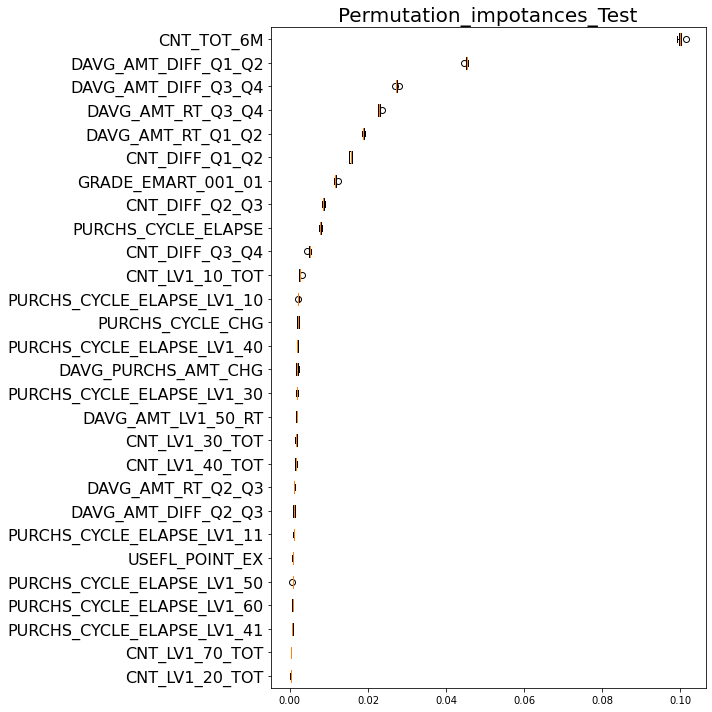

In [184]:
result = permutation_importance(cat_model_best, best_test_x, test_y, n_repeats=5, random_state=42, n_jobs=30)
sorted_idx = result.importances_mean.argsort()
fig, ax = plt.subplots(figsize=(10,10))
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels = best_test_x.columns[sorted_idx] )
ax.set_title("Permutation_impotances_Test",fontsize=20)
plt.yticks(fontsize=16)
fig.tight_layout()
plt.show()

In [185]:
permu_im = pd.concat([pd.DataFrame(test_x.drop(['CUST_ID'],axis=1).columns,columns=['nm']),pd.DataFrame(result.importances_mean, columns=['성능 영향도 평균'])],axis=1)
permu_im['imp_rank'] = permu_im['성능 영향도 평균'].rank(method='min',ascending=False)
permu_im_report1=permu_im.sort_values('성능 영향도 평균', ascending=False)
permu_im_report1

,nm,성능 영향도 평균,imp_rank
8,CNT_TOT_6M,0.10002,1.00000
9,DAVG_AMT_DIFF_Q1_Q2,0.04525,2.00000
11,DAVG_AMT_DIFF_Q3_Q4,0.02729,3.00000
15,DAVG_AMT_RT_Q3_Q4,0.02295,4.00000
13,DAVG_AMT_RT_Q1_Q2,0.01883,5.00000
0,CNT_DIFF_Q1_Q2,0.01552,6.00000
17,GRADE_EMART_001_01,0.01175,7.00000
1,CNT_DIFF_Q2_Q3,0.00857,8.00000
19,PURCHS_CYCLE_ELAPSE,0.00782,9.00000
2,CNT_DIFF_Q3_Q4,0.00502,10.00000


####   모델성능 저장 
      * 상기 출력 결과에서도 확인이 가능하나 필요 시 물리적인 파일로 리포트를 저장하여, 추가 수정, 분석 사항을 도출 함.

In [186]:
# 기준값별 베스트 모델 조회 함수
def bestmodelHP(HP_df, eval_name):
    perform1=HP_df.sort_values(by=['Case Name','학습 알고리즘',eval_name], ascending=False).drop_duplicates(subset=['Case Name','학습 알고리즘'], keep='first')
    perform1["value"]= eval_name 
    return(perform1)

In [187]:
bestmodel=bestmodelHP(hr_random_df1,'PRC_AUC')
bestmodel

,Case No,Case Name,학습 알고리즘,HP,학습시간,PRC_AUC,ROC_AUC,정분류율_Accuracy,정확도_Precision,재현율_Recall,특이도_Specificity,F1 score,value
6,0,Retention1_VIP_All,catboost,"{'iterations': 2000, 'learning_rate': 0.1, 'de...",618.12705,0.77671,0.82487,0.75457,0.73688,0.62843,0.84289,0.67835,PRC_AUC


In [188]:
# 모든 기준값별 베스트 모델 조회 함수 ,'acc','precision','recall','specific','f1'
def bestmodelHP_report(HP_df):
    report =  pd.DataFrame([])
    eval_name=['PRC_AUC','ROC_AUC', '정분류율_Accuracy','정확도_Precision', '재현율_Recall','특이도_Specificity','F1 score']
    for i in range(0,len(eval_name)):
        perform1=HP_df.sort_values(by=['Case Name','학습 알고리즘', eval_name[i]], ascending=False).drop_duplicates(subset=['Case Name','학습 알고리즘'], keep='first')
        perform1["value"]= eval_name[i]
        report=report.append(perform1)
    return(report)

In [189]:
bestmodelHP_report1=bestmodelHP_report(hr_random_df1)
bestmodelHP_report1

,Case No,Case Name,학습 알고리즘,HP,학습시간,PRC_AUC,ROC_AUC,정분류율_Accuracy,정확도_Precision,재현율_Recall,특이도_Specificity,F1 score,value
6,0,Retention1_VIP_All,catboost,"{'iterations': 2000, 'learning_rate': 0.1, 'de...",618.12705,0.77671,0.82487,0.75457,0.73688,0.62843,0.84289,0.67835,PRC_AUC
6,0,Retention1_VIP_All,catboost,"{'iterations': 2000, 'learning_rate': 0.1, 'de...",618.12705,0.77671,0.82487,0.75457,0.73688,0.62843,0.84289,0.67835,ROC_AUC
6,0,Retention1_VIP_All,catboost,"{'iterations': 2000, 'learning_rate': 0.1, 'de...",618.12705,0.77671,0.82487,0.75457,0.73688,0.62843,0.84289,0.67835,정분류율_Accuracy
0,0,Retention1_VIP_All,catboost,"{'iterations': 2000, 'learning_rate': 0.1, 'de...",507.23347,0.77640,0.82465,0.75431,0.73693,0.62734,0.84320,0.67773,정확도_Precision
4,4,Retention1_VIP_All,catboost,"{'iterations': 2000, 'learning_rate': 0.1, 'de...",651.65980,0.77628,0.82458,0.75401,0.73559,0.62863,0.84179,0.67792,재현율_Recall
0,0,Retention1_VIP_All,catboost,"{'iterations': 2000, 'learning_rate': 0.1, 'de...",507.23347,0.77640,0.82465,0.75431,0.73693,0.62734,0.84320,0.67773,특이도_Specificity
6,0,Retention1_VIP_All,catboost,"{'iterations': 2000, 'learning_rate': 0.1, 'de...",618.12705,0.77671,0.82487,0.75457,0.73688,0.62843,0.84289,0.67835,F1 score


In [190]:
#성능 결과 내보내기 : 물리엑셀파일 버전
data_stat1 = []
for i in range(0,4):
    i = []
    data_stat1.append(i)

data_stat1[0] = hr_random_df1.copy()
data_stat1[1] = cut_off_table1.copy()
data_stat1[2] = bestmodelHP_report1.copy()
data_stat1[3] = permu_im_report1.copy()

In [191]:
# 3_4. 기초통계량 엑셀 파일로 내보내기
from datetime import datetime as dt
mask ='%Y%m%d_%H%M'
dte = dt.now().strftime(mask)
writer = pd.ExcelWriter(f"{DIR_NM2}모델학습탐색_{MODEL1_NM}_{dte}.xlsx", engine="xlsxwriter")

# Write each dataframe to a different worksheet.
data_stat1[0].to_excel(writer, sheet_name='Step1_HP탐색_0.5cutoff기준', encoding="ms949" )
data_stat1[1].to_excel(writer, sheet_name='Step1_HP탐색_cutoff별', encoding="ms949") 
data_stat1[2].to_excel(writer, sheet_name='Step1_HP탐색_기준별best', encoding="ms949")
data_stat1[3].to_excel(writer, sheet_name='Step1_변수중요도참고', encoding="ms949") 
# Close the Pandas Excel writer and output the Excel file.
writer.save()

## 3. 모델 탐색  및 최적화2 : 일반 고객 대상

###  Light GBM 모델 탐색 : HP탐색 1차

##### 모델용 데이터 변환

In [223]:
def feature_to_ch(df_train,df_test,feature_ch_list):
    #df_train[feature_ch] = df_train[feature_ch].astype('category')
    #df_test[feature_ch] = df_test[feature_ch].astype('category')
    
    col_train = list(set(list(df_train.columns)) - set(['CUST_ID'])) #list(set(list(df_train.columns)) - set(feature_ch+['CUST_ID']))
    df_train[col_train] = df_train[col_train].astype('float64')
    df_test[col_train] = df_test[col_train].astype('float64')
    for i in enumerate (feature_ch_list) :
        ca = i[1]
        df_train[ca] = df_train[ca].astype('int64').astype('category')
        df_test[ca] = df_test[ca].astype('int64').astype('category')
    return(df_train, df_test)


def list_to_ch_lowlevel(df_train,unique):
    list_ch_lowlevel=[]
    col_train = list(set(list(df_train.columns)) - set(['CUST_ID']))
    for i in range(len(col_train)):  
        if len(df_train[col_train[i]].unique()) < unique:
            list_ch_lowlevel.append(col_train[i])
        else:
            pass
    print(list_ch_lowlevel)
    return(list_ch_lowlevel)

In [224]:
train_x,test_x=feature_to_ch(train_x2,test_x2,list(set(feature_ch)&set(train_x2.columns)))
train_y,test_y=train_y2, test_y2

In [225]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4351234 entries, 662250 to 938338
Data columns (total 29 columns):
 #   Column                         Dtype   
---  ------                         -----   
 0   CUST_ID                        object  
 1   AGE                            float64 
 2   CNT_DIFF_Q1_Q2                 float64 
 3   CNT_DIFF_Q2_Q3                 float64 
 4   CNT_DIFF_Q3_Q4                 float64 
 5   CNT_LV1_30_TOT                 float64 
 6   CNT_TOT_6M                     float64 
 7   DAVG_AMT_DIFF_Q1_Q2            float64 
 8   DAVG_AMT_DIFF_Q2_Q3            float64 
 9   DAVG_AMT_DIFF_Q3_Q4            float64 
 10  DAVG_AMT_RT_Q1_Q2              float64 
 11  DAVG_AMT_RT_Q2_Q3              float64 
 12  DAVG_AMT_RT_Q3_Q4              float64 
 13  DAVG_PURCHS_AMT_CHG            float64 
 14  FRST_PARTY_ELAPSE              float64 
 15  GRADE_EMART_001_01             category
 16  LSTAGE_GROUP                   category
 17  ORD_4QTY               

##### HP범위 설정
     * 변수 중요도 탐색과 1차적 성능 파악용으로 대략적 범위에서 실행
     * 사용 변수가 확정인 경우 기존 학습모델의 HP참조하여 범위 세분화하여 실행
     * 2021년 1월 모델 기준 
      {'n_estimators': 1800, 'learning_rate': 0.1, 'max_depth': -1, 'num_leaves': 20, 'boosting_type': 'gbdt', 
      'objective': 'binary', 'n_jobs': 20, 'random_state': 42}

In [226]:
# 모델별 설정해줘야할 하이퍼파라미터 dictionary case별 리스트화
LGBM_param_grad ={
    'n_estimators' : np.array(range(1700,2000,100)).tolist(),
    'learning_rate' : np.array(np.round(np.arange(0.1,0.3,0.2),2)),
    'max_depth' :  [-1,10] ,#np.array(range(-1,61,20)), #.tolist()  [-1]
    # 'feature_fraction' :  np.array(np.round(np.arange(1,1.1,0.2),1)) ,
    'num_leaves' : np.array(range(10,40,10)).tolist()#,  #np.array(range(50,100,50)).tolist(),
   #'max_bin' :[5,10,50,255] #np.array(range(10,255,35)).tolist()
   #'max_bin' : [5, 10] #np.array(range(5,45,5)).tolist()  #
}

lgb_paras_list = list(dict_product(LGBM_param_grad))  #모델에 적용 시킬 케이스 리스트, 
len(lgb_paras_list)

18

##### 모델학습
    * Light GBM은 속도가 빨라서 더 다양한 범위 탐색 가능

In [227]:
from sklearn.metrics import confusion_matrix
from lightgbm import LGBMClassifier

print("HP 탐색 전체 경우의 수 : " ,len(lgb_paras_list),"개""\n\n" )

hr_random_list = []
cut_off_table_add = pd.DataFrame(columns=[['Case No','Case Name', '학습 알고리즘', 'HP','threshold', '정분류율_Accuracy','정확도_Precision','재현율_Recall','특이도_Specificity', 'F1 score']])

for i in range(0,len(lgb_paras_list)):
    import time
    start = time.time()
    Case='Retention2_Normal_All'
    Agr= 'LGBMClassifier'
    lgb_param = {'n_estimators' : lgb_paras_list[i]['n_estimators'],
                 'learning_rate' : lgb_paras_list[i]['learning_rate'],
                 'max_depth' : lgb_paras_list[i]['max_depth'], #미설정 시 -1
                 #'feature_fraction' : lgb_paras_list[i]['feature_fraction'],
                   'num_leaves' :  lgb_paras_list[i]['num_leaves'],
                 # 'max_bin' : 100, #lgb_paras_list[i]['max_bin'], 미설정 시 255
                 'boosting_type' : 'gbdt', # dart, goss
                 'objective': 'binary', 'n_jobs' : 20 , 'random_state' :42}
    
    model = LGBMClassifier(**lgb_param)
    #evals = [(test_x_elaspe.drop(['CUST_ID'],axis=1),test_y)]
    #lgb_model = model.fit(train_x_elaspe.drop(['CUST_ID'],axis=1), train_y,  early_stopping_rounds=500,eval_set=evals,eval_metric='Recall') # 학습 진행
    lgb_model = model.fit(train_x.drop(['CUST_ID'],axis=1), train_y)
   
    lgb_prob = lgb_model.predict_proba(test_x.drop(['CUST_ID'],axis=1))[:,1] # 평가 데이터 예측
    lgb_predict = np.repeat(0,len(test_y))
    lgb_predict[lgb_prob>0.5]=1 
    
    learn_time = time.time() - start
    
    print("Case No :",i,  " Case Name :", Case,  " 학습 알고리즘 : ",  Agr,  "\n""param: ", lgb_param, 
          "\n""학습시간 :",  round(learn_time,-1), "초", "  (", round(learn_time/60), "분 )\n")  
    
    precision2, recall2, thresholds2 = precision_recall_curve(test_y, lgb_prob)
    PRC_AUC= auc(recall2, precision2)
    
    fpr, tpr, thresholds = roc_curve(test_y, lgb_prob)
    AUC= auc(fpr, tpr)
    
    print("PRC_AUC : ", PRC_AUC,  "\n""ROC_AUC : ", AUC)

    model_evaluation(test_y, lgb_predict) # 모델 분류 결과 평가 
    
    cfmat = confusion_matrix(test_y,lgb_predict)  # AUC 및 cut-off 0.5기준 평가
    
    clf = [i, Case, Agr,lgb_param, learn_time, PRC_AUC , AUC ,  acc(cfmat) , pre(cfmat) , reca(cfmat), spec(cfmat), f1(cfmat)]
    hr_random_list.append(clf)
    
    prob_y=lgb_prob
    
    threshold = np.arange(0,1,0.1)
    table = pd.DataFrame(columns=[['Case No','Case Name', '학습 알고리즘', 'HP', 'threshold', '정분류율_Accuracy','정확도_Precision','재현율_Recall','특이도_Specificity', 'F1 score']])
    for j in threshold:
        pred_Y = cut_off(prob_y,j)
        cfmat2 = confusion_matrix(test_y, pred_Y)
        table.loc[j] = i, Case, Agr, lgb_param, j,  acc(cfmat2), pre(cfmat2),reca(cfmat2),spec(cfmat2),f1(cfmat2)
        #table.index.name='threshold'
        #table.columns.name='performance'
    
    cut_off_table_add=cut_off_table_add.append(table, ignore_index=True) 

HP 탐색 전체 경우의 수 :  18 개


Case No : 0  Case Name : Retention2_Normal_All  학습 알고리즘 :  LGBMClassifier 
param:  {'n_estimators': 1700, 'learning_rate': 0.1, 'max_depth': -1, 'num_leaves': 10, 'boosting_type': 'gbdt', 'objective': 'binary', 'n_jobs': 20, 'random_state': 42} 
학습시간 : 70.0 초   ( 1 분 )

PRC_AUC :  0.6797654309111508 
ROC_AUC :  0.7538540720332261
Accuracy : 0.6917363250350016 
Precision : 0.653884069632568 
Recall : 0.5962140373233107 
Specificity : 0.763361676527267 
F1-Score  : 0.6237188248310654 


Case No : 1  Case Name : Retention2_Normal_All  학습 알고리즘 :  LGBMClassifier 
param:  {'n_estimators': 1700, 'learning_rate': 0.1, 'max_depth': -1, 'num_leaves': 20, 'boosting_type': 'gbdt', 'objective': 'binary', 'n_jobs': 20, 'random_state': 42} 
학습시간 : 80.0 초   ( 1 분 )

PRC_AUC :  0.6799087027221967 
ROC_AUC :  0.7537865230129991
Accuracy : 0.6916149802033261 
Precision : 0.6538301263563829 
Recall : 0.5957721128494904 
Specificity : 0.7634807115074654 
F1-Score  : 0.6234523972548

Accuracy : 0.6915965946227692 
Precision : 0.6537790677146227 
Recall : 0.595832180253699 
Specificity : 0.7634034996284178 
F1-Score  : 0.6234620694299472 


Case No : 17  Case Name : Retention2_Normal_All  학습 알고리즘 :  LGBMClassifier 
param:  {'n_estimators': 1900, 'learning_rate': 0.1, 'max_depth': 10, 'num_leaves': 30, 'boosting_type': 'gbdt', 'objective': 'binary', 'n_jobs': 20, 'random_state': 42} 
학습시간 : 90.0 초   ( 1 분 )

PRC_AUC :  0.6797452956902131 
ROC_AUC :  0.753603698789802
Accuracy : 0.6916489935273563 
Precision : 0.6536403727350516 
Recall : 0.5965036480221735 
Specificity : 0.762991702940164 
F1-Score  : 0.6237663186916108 




In [228]:
hr_random_df_add = pd.DataFrame(hr_random_list,
                            columns=['Case No','Case Name', '학습 알고리즘', 'HP', '학습시간',  'PRC_AUC',  'ROC_AUC', '정분류율_Accuracy','정확도_Precision','재현율_Recall','특이도_Specificity', 'F1 score'])

In [229]:
hr_random_df_add.head(10)

,Case No,Case Name,학습 알고리즘,HP,학습시간,PRC_AUC,ROC_AUC,정분류율_Accuracy,정확도_Precision,재현율_Recall,특이도_Specificity,F1 score
0,0,Retention2_Normal_All,LGBMClassifier,"{'n_estimators': 1700, 'learning_rate': 0.1, '...",67.99386,0.67977,0.75385,0.69174,0.65388,0.59621,0.76336,0.62372
1,1,Retention2_Normal_All,LGBMClassifier,"{'n_estimators': 1700, 'learning_rate': 0.1, '...",76.49113,0.67991,0.75379,0.69161,0.65383,0.59577,0.76348,0.62345
2,2,Retention2_Normal_All,LGBMClassifier,"{'n_estimators': 1700, 'learning_rate': 0.1, '...",79.25750,0.67971,0.75362,0.69199,0.65428,0.59631,0.76373,0.62395
3,3,Retention2_Normal_All,LGBMClassifier,"{'n_estimators': 1700, 'learning_rate': 0.1, '...",64.62462,0.67977,0.75385,0.69174,0.65388,0.59621,0.76336,0.62372
4,4,Retention2_Normal_All,LGBMClassifier,"{'n_estimators': 1700, 'learning_rate': 0.1, '...",68.35355,0.67988,0.75381,0.69161,0.65381,0.59580,0.76345,0.62346
5,5,Retention2_Normal_All,LGBMClassifier,"{'n_estimators': 1700, 'learning_rate': 0.1, '...",69.73646,0.67978,0.75364,0.69162,0.65359,0.59648,0.76295,0.62373
6,6,Retention2_Normal_All,LGBMClassifier,"{'n_estimators': 1800, 'learning_rate': 0.1, '...",74.15809,0.67978,0.75387,0.69181,0.65394,0.59641,0.76335,0.62385
7,7,Retention2_Normal_All,LGBMClassifier,"{'n_estimators': 1800, 'learning_rate': 0.1, '...",77.49948,0.67991,0.75378,0.69162,0.65387,0.59571,0.76354,0.62344
8,8,Retention2_Normal_All,LGBMClassifier,"{'n_estimators': 1800, 'learning_rate': 0.1, '...",79.31969,0.67968,0.75359,0.69194,0.65415,0.59642,0.76356,0.62395
9,9,Retention2_Normal_All,LGBMClassifier,"{'n_estimators': 1800, 'learning_rate': 0.1, '...",73.09005,0.67978,0.75387,0.69181,0.65394,0.59641,0.76335,0.62385


In [230]:
cut_off_table_add.head(10)

,Case No,Case Name,학습 알고리즘,HP,threshold,정분류율_Accuracy,정확도_Precision,재현율_Recall,특이도_Specificity,F1 score
0,0,Retention2_Normal_All,LGBMClassifier,"{'n_estimators': 1700, 'learning_rate': 0.1, '...",0.00000,0.42852,0.42852,1.00000,0.00000,0.59995
1,0,Retention2_Normal_All,LGBMClassifier,"{'n_estimators': 1700, 'learning_rate': 0.1, '...",0.10000,0.47585,0.44942,0.99136,0.08931,0.61846
2,0,Retention2_Normal_All,LGBMClassifier,"{'n_estimators': 1700, 'learning_rate': 0.1, '...",0.20000,0.56605,0.49667,0.94565,0.28143,0.65128
3,0,Retention2_Normal_All,LGBMClassifier,"{'n_estimators': 1700, 'learning_rate': 0.1, '...",0.30000,0.63501,0.54685,0.86513,0.46245,0.67012
4,0,Retention2_Normal_All,LGBMClassifier,"{'n_estimators': 1700, 'learning_rate': 0.1, '...",0.40000,0.67775,0.59928,0.74849,0.62471,0.66562
5,0,Retention2_Normal_All,LGBMClassifier,"{'n_estimators': 1700, 'learning_rate': 0.1, '...",0.50000,0.69174,0.65388,0.59621,0.76336,0.62372
6,0,Retention2_Normal_All,LGBMClassifier,"{'n_estimators': 1700, 'learning_rate': 0.1, '...",0.60000,0.67820,0.71217,0.41795,0.87334,0.52676
7,0,Retention2_Normal_All,LGBMClassifier,"{'n_estimators': 1700, 'learning_rate': 0.1, '...",0.70000,0.64142,0.77195,0.23164,0.94869,0.35635
8,0,Retention2_Normal_All,LGBMClassifier,"{'n_estimators': 1700, 'learning_rate': 0.1, '...",0.80000,0.59432,0.83644,0.06625,0.99029,0.12278
9,0,Retention2_Normal_All,LGBMClassifier,"{'n_estimators': 1700, 'learning_rate': 0.1, '...",0.90000,0.57204,0.89947,0.00146,0.99988,0.00291


In [231]:
#Confusion Matrix
pd.DataFrame(cfmat)

,0,1
0,474326,147340
1,188087,278056


In [232]:
hr_random_df2 = hr_random_df_add.copy()
cut_off_table2 = cut_off_table_add.copy()
hr_random_df_lgb1 = hr_random_df_add.copy()
cut_off_table_lgb1 = cut_off_table_add.copy()

##### 베스트 모델 조회  및 생성
      * 위의 결과에서 PRC_AUC가 가장 큰 HP값을 저장하여 최종모델 생성

In [233]:
# 기준값별 베스트 모델 조회 함수
def bestmodelHP(HP_df, eval_name):
    perform1=HP_df.sort_values(by=['Case Name','학습 알고리즘',eval_name], ascending=False).drop_duplicates(subset=['Case Name','학습 알고리즘'], keep='first')
    perform1["value"]= eval_name 
    return(perform1)

bestmodel_CASE_LGBM=bestmodelHP(hr_random_df2,'PRC_AUC')
bestmodel_CASE_LGBM

,Case No,Case Name,학습 알고리즘,HP,학습시간,PRC_AUC,ROC_AUC,정분류율_Accuracy,정확도_Precision,재현율_Recall,특이도_Specificity,F1 score,value
7,7,Retention2_Normal_All,LGBMClassifier,"{'n_estimators': 1800, 'learning_rate': 0.1, '...",77.49948,0.67991,0.75378,0.69162,0.65387,0.59571,0.76354,0.62344,PRC_AUC


In [234]:
#lgb_best_HP = best_prc_LGBM[bestmodel_CASE_LGBM.reset_index().iloc[0][0]]
lgb_best_HP = bestmodel_CASE_LGBM.iloc[0]["HP"]
lgb_best_HP

{'n_estimators': 1800,
 'learning_rate': 0.1,
 'max_depth': -1,
 'num_leaves': 20,
 'boosting_type': 'gbdt',
 'objective': 'binary',
 'n_jobs': 20,
 'random_state': 42}

In [235]:
best_train_x = train_x.drop(['CUST_ID'],axis=1)
best_test_x = test_x.drop(['CUST_ID'],axis=1)

In [236]:
from sklearn.metrics import confusion_matrix
from lightgbm import LGBMClassifier
 
cut_off_table_add = pd.DataFrame(columns=[['Case No','Case Name', '학습 알고리즘', 'HP','threshold', '정분류율_Accuracy','정확도_Precision','재현율_Recall','특이도_Specificity', 'F1 score']])
i = 0
import time
start = time.time()
Case='Retention2_Normal_All'
Agr= 'LGBMClassifier'
lgb_param = lgb_best_HP

model = LGBMClassifier(**lgb_param)
lgb_model_best = model.fit(best_train_x, train_y) # 학습 진행

lgb_prob = lgb_model_best.predict_proba(best_test_x)[:,1] # 평가 데이터 예측
lgb_predict = np.repeat(0,len(test_y))
lgb_predict[lgb_prob>0.5]=1 

learn_time = time.time() - start

print("Case No :",i,  " Case Name :", Case,  " 학습 알고리즘 : ",  Agr,  "\n""param: ", lgb_param, 
          "\n""학습시간 :",  round(learn_time,-1), "초", "  (", round(learn_time/60), "분 )\n")

precision2, recall2, thresholds2 = precision_recall_curve(test_y, lgb_prob)
PRC_AUC= auc(recall2, precision2)

fpr, tpr, thresholds = roc_curve(test_y, lgb_prob)
AUC= auc(fpr, tpr)

print("PRC_AUC : ", PRC_AUC,  "\n""ROC_AUC : ", AUC)

model_evaluation(test_y, lgb_predict) # 모델 분류 결과 평가 

cfmat = confusion_matrix(test_y,lgb_predict)  # AUC 및 cut-off 0.5기준 평가

clf = [i, Case, Agr,lgb_param, learn_time, PRC_AUC , AUC ,  acc(cfmat) , pre(cfmat) , reca(cfmat), spec(cfmat), f1(cfmat)]
 

prob_y=lgb_prob

threshold = np.arange(0,1,0.1)
table = pd.DataFrame(columns=[['Case No','Case Name', '학습 알고리즘', 'HP', 'threshold', '정분류율_Accuracy','정확도_Precision','재현율_Recall','특이도_Specificity', 'F1 score']])
for j in threshold:
    pred_Y = cut_off(prob_y,j)
    cfmat2 = confusion_matrix(test_y, pred_Y)
    table.loc[j] = i, Case, Agr, lgb_param, j,  acc(cfmat2), pre(cfmat2),reca(cfmat2),spec(cfmat2),f1(cfmat2)
    #table.index.name='threshold'
    #table.columns.name='performance'

cut_off_table_add=cut_off_table_add.append(table, ignore_index=True) 

Case No : 0  Case Name : Retention2_Normal_All  학습 알고리즘 :  LGBMClassifier 
param:  {'n_estimators': 1800, 'learning_rate': 0.1, 'max_depth': -1, 'num_leaves': 20, 'boosting_type': 'gbdt', 'objective': 'binary', 'n_jobs': 20, 'random_state': 42} 
학습시간 : 80.0 초   ( 1 분 )

PRC_AUC :  0.6799111485525624 
ROC_AUC :  0.753782139641239
Accuracy : 0.6916241729936046 
Precision : 0.6538658064212298 
Recall : 0.5957120454452818 
Specificity : 0.7635418375783781 
F1-Score  : 0.6234357249659868 




In [237]:
hr_random_list = []
hr_random_list.append(clf)

In [238]:
hr_random_df_add = pd.DataFrame(hr_random_list,
                            columns=['Case No','Case Name', '학습 알고리즘', 'HP', '학습시간',  'PRC_AUC',  'ROC_AUC', '정분류율_Accuracy','정확도_Precision','재현율_Recall','특이도_Specificity', 'F1 score'])

In [239]:
pd.DataFrame(cfmat)

,0,1
0,474668,146998
1,188456,277687


In [240]:
#hr_random_df=hr_random_df_add.copy()
#cut_off_table=cut_off_table_add.copy()
hr_random_df_lgb2=hr_random_df_add.copy()
cut_off_table_lgb2=cut_off_table_add.copy()

In [241]:
hr_random_df2=hr_random_df2.append(hr_random_df_lgb2, ignore_index=True) 
cut_off_table2=cut_off_table2.append(cut_off_table_lgb2, ignore_index=True) 

### HP를 최적화하여 생성한 모델 저장

#### ★추후 예측에 사용할 모델 물리적 저장★

In [242]:
from datetime import datetime as dt
mask ='%Y%m%d_%H%M'
dte = dt.now().strftime(mask)
save_model(lgb_model_best,f"{MODEL2_NM}_LGBM_{dte}.pickle") 

/home/cdsadmin/python_src/EY/YUN/model_result/ 경로에 model_retention2_Normal_LGBM_20210115_1334.pickle. 모델 저장완료 


#### 생성 모델의 테스트 데이터 예측값과 리뷰용 프로파일링 정보 저장

In [243]:
#생성 모델의 테스트 데이터 예측값과 리뷰용 프로파일링 정보 저장
lgb_predict1 = test_x['CUST_ID'].reset_index().drop(['index'],axis=1)
lgb_predict2 = pd.DataFrame(lgb_prob,columns=['prob']).reset_index().drop(['index'],axis=1)
lgb_predict3 = pd.concat([lgb_predict1,lgb_predict2],axis=1)#.drop(['index'],axis=1)
pred_normal = pd.merge(left=lgb_predict3, right=data_modi1_noraml, how="left", on="CUST_ID")
pred_normal.to_feather(f"{DIR_NM2}testpred_{MODEL2_NM}_LGBM_{dte}.ftr")

#### 변수 중요도
    * 변수 전체 사용 모델에서 변수 선택 위한 탐색 실행 시 여기부터 재시작

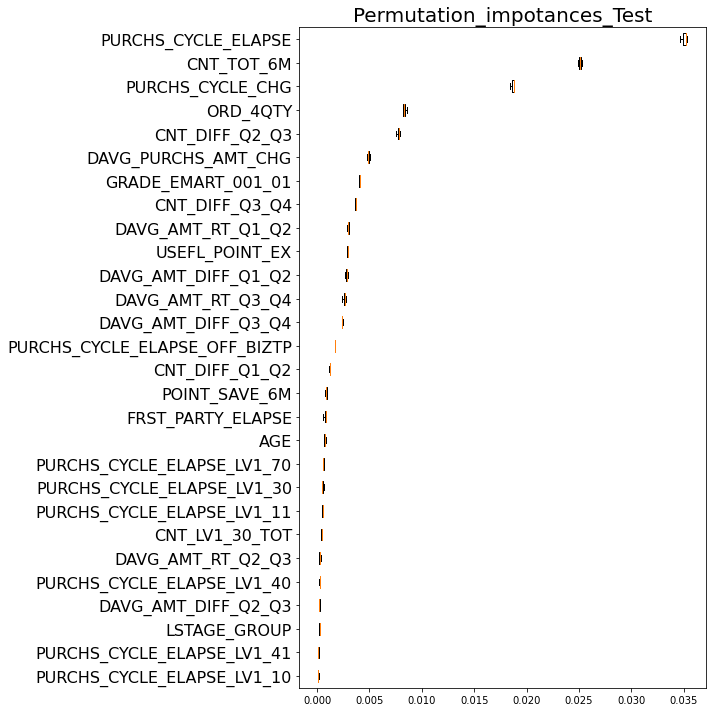

In [244]:
result     = permutation_importance(lgb_model_best, best_test_x, test_y, n_repeats=3, random_state=42, n_jobs=30)
sorted_idx = result.importances_mean.argsort()
fig, ax    = plt.subplots(figsize=(10,10))
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels = best_test_x.columns[sorted_idx] )
ax.set_title("Permutation_impotances_Test",fontsize=20)
plt.yticks(fontsize=16)
fig.tight_layout()
plt.show()

In [245]:
permu_im = pd.concat([pd.DataFrame(test_x.drop(['CUST_ID'],axis=1).columns,columns=['nm']),pd.DataFrame(result.importances_mean, columns=['성능 영향도 평균'])],axis=1)
permu_im['imp_rank'] = permu_im['성능 영향도 평균'].rank(method='min',ascending=False)
permu_im_report2=permu_im.sort_values('성능 영향도 평균', ascending=False)
permu_im_report2

,nm,성능 영향도 평균,imp_rank
19,PURCHS_CYCLE_ELAPSE,0.03504,1.00000
5,CNT_TOT_6M,0.02509,2.00000
18,PURCHS_CYCLE_CHG,0.01868,3.00000
16,ORD_4QTY,0.00835,4.00000
2,CNT_DIFF_Q2_Q3,0.00776,5.00000
12,DAVG_PURCHS_AMT_CHG,0.00488,6.00000
14,GRADE_EMART_001_01,0.00406,7.00000
3,CNT_DIFF_Q3_Q4,0.00367,8.00000
9,DAVG_AMT_RT_Q1_Q2,0.00296,9.00000
27,USEFL_POINT_EX,0.00292,10.00000


####   모델성능 저장 
      * 상기 출력 결과에서도 확인이 가능하나 필요 시 물리적인 파일로 리포트를 저장하여, 추가 수정, 분석 사항을 도출 함.

In [246]:
# 기준값별 베스트 모델 조회 함수
def bestmodelHP(HP_df, eval_name):
    perform1=HP_df.sort_values(by=['Case Name','학습 알고리즘',eval_name], ascending=False).drop_duplicates(subset=['Case Name','학습 알고리즘'], keep='first')
    perform1["value"]= eval_name 
    return(perform1)

In [247]:
bestmodel=bestmodelHP(hr_random_df2,'PRC_AUC')
bestmodel

,Case No,Case Name,학습 알고리즘,HP,학습시간,PRC_AUC,ROC_AUC,정분류율_Accuracy,정확도_Precision,재현율_Recall,특이도_Specificity,F1 score,value
7,7,Retention2_Normal_All,LGBMClassifier,"{'n_estimators': 1800, 'learning_rate': 0.1, '...",77.49948,0.67991,0.75378,0.69162,0.65387,0.59571,0.76354,0.62344,PRC_AUC


In [248]:
# 모든 기준값별 베스트 모델 조회 함수 ,'acc','precision','recall','specific','f1'
def bestmodelHP_report(HP_df):
    report =  pd.DataFrame([])
    eval_name=['PRC_AUC','ROC_AUC', '정분류율_Accuracy','정확도_Precision', '재현율_Recall','특이도_Specificity','F1 score']
    for i in range(0,len(eval_name)):
        perform1=HP_df.sort_values(by=['Case Name','학습 알고리즘', eval_name[i]], ascending=False).drop_duplicates(subset=['Case Name','학습 알고리즘'], keep='first')
        perform1["value"]= eval_name[i]
        report=report.append(perform1)
    return(report)

In [249]:
bestmodelHP_report2=bestmodelHP_report(hr_random_df2)
bestmodelHP_report2

,Case No,Case Name,학습 알고리즘,HP,학습시간,PRC_AUC,ROC_AUC,정분류율_Accuracy,정확도_Precision,재현율_Recall,특이도_Specificity,F1 score,value
7,7,Retention2_Normal_All,LGBMClassifier,"{'n_estimators': 1800, 'learning_rate': 0.1, '...",77.49948,0.67991,0.75378,0.69162,0.65387,0.59571,0.76354,0.62344,PRC_AUC
12,12,Retention2_Normal_All,LGBMClassifier,"{'n_estimators': 1900, 'learning_rate': 0.1, '...",80.08319,0.67982,0.75389,0.69179,0.65389,0.59648,0.76326,0.62386,ROC_AUC
2,2,Retention2_Normal_All,LGBMClassifier,"{'n_estimators': 1700, 'learning_rate': 0.1, '...",79.25750,0.67971,0.75362,0.69199,0.65428,0.59631,0.76373,0.62395,정분류율_Accuracy
2,2,Retention2_Normal_All,LGBMClassifier,"{'n_estimators': 1700, 'learning_rate': 0.1, '...",79.25750,0.67971,0.75362,0.69199,0.65428,0.59631,0.76373,0.62395,정확도_Precision
11,11,Retention2_Normal_All,LGBMClassifier,"{'n_estimators': 1800, 'learning_rate': 0.1, '...",81.55045,0.67976,0.75362,0.69164,0.65361,0.59652,0.76295,0.62376,재현율_Recall
2,2,Retention2_Normal_All,LGBMClassifier,"{'n_estimators': 1700, 'learning_rate': 0.1, '...",79.25750,0.67971,0.75362,0.69199,0.65428,0.59631,0.76373,0.62395,특이도_Specificity
8,8,Retention2_Normal_All,LGBMClassifier,"{'n_estimators': 1800, 'learning_rate': 0.1, '...",79.31969,0.67968,0.75359,0.69194,0.65415,0.59642,0.76356,0.62395,F1 score


In [250]:
#성능 결과 내보내기 : 물리엑셀파일 버전
data_stat2 = []
for i in range(0,4):
    i = []
    data_stat2.append(i)
    
data_stat2[0] = hr_random_df2.copy()
data_stat2[1] = cut_off_table2.copy()
data_stat2[2] = bestmodelHP_report2.copy()
data_stat2[3] = permu_im_report2.copy()    

In [251]:
# 3_4. 기초통계량 엑셀 파일로 내보내기
from datetime import datetime as dt
mask ='%Y%m%d_%H%M'
dte = dt.now().strftime(mask)
writer = pd.ExcelWriter(f"{DIR_NM2}모델학습탐색_{MODEL2_NM}_{dte}.xlsx", engine="xlsxwriter")

# Write each dataframe to a different worksheet.
data_stat2[0].to_excel(writer, sheet_name='Step1_HP탐색_0.5cutoff기준', encoding="ms949" )
data_stat2[1].to_excel(writer, sheet_name='Step1_HP탐색_cutoff별', encoding="ms949") 
data_stat2[2].to_excel(writer, sheet_name='Step1_HP탐색_기준별best', encoding="ms949")
data_stat2[3].to_excel(writer, sheet_name='Step1_변수중요도참고', encoding="ms949") 
# Close the Pandas Excel writer and output the Excel file.
writer.save()